### Machine Learning Homework III

### 1. Logistic Regression (bh2821)

* This document is open sourced under Apeche License Version 2.0
* Author: Nathmath Huang (bh2821)
* Date  : April 26, 2025

`P. Libraries`

In [1]:
import torch
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from typing import List, Dict, Tuple, Any, Optional, Union

In [2]:
from copy import deepcopy

import lzma
import random
import matplotlib.pyplot as plt


In [3]:
# I have cuda
torch.cuda.is_available()

True

In [4]:
# Whether using `numpy` as the backend or `torch`
backend = "numpy"; _backend = np
device = "cpu"    
# For trees, do NOT use cuda since the latency between CPU and GPU is significant
# And so for RandomForest.

# Feel free to change those parameters since I have debugged and ensured all of them are useful.
# Though, their result may NOT be completely the same.

`P. Matrix Wrapper Library (self-implemented)`

In [5]:
# This object class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Object:
    """
    Base Type for all advanced n-dimensional data types.
    """
   
    __attr__ = "MML.Object"  
    
    def __init__(self):
        pass
   
    def __repr__(self):
        return f"Object (Abstract Data Type)."


In [6]:
# This matrix class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Matrix(Object):
    """
    A production-level Matrix class that provides a unified interface for common matrix operations used in machine learning.
    The underlying data is stored as either a numpy.ndarray or a torch.Tensor depending on the chosen backend.
    This class supports element-wise arithmetic, matrix multiplication, transpose, determinant, inverse, trace, and SVD.
    Internal optimizations avoid repeated string comparisons by setting boolean flags during initialization.
    """
    __attr__ = "MML.Matrix"    
    
    def e(self):
        """
        Returns natural exponent value as a single-value Matrix.
        
        Returns:
            -------
            Matrix with 0 shape. exp value.
        """
        if self._is_numpy:
            return Matrix(np.e, backend = self._backend, dtype = self.dtype, device = self.device)
        else:
            return Matrix(torch.e, backend = self._backend, dtype = self.dtype, device = self.device)
    
    def pi(self):
        """
        Returns pi value as a single-value Matrix.
        
        Returns:
            -------
            Matrix with 0 shape. pi value.
        """
        if self._is_numpy:
            return Matrix(np.pi, backend = self._backend, dtype = self.dtype, device = self.device)
        else:
            return Matrix(torch.pi, backend = self._backend, dtype = self.dtype, device = self.device)
    
    def __init__(self, data, backend="numpy", *, dtype=None, device=None):
        """
        Initializes a Matrix instance with the specified backend.
        
        Args:
            data (array-like): Input data to be converted into a matrix.
            backend (str): The backend to use ("numpy" or "torch").
            dtype(str): The type of data to be stored in (any type or None).
            device (str): Device where the data is stored on ("cpu" or "cuda", or None).
            
        Raises:
            ValueError: If an unsupported backend is provided.
        """
        super().__init__()
        
        self._backend = backend.lower()
        if self._backend not in ("numpy", "torch"):
            raise ValueError("Unsupported backend. Please choose 'numpy' or 'torch'.")
        self._is_numpy = (self._backend == "numpy")
        self._is_torch = (self._backend == "torch")
        
        # Convert input data to the appropriate type.
        # By Nathmath Huang
        if self._is_numpy:
            self.data = np.array(data, dtype=dtype)
        else:
            if torch is None:
                raise ImportError("PyTorch is not installed but backend 'torch' was requested.")
            self.data = data.to(device, dtype=dtype) if isinstance(data, torch.Tensor) else torch.tensor(data, device=device, dtype=dtype)
    
    def __repr__(self):
        """
        Returns a string representation of the Matrix showing the backend, shape, and data.
        """
        return f"Matrix(backend={self._backend}, shape={self.shape}, data=\n{self.data})"
    
    def __getitem__(self, key):
       """
       Allows subscription using a[i, j]. 
       If the result is an array, it returns a new Matrix; otherwise, the scalar value.
       """
       result = self.data[key]
       if (self._is_numpy and isinstance(result, np.ndarray)) or (self._is_torch and torch is not None and isinstance(result, torch.Tensor)):
           return Matrix(result, backend=self._backend)
       return result
   
    def __setitem__(self, key, value):
        """
        Allows assignment using a[i, j] = value.
        If the value is a Matrix instance, its underlying data is used.
        """
        if isinstance(value, Matrix):
            value = value.data
        self.data[key] = value
   
    def submatrix(self, key):
      """
      Retrieves a sub-array of the matrix using the given key while ensuring the result remains two-dimensional.
      For example, using a[:, 1] will return a Matrix of shape (m, 1) rather than (m,).
      
      Args:
          key: Indexing key (can be an int, slice, or tuple of such) for sub-array extraction.
      
      Returns:
          Matrix: A new Matrix instance representing the sub-array with two dimensions.
      """
      result = self.data[key]
      # For numpy backend: if result is 1D but the original matrix is 2D, adjust the shape.
      if self._is_numpy and isinstance(result, np.ndarray):
          if result.ndim == 1 and len(self.data.shape) == 2:
              if isinstance(key, tuple):
                  if len(key) == 2:
                      if isinstance(key[0], slice) and isinstance(key[1], int):
                          # Selecting a column -> reshape to (m, 1)
                          result = result[:, np.newaxis]
                      elif isinstance(key[0], int) and isinstance(key[1], slice):
                          # Selecting a row -> reshape to (1, n)
                          result = result[np.newaxis, :]
                      else:
                          result = np.atleast_2d(result)
                  else:
                      result = np.atleast_2d(result)
              else:
                  # key is a single index (e.g., a[1]) -> treat as row selection.
                  result = result[np.newaxis, :]
      # For torch backend: similar adjustments using unsqueeze.
      elif self._is_torch and torch is not None and isinstance(result, torch.Tensor):
          if result.dim() == 1 and len(self.data.shape) == 2:
              if isinstance(key, tuple):
                  if len(key) == 2:
                      if isinstance(key[0], slice) and isinstance(key[1], int):
                          result = result.unsqueeze(1)  # Make column vector.
                      elif isinstance(key[0], int) and isinstance(key[1], slice):
                          result = result.unsqueeze(0)  # Make row vector.
                      else:
                          result = result.unsqueeze(0)
                  else:
                      result = result.unsqueeze(0)
              else:
                  result = result.unsqueeze(0)
      return Matrix(result, backend=self._backend) 
   
    @property
    def shape(self):
        """
        Returns the shape of the matrix.
        """
        return self.data.shape
    
    @property
    def dtype(self):
        """
        Returns the data type of the matrix elements.
        """
        return self.data.dtype
    
    @property
    def device(self):
        """
        Returns the data device of the matrix elements.
        """
        if self._backend == "numpy":
            return "cpu"
        else:
            return self.data.device.type

    def reshape(self, shape):
        """
        Converts the matrix into a new shape.
        
        Returns:
            Matrix: A new Matrix object with the specified shape.
        """
        return Matrix(self.data.reshape(shape), backend=self._backend)
    
    def astype(self, dtype):
        """
        Converts the underlying data to the specified type.
        
        For the numpy backend, it uses np.ndarray.astype.
        For the torch backend, it maps the input (which can be a torch.dtype, a string, or a numpy type)
        to the corresponding torch dtype and uses tensor.to(dtype=...).
        
        Args:
            dtype: The desired data type. For numpy, any valid numpy dtype is accepted.
                   For torch, this can be a torch.dtype, a string (e.g., "float32", "int64"),
                   or a numpy dtype.
                   
        Returns:
            A new Matrix instance with the data converted to the specified type.
        """
        if self._is_numpy:
            new_data = self.data.astype(dtype)
            return Matrix(new_data, backend="numpy")
        else:
            # Map the input dtype to a torch dtype.
            torch_dtype = None
            if isinstance(dtype, torch.dtype):
                torch_dtype = dtype
            elif isinstance(dtype, str):
                mapping = {
                    "float32": torch.float32,
                    "float": torch.float32,
                    "float64": torch.float64,
                    "double": torch.float64,
                    "int32": torch.int32,
                    "int": torch.int32,
                    "int64": torch.int64,
                    "long": torch.int64,
                    "bool": torch.bool,
                    "complex64": torch.complex64,
                    "complex128": torch.complex128
                }
                if dtype in mapping:
                    torch_dtype = mapping[dtype]
                else:
                    raise ValueError(f"Unsupported dtype string: {dtype}")
            elif isinstance(dtype, (np.dtype, type)):
                np_dtype = np.dtype(dtype)
                mapping = {
                    np.dtype("float32"): torch.float32,
                    np.dtype("float64"): torch.float64,
                    np.dtype("int32"): torch.int32,
                    np.dtype("int64"): torch.int64,
                    np.dtype("bool"): torch.bool,
                    np.dtype("complex64"): torch.complex64,
                    np.dtype("complex128"): torch.complex128,
                }
                if np_dtype in mapping:
                    torch_dtype = mapping[np_dtype]
                else:
                    raise ValueError(f"Unsupported numpy dtype: {np_dtype}")
            else:
                raise ValueError(f"Unsupported dtype argument: {dtype}")
            new_data = self.data.to(dtype=torch_dtype)
            return Matrix(new_data, backend="torch")

    def to(self, backend, *, dtype=None, device=None):
        """
        Converts the matrix to the specified backend and optionally sets the device for torch tensors.
        
        Args:
            backend (str): The target backend ("numpy" or "torch").
            dtype (str, optional): The target type (any numpy or torch type nor None for auto inferenence).
            device (str, optional): The target device for torch tensors (e.g., "cpu" or "cuda").
                                    Ignored if converting to numpy.
        
        Returns:
            Matrix: A new Matrix object with data in the target backend and on the specified device.
        """
        target = backend.lower()
        if target == self._backend:
            # Already in the target backend: for torch, adjust device if specified.
            if self._is_torch:
                new_data = self.data.to(device = device, dtype = dtype)
                return Matrix(new_data, backend="torch")
            return Matrix(self.data, backend=self._backend, device=device, dtype=dtype)
        if target == "numpy":
            # Converting from torch to numpy: always bring to CPU.
            if self._is_torch:
                return Matrix(self.data.cpu().to(dtype = dtype).numpy(), backend="numpy")
        elif target == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            if self._is_numpy:
                new_data = torch.tensor(self.data, device = device, dtype = dtype)
                return Matrix(new_data, backend="torch")
        raise ValueError("Unsupported backend conversion.")

    def to_rational(self):
        """
        Converts all values stored in the matrix to rational numbers (fractions.Fraction).
        For the numpy backend, returns a new Matrix with a numpy array of Fraction objects (dtype=object).
        For the torch backend, due to limitations of torch tensors with non-numeric types,
        the conversion is performed via numpy and the underlying data becomes a numpy array of Fraction objects,
        while the backend attribute is preserved as 'torch'.
        """
        if self._is_numpy:
            vec_func = np.vectorize(lambda x: float(x.real))
            new_data = vec_func(self.data)
            return Matrix(new_data, backend="numpy")
        else:
            # Convert torch tensor to numpy, then to Fraction.
            np_data = self.data.cpu().numpy()
            vec_func = np.vectorize(lambda x: float(x.real))
            new_data = vec_func(np_data)
            # Although backend remains 'torch', data is now a numpy array.
            return Matrix(new_data, backend="torch")

    def to_complex(self):
        """
        Converts all values stored in the matrix to complex numbers.
        For the numpy backend, returns a new Matrix with a numpy array of complex numbers.
        For the torch backend, returns a new Matrix with data converted to a torch complex tensor.
        """
        if self._is_numpy:
            new_data = self.data.astype(complex)
            return Matrix(new_data, backend="numpy")
        else:
            if not torch.is_complex(self.data):
                new_data = self.data.to(torch.complex64)
                return Matrix(new_data, backend="torch")
            return Matrix(self.data, backend="torch")
        
    def _apply_op(self, other, op):
        """
        Internal helper to apply an element-wise binary operation.
        
        Args:
            other (Matrix or scalar): The other operand.
            op (callable): A function that applies the desired operation element-wise.
            
        Returns:
            Matrix: A new Matrix instance with the operation applied.
        """
        other_val = other.data if isinstance(other, Matrix) else other
        result = op(self.data, other_val)
        return Matrix(result, backend=self._backend)
    
    def copy(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current matrix with the specified backend and data type.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Matrix: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Matrix(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Matrix(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Matrix(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Matrix(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def append(self, to_append, axis=0):
        """
        Append a scalar (broadcasted) or an array to the matrix along the specified axis.
        
        Args:
            to_append: A scalar value or an array-like object (or Matrix) to append.
            axis (int): Axis along which to append. For 2D matrices, use axis=0 (append row)
                        or axis=1 (append column).
                        
        Returns:
            Matrix: A new Matrix instance with the appended data.
        """
        orig_shape = self.data.shape
    
        # If to_append is an instance of self, extract its underlying data.
        if isinstance(to_append, type(self)):
            append_data = to_append.data
        else:
            # If to_append is a scalar, create an array of appropriate shape.
            if np.isscalar(to_append):
                if axis == 0:
                    new_shape = (1, orig_shape[1])
                elif axis == 1:
                    new_shape = (orig_shape[0], 1)
                else:
                    raise ValueError("Axis out of bounds. Only axis=0 or axis=1 are supported.")
                if self._is_numpy:
                    append_data = np.full(new_shape, to_append, dtype=self.data.dtype)
                else:
                    append_data = torch.full(new_shape, to_append, dtype=self.data.dtype, device=self.data.device.type)
            # Not a scalar
            else:
                # If the input is a matrix.
                if isinstance(to_append, Matrix):
                    if self._is_numpy:
                        append_data = np.array(to_append.data.copy(), dtype=self.data.dtype)
                    else:
                        append_data = torch.tensor(to_append.data.clone().detach(), dtype=self.data.dtype, device=self.data.device.type)
                    
                # Otherwise, assume to_append is array-like.
                else:
                    if self._is_numpy:
                        append_data = np.array(to_append.copy(), dtype=self.data.dtype)
                    else:
                        append_data = torch.tensor(to_append.clone().detach(), dtype=self.data.dtype, device=self.data.device.type)
                    
                # Validate dimensions (assuming 2D matrices)
                if len(append_data.shape) != len(orig_shape):
                    raise ValueError("Dimension mismatch: appended data must match dimensions of the matrix.")
                if axis == 0:
                    if append_data.shape[1:] != orig_shape[1:]:
                        raise ValueError("Shape mismatch for axis 0: appended array must have the same number of columns.")
                elif axis == 1:
                    if append_data.shape[0] != orig_shape[0]:
                        raise ValueError("Shape mismatch for axis 1: appended array must have the same number of rows.")
                else:
                    raise ValueError("Axis out of bounds. Only axis=0 or axis=1 are supported.")
        
        # Concatenate along the specified axis using the appropriate backend.
        if self._is_numpy:
            new_data = np.concatenate((self.data, append_data), axis=axis)
        else:
            new_data = torch.cat((self.data, append_data), dim=axis)
        
        return Matrix(new_data, backend=self._backend)

    def __add__(self, other):
        """
        Element-wise addition.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data + other_val, backend=self._backend)
    
    def __radd__(self, other):
        """
        Right-hand element-wise addition.
        """
        return self.__add__(other)
    
    def __sub__(self, other):
        """
        Element-wise subtraction.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data - other_val, backend=self._backend)
    
    def __rsub__(self, other):
        """
        Right-hand element-wise subtraction.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(other_val - self.data, backend=self._backend)
    
    def __mul__(self, other):
        """
        Element-wise multiplication.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data * other_val, backend=self._backend)
    
    def __rmul__(self, other):
        """
        Right-hand element-wise multiplication.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(other_val * self.data, backend=self._backend)
    
    def __truediv__(self, other):
        """
        Element-wise true division.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(self.data / other_val, backend=self._backend)
    
    def __rtruediv__(self, other):
        """
        Right-hand element-wise true division.
        """
        other_val = other.data if isinstance(other, Object) else other
        return Matrix(other_val / self.data, backend=self._backend)
    
    def __matmul__(self, other):
        """
        Matrix multiplication using the @ operator.
        
        Args:
            other (Matrix or array-like): The matrix to multiply with.
            
        Returns:
            Matrix: The result of the matrix multiplication.
        """
        other_val = other.data if isinstance(other, Object) else other
        result = self.data @ other_val
        return Matrix(result, backend=self._backend)
    
    def __eq__(self, other):
        """ Equals operator. """
        if isinstance(other, Object):
            if np.prod(self.data.shape) == 1 and np.prod(other.data.shape) == 1:
                # Scalar to scalar, output a scalar
                return bool(self.flatten().data == other.flatten().data)
            else:
                return Matrix(self.data == other.data, backend=self._backend)
                
        elif np.prod(self.data.shape) == 1 and hasattr(other, "__len__") == False:
            # Scalar to scalar, output a scalar
            return bool(self.data == other)
        else:
            return Matrix(self.data == other, backend=self._backend)
    
    def __pow__(self, to_power):
        """Element-wise power."""
        return self._apply_op(to_power, lambda a, b: a ** b)

    def __rpow__(self, other):
        """Right-hand element-wise power."""
        return self.__pow__(other)
    
    def __neg__(self):
        """
        Returns the negation of the matrix.
        """
        return Matrix(-self.data, backend=self._backend) 
    
    def __len__(self):
        """
        Returns the length of the matrix.
        """
        return len(self.data)
    
    def unique(self):
        """
        Returns the unique values of the elements that are non-zero.
        
        Returns:
            Matrix: The unique value matrix.
        """
        if self._is_numpy:
            result = np.unique(self.data)
        else:
            result = torch.unique(self.data)
        return Matrix(result, backend=self._backend)
    
    def nonzero(self):
        """
        Returns the indices of the elements that are non-zero.
        
        Returns:
            Matrix: The indices matrix.
        """
        if self._is_numpy:
            result = self.data.nonzero()
        else:
            result = self.data.nonzero()
        return Matrix(result, backend=self._backend)
    
    def any(self, axis = None):
        """
        Computes the element-wise logical OR along a specified axis.
        
        Args: 
            axis (int or None): Axis along which to apply the `any` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Matrix: A new matrix containing the result of the logical OR operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.any(self.data, axis=axis)
        else:
            result = self.data.any(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def all(self, axis = None):
        """
        Computes the element-wise logical AND along a specified axis.
    
        Args: 
            axis (int or None): Axis along which to apply the `all` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Matrix: A new matrix containing the result of the logical AND operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.all(self.data, axis=axis)
        else:
            result = self.data.all(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def round(self, digits = 0):
        """
        Rounds the data to a specified number of decimal places.
    
        Args:
            digits (int): The number of decimal places to round the data. Default is 0.
        
        Returns:
            Matrix: A new matrix containing the rounded values of the original data.
        """
        if self._is_numpy:
            result = np.round(self.data, decimals = digits)
        else:
            result = torch.round(self.data, decimals = digits)
        return Matrix(result, backend=self._backend)
    
    def mean(self, axis = None):
        """
        Computes the mean of the matrix along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the mean. If None, computes the mean across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed mean values.
    
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.mean(self.data, axis=axis)
        else:
            result = torch.mean(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def median(self, axis = None):
        """
        Computes the median along a given axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the median. Default is None, which computes over all dimensions.
        
        Returns:
            Matrix: A new matrix containing the computed medians.
    
        """
        if self._is_numpy:
            result = np.median(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.median(self.data)
            else:
                result, _ = torch.median(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def std(self, axis = None):
        """
        Computes the standard deviation of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the standard deviation. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed standard deviation values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.std(self.data, axis=axis)
        else:
            result = torch.std(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def var(self, axis = None):
        """
        Computes the variance of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the variance. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed variance values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.var(self.data, axis=axis)
        else:
            result = torch.var(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def min(self, axis = None):
        """
        Computes the minimum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the minimum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed minimum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.min(self.data)
            else:
                result = np.min(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.min(self.data)
            else:
                result = torch.min(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def max(self, axis = None):
        """
        Computes the maximum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the maximum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed maximum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.max(self.data)
            else:
                result = np.max(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.max(self.data)
            else:
                result = torch.max(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def clip(self, a_min=None, a_max=None):
        """
        Clips the values of the matrix to a specified range.
    
        Args: 
            a_min (float or None): Minimum value for clipping. If None, no minimum is applied.
            a_max (float or None): Maximum value for clipping. If None, no maximum is applied.
    
        Returns:
            Matrix: A new instance containing the clipped values of the original data within the specified range.
        
        """
        if self._is_numpy:
            result = np.clip(self.data, a_min=a_min, a_max=a_max)
        else:
            result = torch.clip(self.data, min=a_min, max=a_max)
        return Matrix(result, backend=self._backend)
    
    def sum(self, axis = None):
        """
        Computes the sum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the sum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.sum(self.data, axis=axis)
        else:
            result = torch.sum(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def cumsum(self, axis = None):
        """
        Computes the cumulative sum of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative sum. If None, computes across all dimensions.
        
        Returns:
            Matrix: A new instance containing the computed cumulative sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumsum(self.data, axis=axis)
        else:
            result = torch.cumsum(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def prod(self, axis = None):
        """
        Computes the product of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the product. If None, computes across all dimensions.
    
        Returns:
            Matrix: A new instance containing the computed product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.prod(self.data, axis=axis)
        else:
            result = torch.prod(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def cumprod(self, axis = None):
        """
        Computes the cumulative product of the matrix along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative product. If None, computes across all dimensions.
    
        Returns:
            Matrix: A new instance containing the computed cumulative product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumprod(self.data, axis=axis)
        else:
            result = torch.cumprod(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def exp(self):
        """
        Computes the element-wise exponential.
        
        Returns:
            Matrix: New matrix with exponential applied.
        """
        if self._is_numpy:
            result = np.exp(self.data)
        else:
            result = torch.exp(self.data)
        return Matrix(result, backend=self._backend)
    
    def sin(self):
        """
        Computes the element-wise sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sin(self.data)
        else:
            result = torch.sin(self.data)
        return Matrix(result, backend=self._backend)
    
    def cos(self):
        """
        Computes the element-wise cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cos(self.data)
        else:
            result = torch.cos(self.data)
        return Matrix(result, backend=self._backend)
    
    def tan(self):
        """
        Computes the element-wise tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tan(self.data)
        else:
            result = torch.tan(self.data)
        return Matrix(result, backend=self._backend)
    
    def sinh(self):
        """
        Computes the element-wise hyperbolic sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sinh(self.data)
        else:
            result = torch.sinh(self.data)
        return Matrix(result, backend=self._backend)
    
    def cosh(self):
        """
        Computes the element-wise hyperbolic cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cosh(self.data)
        else:
            result = torch.cosh(self.data)
        return Matrix(result, backend=self._backend)
    
    def tanh(self):
        """
        Computes the element-wise hyperbolic tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the hyperbolic tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tanh(self.data)
        else:
            result = torch.tanh(self.data)
        return Matrix(result, backend=self._backend)
    
    def abs(self):
        """
        Computes the element-wise absolute values.
        
        Returns:
            Matrix: New matrix with absolute values applied.
        """
        if self._is_numpy:
            result = np.abs(self.data)
        else:
            result = torch.abs(self.data)
        return Matrix(result, backend=self._backend)
    
    def log(self):
        """
        Computes the element-wise natural logarithm.
        
        Returns:
            Matrix: New matrix with logarithm applied.
        """
        if self._is_numpy:
            result = np.log(self.data)
        else:
            result = torch.log(self.data)
        return Matrix(result, backend=self._backend)
    
    def gamma(self):
        """
        Computes the element-wise Gamma function.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the Gamma function values for each element in the original data.
        
        """
        if self._is_numpy:
            result = sp.special.gamma(self.data)
        else:
            def torch_gamma(x):
                pos = torch.exp(torch.lgamma(x))
                neg = torch.pi / (torch.sin(torch.pi * x) * torch.exp(torch.lgamma(1 - x)))
                return torch.where(x > 0, pos, neg)
            result = torch_gamma(self.data)
        return Matrix(result, backend=self._backend) 
    
    def loggamma(self):
        """
        Computes the element-wise natural logarithm of the Gamma function.
        
        Args: 
            None
        
        Returns:
            Matrix: A new matrix containing the natural logarithm of the Gamma function values for each element in the original data.
        
        """
        if self._is_numpy:
            result = sp.special.gammaln(self.data)
        else:
            result = torch.special.gammaln(self.data)
        return Matrix(result, backend=self._backend) 
    
    def logistic(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the logistic (sigmoid) function element-wise on the input Matrix.
        
        f(x) = L / (1 + exp(-k*(x - x0)))
        
        Args:
            L (float): The curve's maximum value.
            k (float): The steepness of the curve.
            x0 (float): The x-value of the sigmoid's midpoint.
        
        Returns:
            Matrix: A new Matrix with the logistic function applied element-wise.
        """
        if self._is_numpy:
            result = L / (1.0 + np.exp(-k * (self.data - x0)))
        else:
            result = L / (1.0 + torch.exp(-k * (self.data - x0)))
        return Matrix(result, backend=self._backend)
    
    def logistic_inv(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the inverse of the logistic (sigmoid) function element-wise on the input Matrix.
        
        f⁻¹(y) = x0 - (1/k)*ln((L - y)/y)
        
        Args:
            L (float): The curve's maximum value used in the logistic function.
            k (float): The steepness of the curve used in the logistic function.
            x0 (float): The sigmoid's midpoint used in the logistic function.
        
        Returns:
            Matrix: A new Matrix with the inverse logistic function applied element-wise.
        """
        if self._is_numpy:
            result = x0 - (1/k) * np.log((L - self.data) / self.data)
        else:
            result = x0 - (1/k) * torch.log((L - self.data) / self.data)
        return Matrix(result, backend=self._backend)
    
    def cholesky(self, upper = False):
        """
        Computes the Cholesky decomposition of a symmetric positive-definite matrix.
        L @ U = self.data
        returns L if upper = False else U
        
        Args:
            upper (bool): If True, compute the upper triangular factor. Default is False.
        
        Returns:
            Matrix: A new matrix containing the lower triangular factor of the original data if `upper` is False,
                    or its transpose if `upper` is True.
        
        """
        if self._is_numpy:
            result = np.linalg.cholesky(self.data)
            if upper == True:
                result = result.T
        else:
            result = torch.cholesky(self.data, upper = upper)
        return Matrix(result, backend=self._backend)
    
    def softmax(self, axis = 1, keepdims:bool | None = True):
        """
        Applies the softmax function along a specified axis.
    
        Args:
            axis (int): Axis along which to apply the softmax. Default is 1.
            keepdims (bool or None): Whether to keep the reduced dimensions as axes with size one. 
                                    If `True`, the shape of the result will be the same as input; otherwise, it will not have these dimensions.
    
        Returns:
            Matrix: A new matrix containing the softmax values along the specified axis.
        
        """
        if self._is_numpy:
            if keepdims is not None and axis is not None:
                e_x = np.exp(self.data - np.max(self.data, axis=axis, keepdims=keepdims))
                result = e_x / e_x.sum(axis=axis, keepdims=keepdims)
            else:
                e_x = np.exp(self.data - np.max(self.data, axis=axis))
                result = e_x / e_x.sum(axis=axis)
        else:
            result = torch.nn.functional.softmax(self.data, dim=axis)
        return Matrix(result, backend=self._backend)

    def argmax(self, axis = 1):
        """
         Computes the indices of the maximum values along a specified axis.
         Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
         Args:
             axis (int | None): Axis along which to compute the argmax. Default is 1.
         
         Returns:
             Matrix: A new matrix containing the indices of the maximum values along the specified axis.
         
        """
        if self._is_numpy:
            result = np.argmax(self.data, axis=axis)
        else:
            result = torch.argmax(self.data, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def argmin(self, axis = 1):
        """
        Computes the indices of the minimum values along a specified axis.
        Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
    
        Args:
            axis (int | None): Axis along which to compute the argmin. Default is 1.
        
        Returns:
            Matrix: A new matrix containing the indices of the minimum values along the specified axis.
        
        """
        if self._is_numpy:
            result = np.argmin(self.data, axis=axis)
        else:
            result = torch.argmin(self.data, dim=axis)
        return Matrix(result, backend=self._backend)    
    
    def flatten(self, major = "row"):
        """
        Returns the flattened matrix.
        
        Returns:
            Matrix: The flattened matrix.
        """
        if major == "col":
            x = self.transpose()
            return Matrix(x.data.flatten(), backend=self._backend)
        elif major == "row":
            return Matrix(self.data.flatten(), backend=self._backend)
        else:
            raise ValueError("major must be either 'row' or 'column'!")
            
    def reverse(self, axis = 0):
        """
        Reverse the flattened matrix.
        
        Returns:
            Matrix: The reversed matrix.
        """
        if self._is_numpy:
            return Matrix(np.flip(self.data, axis=axis), backend=self._backend)
        else:
            return Matrix(torch.flip(self.data, axis=axis), backend=self._backend)
            
    def vstack(self, *wargs):
        """
        Stack data in sequence vertically (row wise).
        
        Returns:
            Matrix: The vstacked matrix.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.vstack(data_list)
        else:
            result = torch.vstack(data_list)
        return Matrix(result, backend=self._backend)
    
    def hstack(self, *wargs):
        """
        Stack data in sequence horizontally (col wise).
        
        Returns:
            Matrix: The hstacked matrix.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.hstack(data_list)
        else:
            result = torch.hstack(data_list)
        return Matrix(result, backend=self._backend)
    
    def sign(self):
        """
        Computes the element-wise sign of the data. Returns with the same type.
    
        Args: 
            None
    
        Returns:
            Matrix: A new matrix containing the sign values (1 for positive, -1 for negative, 0 for zero) of each element in the original data.
        
        """
        if self._is_numpy:
            result = np.sign(self.data)
        else:
            result = torch.sign(self.data)
        return Matrix(result, backend=self._backend)
    
    def repeat(self, repeats, axis=None):
        """
        Repeats the matrix elements along a specified axis.
    
        Args:
            repeats (int or tuple[int]): The number of times to repeat each element.
            axis (int): Axis along which to repeat the elements. If `None`, repeats over all dimensions.
    
        Returns:
            Matrix: A new matrix with repeated elements.
        """
        if self._is_numpy:
            result = self.data.repeat(repeats, axis=axis)
        else:
            if axis is None:
                result = torch.repeat_interleave(self.data, repeats)
            else:
                result = torch.repeat_interleave(self.data, repeats, dim=axis)
        return Matrix(result, backend=self._backend)
    
    def bincount(self, *, weights = None, inttype: type = int):
        """
        Counts the number of occurrences of each value in `data` and optionally returns a weighted count.
    
        Args:
            weights (array_like | Matrix): An array-like object containing weights corresponding to each element in `data`. Default is None.
            inttype (type): A type that the data is going to be casted to.
        
        Returns:
            Matrix: A new matrix with the bin counts or weighted bin counts.
    
        """
        if self._is_numpy:
            result = np.bincount(self.astype(inttype).data, weights = weights)
        else:
            result = torch.bincount(self.astype(inttype).data, weights = weights)
        return Matrix(result, backend=self._backend)
    
    def transpose(self, *axes):
        """
        Returns the transpose of the matrix.
        
        Returns:
            Matrix: The transposed matrix.
        """
        if self._is_numpy:
            result = self.data.transpose(axes) if axes else self.data.T
        else:
            result = self.data.permute(*axes) if axes else self.data.permute(*reversed(range(self.data.dim())))
        if len(self.shape) > 1:
            return Matrix(result, backend=self._backend)
        else:
            # From a row vector to a column vector
            return Matrix(result.reshape([self.shape[0], 1]), backend=self._backend)
        
    def quantile(self, q: float, axis = None, keepdims = False):
        """
        Computes the specified quantiles along a given axis.
    
        Args:
            q (float): The quantile to compute. Should be between 0 and 1.
            axis (Optional[int]): Axis along which to compute the quantile. Default is None, which computes over all dimensions.
            keepdims (bool): Whether to keep the reduced axes in the result as singleton dimensions. Default is False.
    
        Returns:
            Matrix: A new matrix containing the computed quantiles.
    
        """
        if self._is_numpy:
            result = np.quantile(self.data, q, axis = axis, keepdims = keepdims)
        else:
            if axis is None:
                result = torch.quantile(self.data, q, keepdims = keepdims)
            else:
                result = torch.quantile(self.data, q, dim = axis, keepdims = keepdims)
        return Matrix(result, backend=self._backend)
        
    def sort(self, axis: int | None = None):
        """
        Sorts the matrix elements along (the first column of) a specified axis.
        If you intend to sort on only one array, use `sort_along` instead,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
        
        Args:
            axis (int or None): Axis to sort along. If `None`, sorts the entire matrix.
        
        Returns:
            Matrix: A new matrix with sorted elements.
        
        """
        if self._is_numpy:
            result = np.sort(self.data, axis=axis)
        else:
            if axis is None:
                result, idx = self.data.sort()
            else:
                result, idx = self.data.sort(dim=axis)
        return Matrix(result, backend=self._backend)
    
    def sort_along(self, axis: tuple = (None, 0)):
        """
        Sort the N-dimensional data along the 1d values on `axis`.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
       
        Detail:
        Sort the input array x. The axis parameter is a tuple of t
        he same length as x.ndim, where each position can be None or an integer. 
        It is required that exactly one position d in axis_vec is not None,
        and the reference position of this dimension d is fixed = axis_vec[d], 
        but when taking this reference, the index 0 is selected for each dimension 
        in the global uniform way (i.e., only x[(0,)*d + (fixed,)] is used as the 
        reference). 
        The 1D sorting permutation is calculated (using argsort, in ascending order), 
        and then the global permutation is applied to dimension d+1 
        (the subsequent dimension) of x, acting on all data without sorting each
        preceding block separately.
        
        Parameters
        ----------
            axis : tuple
                The indicator indicating sort which data.

        Returns
        -------
            Matrix, sorted copy.

        """
        if len(self.data.shape) != len(axis):
            raise ValueError("The length of axis must be equal to the number of dimensions of the input array.")
        non_none = [(d, val) for d, val in enumerate(axis) if val is not None]
        if len(non_none) != 1:
            raise ValueError("There must be exactly one non-None element in axis")
        d, fixed = non_none[0]
        if d > len(self.data.shape) - 1:
            raise ValueError("The non-None dimension cannot be greater than dimension.")
        if fixed < 0 or fixed >= self.data.shape[d]:
            raise IndexError(f"Fixed index {fixed} is out of range for dimension {d} (0 to {self.data.shape[d]-1})")
        
        # Last dim sort
        if d == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along(axis=(axis[1], axis[0])).transpose()
        elif d == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            axis_new = list(np.repeat(None, len(self.data.shape))); axis_new[-2] = fixed
            return self.transpose(*tr_axe).sort_along(axis=axis_new).transpose(*tr_axe)
        
        # Extract global reference: fixed on dimension d, but all dimensions before d are indexed as 0.
        # Construct index tuple: fixed to 0 for dimensions < d, fixed to the dth dimension, and use slice(None) to eliminate the remaining axes.
        idx = (0,) * d + (fixed,)
        
        if self._is_numpy:
            # Extract the reference key, which is expected to be 1D and have a length equal to self.data.shape[d+1]
            key = np.asarray(self.data[idx])
            if key.ndim != 1 or key.shape[0] != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            order = np.argsort(key)
           
            # Construct a global index array for np.take_along_axis: needs to have the same shape as x,
            # but order along sorting axis d+1, other dimensions are copied via broadcasting.
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.reshape(order_shape)
            order_global = np.broadcast_to(order_global, self.data.shape)
            sorted_ = np.take_along_axis(self.data, order_global, axis=d+1)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data[idx]
            # key should be 1D, and its length should be equal to self.data.shape[d+1]
            if key.dim() != 1 or key.size(0) != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            # Calculate the sort order (ascending)
            order = torch.argsort(key, dim=0)
            
            # Construct a global index tensor with the same shape as self.data, but with order on the sorting axis d+1
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.view(*order_shape).expand(self.data.shape)
            
            # Use torch.gather to rearrange self.data according to the global index tensor on dim=d+1
            sorted_ = torch.gather(self.data, dim=d+1, index=order_global)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)
        
    def sort_along_each_column(self, axis: int = 1, on_col: int = 0):
        """
        Sort the N-dimensional data along values on column `on_col` of the axis `axis`.
        Note, it will sort EACH `on_col` of the exterior axises.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up.
       
        Detail:
        Instead of sorting itself in d dimensions, use the reference sequence obtained by taking index=i on the d axis of x, and apply the same rearrangement to the d+1 axis (next axis) of x.

        For example, for a 2D array, when d=0, i=1,
        take the reference sequence = x[1, :], calculate its argsort to get the sorted arrangement, and then rearrange the columns of each row of the entire array according to this arrangement;
        For a 3D array, when d=1, i=0,
        for each subarray with fixed axis=0, take the reference sequence = subarray[0, :] (that is, the row of axis=1 index 0),
        calculate argsort (sort the elements in the reference sequence), and then rearrange all rows in the subarray (all slices of axis=1) on axis=2 according to this arrangement.

        Parameters
        ----------
            axis : int
                The axis of the column is on. The default is 1.
            on_col : int
                The index of the column is on. The default is 0.

        Returns
        -------
            Matrix, sorted copy.

        """
        if len(self.data.shape) < 2:
            raise ValueError("The input data must at least have 2 dimensions. Use `sort` if it is a 1d array.")
        if axis < 0 or axis > len(self.data.shape) - 1:
            raise ValueError("The parameter d must be positive and smaller than ndim.")
        if axis == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along_each_column(axis=0, on_col=on_col).transpose()
        elif axis == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            return self.transpose(*tr_axe).sort_along_each_column(axis=axis-1, on_col=on_col).transpose(*tr_axe)
            
        sorted_axis = axis + 1

        if self._is_numpy:
            key = np.take(self.data, indices=on_col, axis=axis)
            order = np.argsort(key, axis=axis)
            order_expanded = np.expand_dims(order, axis=axis)
            sorted_ = np.take_along_axis(self.data, order_expanded, axis=sorted_axis)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data.select(dim=axis, index=on_col)
            order = torch.argsort(key, dim=axis)
            order_expanded = order.unsqueeze(dim=axis)
            expand_shape = list(self.data.shape)
            index = order_expanded.expand(*expand_shape)
            sorted_ = torch.gather(self.data, dim=sorted_axis, index=index)
            return Matrix(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)        
    
    def _eigen_kernel(self):
        """
        Calculates eigenvalues and eigenvectors using internal libraries (numpy or torch).
        
        Returns:
            Matrix: eigen_values, eigen_vectors: The computed eigenvalues and eigenvectors.
        """
        if self.shape[0] != self.shape[1]:
            raise ValueError("Eigen decomposition requires a square matrix.")
        if self._is_numpy:
            eigen_values, eigen_vectors = np.linalg.eig(self.data)
        else:
            # Using torch.linalg.eig (available in newer versions of PyTorch)
            eigen_values, eigen_vectors = torch.linalg.eig(self.data)
        return Matrix(eigen_values, backend=self._backend), Matrix(eigen_vectors, backend=self._backend)

    def _jacobi_eigen(self, tol=1e-10, max_iterations=1000):
        """
        Eigen decomposition using the Jacobi rotation method for symmetric matrices.
        
        Returns:
            eigen_values, eigen_vectors: Sorted in descending order.
        """
        A = self.data.astype(float).copy()
        n = A.shape[0]
        V = np.eye(n)
        for iteration in range(max_iterations):
            p, q = 0, 1
            max_val = 0
            for i in range(n):
                for j in range(i+1, n):
                    if abs(A[i, j]) > max_val:
                        max_val = abs(A[i, j])
                        p, q = i, j
            if max_val < tol:
                break
            if abs(A[p, p] - A[q, q]) < tol:
                theta = np.pi / 4
            else:
                theta = 0.5 * np.arctan2(2 * A[p, q], A[q, q] - A[p, p])
            c = np.cos(theta)
            s = np.sin(theta)
            app, aqq, apq = A[p, p], A[q, q], A[p, q]
            A[p, p] = c**2 * app - 2 * s * c * apq + s**2 * aqq
            A[q, q] = s**2 * app + 2 * s * c * apq + c**2 * aqq
            A[p, q] = 0.0
            A[q, p] = 0.0
            for i in range(n):
                if i != p and i != q:
                    aip, aiq = A[i, p], A[i, q]
                    A[i, p] = c * aip - s * aiq
                    A[p, i] = A[i, p]
                    A[i, q] = s * aip + c * aiq
                    A[q, i] = A[i, q]
            for i in range(n):
                vip, viq = V[i, p], V[i, q]
                V[i, p] = c * vip - s * viq
                V[i, q] = s * vip + c * viq
        eigen_values = np.diag(A)
        idx = np.argsort(eigen_values)[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = V[:, idx]
        return Matrix(eigen_values, backend=self._backend), Matrix(eigen_vectors, backend=self._backend)

    def _qr_eigen_nonsymmetric(self, tol=1e-10, max_iterations=1000):
        """
        Eigen decomposition for non-symmetric matrices using a basic QR algorithm
        for eigenvalues and SVD-based extraction for eigenvectors.
        
        Returns:
            eigen_values, eigen_vectors: Sorted in descending order by modulus.
        """
        # Work in complex to capture possible complex eigenvalues.
        A_orig = np.array(self.data, dtype=complex)
        n = A_orig.shape[0]
        A = A_orig.copy()
        for _ in range(max_iterations):
            Q, R = np.linalg.qr(A)
            A = R @ Q
            off_diag = A - np.diag(np.diag(A))
            if np.linalg.norm(off_diag) < tol:
                break
        eigen_values = np.diag(A)
        # Compute eigenvectors by solving (A_orig - lambda I)v = 0 via SVD.
        eigen_vectors = np.empty((n, n), dtype=complex)
        for j, lam in enumerate(eigen_values):
            B = A_orig - lam * np.eye(n, dtype=complex)
            U, S, Vh = np.linalg.svd(B)
            v = Vh.conj().T[:, -1]
            v = v / np.linalg.norm(v)
            eigen_vectors[:, j] = v
        # Sort eigenpairs by descending modulus of eigenvalues.
        idx = np.argsort(np.abs(eigen_values))[::-1]
        eigen_values = eigen_values[idx]
        eigen_vectors = eigen_vectors[:, idx]
        return Matrix(eigen_values, backend = self._backend), Matrix(eigen_vectors, backend = self._backend)

    def eigen(self, method="kernel", symmetric=None, tol=1e-10, max_iterations=1000):
        """
        Unified eigen decomposition method.
        
        Args:
            method (str): "kernel" to use internal libraries; "selfimpl" to use the self-implemented solver.
            symmetric (bool, optional): If known symmetric; if None, determined automatically.
            tol (float): Tolerance for convergence (used in self-implementation).
            max_iterations (int): Maximum iterations (used in self-implementation).
        
        Returns:
            eigen_values, eigen_vectors: eigenvalues and eigenvectors.
        """
        if self.shape[0] != self.shape[1]:
            raise ValueError("Eigen decomposition requires a square matrix.")
        # Determine symmetry if not explicitly provided.
        if symmetric is None:
            if self._is_numpy:
                symmetric = np.allclose(self.data, self.data.T, atol=tol)
            else:
                symmetric = torch.allclose(self.data, self.data.T)
                
        if method == "kernel":
            return self._eigen_kernel()
        
        elif method == "selfimpl":
            if self._is_numpy:
                if symmetric:
                    return self._jacobi_eigen(tol, max_iterations)
                else:
                    return self._qr_eigen_nonsymmetric(tol, max_iterations)
            else:
                # Use kernel instead
                return self._eigen_kernel()
        else:
            raise ValueError("Unknown eigen method. Use 'kernel' or 'selfimpl'.")

    def _check_square(self):
        """
        Internal helper to ensure the matrix is square (required for determinant, inverse, and trace).
        
        Raises:
            ValueError: If the matrix is not square.
        """
        if len(self.shape) != 2 or self.shape[0] != self.shape[1]:
            raise ValueError("This operation requires a square matrix.")
    
    def determinant(self):
        """
        Computes the determinant of a square matrix.
        
        Returns:
            Scalar: The determinant value.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return np.linalg.det(self.data)
        else:
            return torch.det(self.data)
    
    def inverse(self):
        """
        Computes the inverse of a square matrix.
        
        Returns:
            Matrix: The inverse matrix.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            inv_data = np.linalg.inv(self.data)
        else:
            inv_data = torch.inverse(self.data)
        return Matrix(inv_data, backend=self._backend)
    
    def trace(self):
        """
        Computes the trace of a square matrix (sum of diagonal elements).
        
        Returns:
            Scalar: The trace value.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        self._check_square()
        if self._is_numpy:
            return np.trace(self.data)
        else:
            return torch.trace(self.data)
    
    def diag(self):
        """
        Computes the diagonal vector of a square matrix.
        Or create a diagonal matrix if 1D matrix.
        
        Returns:
            Matrix: The diagonal vector.
            
        Raises:
            ValueError: If the matrix is not square.
        """
        if self._is_numpy:
            return Matrix(np.diag(self.data), backend=self._backend)
        else:
            return Matrix(torch.diag(self.data), backend=self._backend)
    
    def dot(self, other):
        """
        Computes the dot product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the dot product.
        """
        if self._is_numpy:
            return Matrix(np.dot(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.matmul(self.data, other.data), backend="torch")
    
    def inner(self, other):
        """
        Computes the inner product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the inner product.
        """
        if self._is_numpy:
            return Matrix(np.inner(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.inner(self.data, other.data), backend="torch")
    
    def outer(self, other):
        """
        Computes the outer product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the outer product.
        """
        if self._is_numpy:
            return Matrix(np.outer(self.data, other.data), backend="numpy")
        else:
            return Matrix(torch.outer(self.data, other.data), backend="torch")
    
    def svd(self, full_matrices=True):
        """
        Computes the Singular Value Decomposition (SVD) of the matrix.
        
        Args:
            full_matrices (bool): If True, compute the full SVD; otherwise, compute the reduced SVD.
            
        Returns:
            Tuple[Matrix, Matrix, Matrix]: A tuple containing U, S, and V^T as Matrix objects.
        """
        if self._is_numpy:
            U, S, Vh = np.linalg.svd(self.data, full_matrices=full_matrices)
            return Matrix(U, backend="numpy"), Matrix(S, backend="numpy"), Matrix(Vh, backend="numpy")
        else:
            if hasattr(torch.linalg, 'svd'):
                U, S, Vh = torch.linalg.svd(self.data, full_matrices=full_matrices)
            else:
                U, S, V = torch.svd(self.data, some=not full_matrices)
                Vh = V.t()
            return Matrix(U, backend="torch"), Matrix(S, backend="torch"), Matrix(Vh, backend="torch")
        
    def to_list(self):
        """
        Converts the matrix data into a Python list.
        
        Args: 
            None
        
        Returns:
            list: A Python list containing the same elements as `self.data`.
        
        """
        if self._is_numpy:
            return self.data.tolist()
        else:
            return self.data.cpu().tolist()
        
    def to_numpy_array(self):
        """
        Converts the matrix data into a NumPy array.
        
        Returns: 
            np.ndarray: The underlying NumPy array of the matrix.
        
        """
        if self._is_numpy:
            return self.data
        else:
            return self.data.detach().cpu().numpy()
        
    def to_torch_tensor(self, *, dtype=None, device=None):
        """
        Converts the matrix data into a PyTorch tensor.
        
        Args: 
            dtype (torch.dtype or None): The desired data type for the resulting tensor. If not provided,
                                         uses the current data type of `self.data`.
            device (torch.device or None): The target device to which the tensor should be moved.
                                           If not provided, it will use the default device.
        
        Returns:
            torch.Tensor: A PyTorch tensor containing the same data as `self.data`.
        
        """
        if self._is_numpy:
            return torch.tensor(self.data, dtype=dtype, device=device)
        else:
            return self.data
        
    @staticmethod
    def equal(x, other, *, equal_nan=False):
        """
        Compare if two Matrix objects have the same shape and elements.
        
        Args:
            x (Matrix): The one matrix to compare.
            other (Matrix): The other matrix to compare.
        
        Returns:
           ``True`` if two matrices have the same size and elements, 
           ``False`` otherwise.
        """
        if x._is_numpy == True and other._is_numpy == True:
            return np.array_equal(x, other, equal_nan=equal_nan)
        elif  x._is_numpy == False and other._is_numpy == False:
            return torch.equal(x, other)
        else:
            raise ValueError("Input `x` and `other` for comparison must have to have the same backend!")
    
    @staticmethod
    def where(condition, backend="numpy", dtype=None):
        """
        Returns elements depending on `condition`.
        
        Parameters:
            condition : Internal Type (array_like); bool Where True
        
        Returns:
            Matrix: chosen elements.
        """
        if backend == "numpy":
            result = np.where(condition)
        else:
            result = torch.where(condition)         
            if isinstance(result, tuple):
                result = result[0]
        return Matrix(result, backend=backend, dtype=dtype)
    
    @staticmethod
    def zeros(shape, backend="numpy", dtype=None):
        """
        Creates a matrix filled with zeros.
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix of zeros.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.zeros(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def ones(shape, backend="numpy", dtype=None):
        """
        Creates a matrix filled with ones.
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix of ones.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.ones(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def zeros_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of zeros with the same shape and data type as another matrix.
        
        Args:
            x (Matrix): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Matrix: A new matrix containing zeros with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.zeros_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def ones_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of ones with the same shape and data type as another matrix.
        
        Args:
            x (Matrix): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Matrix: A new matrix containing ones with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.ones_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def identity(n, backend="numpy", dtype=None):
        """
        Creates an identity matrix of size n x n.
        
        Args:
            n (int): The number of rows and columns.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: An identity matrix.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.eye(n, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.eye(n, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)
    
    @staticmethod
    def rand(shape, backend="numpy", dtype=None):
        """
        Creates a matrix with random values uniformly distributed in [0, 1).
        
        Args:
            shape (tuple): The shape of the matrix.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Matrix: A new matrix with random values.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.random.rand(shape)
            if dtype:
                data = data.astype(dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.rand(shape, dtype=dtype) if dtype else torch.rand(shape)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Matrix(data, backend=bk)

    @staticmethod
    def least_square(X, Y, backend="numpy", dtype=None):
        """
        Solves the linear system bX = Y using the normal equation approach.
        
        Args:
            X (Matrix): The matrix of features or independent variables.
            Y (Matrix): The matrix of observations or dependent variables.
            backend (str): The backend ("numpy" or "torch").
            dtype: Desired data type for the result.
            
        Returns:
            Matrix: The least-squares solution b satisfying bX = Y
        """    
        # Check if the matrix Y is with one column or not
        if len(Y.shape) == 1:
            Y = Y.reshape([Y.shape[0], 1])
        if Y.shape[1] != 1:
            raise ValueError("The input matrix Y must be of 1 column!")
        
        # Compute the least-squares solution (X^T@X)^-1@X^T@Y
        X_transpose = X.transpose()
        b = (X_transpose @ X).inverse() @ X_transpose @ Y
        if dtype:
            b = b.astype(dtype)
            
        return b


`P. Tensor Wrapper Library (self-implemented)`

In [7]:
# This tensor class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

class Tensor(Object):
    """
    A production-level Tensor class providing a unified interface for common machine learning operations.
    This class supports either a numpy.ndarray or a torch.Tensor as its underlying backend. To optimize performance,
    the backend string is processed once at initialization, and boolean flags (_is_numpy and _is_torch) are used to 
    avoid repeated string comparisons.
    
    The implemented operations include element-wise arithmetic, matrix multiplication, reshaping, reductions (sum, mean, 
    max, min), and element-wise exponential and logarithmic functions.
    
    Attributes:
        data (np.ndarray or torch.Tensor): Underlying storage for tensor data.
        _backend (str): Lowercase string for the backend ("numpy" or "torch").
        _is_numpy (bool): True if using numpy as the backend.
        _is_torch (bool): True if using torch as the backend.
    """
    
    __attr__ = "MML.Tensor"    
    
    def e(self):
        """
        Returns natural exponent value as a single-value Matrix.
        
        Returns:
            -------
            Tensor with 0 shape. exp value.
        """
        if self._is_numpy:
            return Tensor(np.e, backend = self._backend, dtype = self.dtype, device = self.device)
        else:
            return Tensor(torch.e, backend = self._backend, dtype = self.dtype, device = self.device)
    
    def pi(self):
        """
        Returns pi value as a single-value Matrix.
        
        Returns:
            -------
            Tensor with 0 shape. pi value.
        """
        if self._is_numpy:
            return Tensor(np.pi, backend = self._backend, dtype = self.dtype, device = self.device)
        else:
            return Tensor(torch.pi, backend = self._backend, dtype = self.dtype, device = self.device)
    
    def __init__(self, data, backend="numpy", *, dtype=None, device=None):
        """
        Initializes a Tensor instance with the specified backend.
        
        Args:
            data (array-like): Input data to be converted into a tensor.
            backend (str): Backend to use ("numpy" or "torch").
            dtype(str): The type of data to be stored in (any type or None).
            device (str): Device where the data is stored on ("cpu" or "cuda", or None).
            
        Raises:
            ValueError: If an unsupported backend is specified.
        """
        super().__init__()
        
        self._backend = backend.lower()
        if self._backend not in ("numpy", "torch"):
            raise ValueError("Unsupported backend. Please choose 'numpy' or 'torch'.")
        self._is_numpy = (self._backend == "numpy")
        self._is_torch = (self._backend == "torch")
        
        # Convert input data to the appropriate tensor type.
        if self._is_numpy:
            self.data = np.array(data, dtype=dtype)
        else:
            if torch is None:
                raise ImportError("PyTorch is not installed but backend 'torch' was requested.")
            self.data = data.to(device, dtype=dtype) if isinstance(data, torch.Tensor) else torch.tensor(data, device=device, dtype=dtype)

    def __repr__(self):
        """
        Returns a string representation showing backend, shape, and data.
        """
        return f"Tensor(backend={self._backend}, shape={self.shape}, data=\n{self.data})"

    def __getitem__(self, key):
       """
       Allows subscription using a[i, j]. 
       If the result is an array, it returns a new Tensor; otherwise, the scalar value.
       """
       result = self.data[key]
       if (self._is_numpy and isinstance(result, np.ndarray)) or (self._is_torch and torch is not None and isinstance(result, torch.Tensor)):
           return Tensor(result, backend=self._backend)
       return result
   
    def __setitem__(self, key, value):
        """
        Allows assignment using a[i, j] = value.
        If the value is a Tensor instance, its underlying data is used.
        """
        if isinstance(value, Tensor):
            value = value.data
        self.data[key] = value

    @property
    def shape(self):
        """
        Retrieves the shape of the tensor.
        """
        return self.data.shape

    @property
    def dtype(self):
        """
        Retrieves the data type of the tensor elements.
        """
        return self.data.dtype
        
    @property
    def device(self):
        """
        Returns the data device of the tensor elements.
        """
        if self._backend == "numpy":
            return "cpu"
        else:
            return self.data.device.type
    
    def reshape(self, shape):
        """
        Converts the tensor into a new shape.
        
        Returns:
            Tensor: A new Tensor object with the specified shape.
        """
        return Tensor(self.data.reshape(shape), backend=self._backend)
    
    def astype(self, dtype):
        """
        Converts the underlying data to the specified type.
        
        For the numpy backend, it uses np.ndarray.astype.
        For the torch backend, it maps the input (which can be a torch.dtype, a string, or a numpy type)
        to the corresponding torch dtype and uses tensor.to(dtype=...).
        
        Args:
            dtype: The desired data type. For numpy, any valid numpy dtype is accepted.
                   For torch, this can be a torch.dtype, a string (e.g., "float32", "int64"),
                   or a numpy dtype.
                   
        Returns:
            A new Matrix instance with the data converted to the specified type.
        """
        if self._is_numpy:
            new_data = self.data.astype(dtype)
            return Tensor(new_data, backend="numpy")
        else:
            # Map the input dtype to a torch dtype.
            torch_dtype = None
            if isinstance(dtype, torch.dtype):
                torch_dtype = dtype
            elif isinstance(dtype, str):
                mapping = {
                    "float32": torch.float32,
                    "float": torch.float32,
                    "float64": torch.float64,
                    "double": torch.float64,
                    "int32": torch.int32,
                    "int": torch.int32,
                    "int64": torch.int64,
                    "long": torch.int64,
                    "bool": torch.bool,
                    "complex64": torch.complex64,
                    "complex128": torch.complex128
                }
                if dtype in mapping:
                    torch_dtype = mapping[dtype]
                else:
                    raise ValueError(f"Unsupported dtype string: {dtype}")
            elif isinstance(dtype, (np.dtype, type)):
                np_dtype = np.dtype(dtype)
                mapping = {
                    np.dtype("float32"): torch.float32,
                    np.dtype("float64"): torch.float64,
                    np.dtype("int32"): torch.int32,
                    np.dtype("int64"): torch.int64,
                    np.dtype("bool"): torch.bool,
                    np.dtype("complex64"): torch.complex64,
                    np.dtype("complex128"): torch.complex128,
                }
                if np_dtype in mapping:
                    torch_dtype = mapping[np_dtype]
                else:
                    raise ValueError(f"Unsupported numpy dtype: {np_dtype}")
            else:
                raise ValueError(f"Unsupported dtype argument: {dtype}")
            new_data = self.data.to(dtype=torch_dtype)
            return Tensor(new_data, backend="torch")
    
    def to(self, backend, *, dtype = None, device=None):
        """
        Converts the tensor to the specified backend and moves it to the specified device.
        
        Args:
            backend (str): The target backend ("numpy" or "torch").
            dtype (str, optional): The target type (any numpy or torch type nor None for auto inferenence).
            device (str, optional): The target device ("cpu" or "cuda"). This parameter is only applicable when the target or source is torch.
            
        Returns:
            Tensor: A new Tensor object with data in the target backend and on the specified device.
        """
        target = backend.lower()
        # If the target backend is the same as the current one.
        if target == self._backend:
            if self._is_torch:
                # If already torch tensor, just move it to the desired device.
                return Tensor(self.data.to(device, dtype = dtype), backend="torch")
            return Tensor(self.data, backend=self._backend, device=device, dtype=dtype)
        
        # Convert to numpy if requested.
        if target == "numpy":
            if self._is_torch:
                # Move to CPU first (numpy only works on CPU) then convert to numpy.
                return Tensor(self.data.cpu().to(dtype = dtype).numpy(), backend="numpy")
        
        # Convert to torch if requested.
        elif target == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            if self._is_numpy:
                # Create a torch tensor from numpy array.
                tensor = torch.tensor(self.data, dtype = dtype, device = device)
            else:
                tensor = self.data
            return Tensor(tensor, backend="torch")
        
        raise ValueError("Unsupported backend conversion.")

    def _apply_op(self, other, op):
        """
        Helper method to apply an element-wise binary operation.
        
        Args:
            other (Tensor or scalar): Other operand.
            op (callable): Function applying the desired operation element-wise.
            
        Returns:
            Tensor: New Tensor resulting from the operation.
        """
        other_val = other.data if isinstance(other, Tensor) else other
        result = op(self.data, other_val)
        return Tensor(result, backend=self._backend)
    
    def copy(self, *, backend=None, dtype=None, device=None):
        """
        Creates a deep copy of the current tensor with the specified backend and data type.
        
        Args:
            backend (str): The backend for the copied matrix. Default is None.
            dtype: Desired data type for the result. Default is None.
            device: Device to which the tensor should be moved if applicable. Default is None.
        
        Returns:
            Tensor: A deep copy of the current matrix with the specified parameters.
        
        """
        if self._is_numpy:
            if backend is None:
                return Tensor(self.data.copy(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.copy(), backend=backend, dtype=dtype, device=device)
        else:
            if backend is None:
                return Tensor(self.data.clone().detach(), backend=self._backend, dtype=dtype, device=device)
            else:
                return Tensor(self.data.clone().detach(), backend=backend, dtype=dtype, device=device)
    
    def append(self, to_append, axis=0):
        """
        Append a scalar (broadcasted) or an array to the matrix along the specified axis.
        The tensor is a general n-dimensional tensor, so the appended data must have the same 
        shape as the original tensor on all axes except the specified axis.
    
        Args:
            to_append: A scalar or an array-like object (or Tensor instance) to append.
            axis (int): Axis along which to append. Negative values are supported.
    
        Returns:
            Tensor: A new Tensor instance with the appended data.
        """
        # Get number of dimensions and normalize the axis.
        n_dim = len(self.data.shape)
        if axis < 0:
            axis = axis % n_dim
        if axis >= n_dim:
            raise ValueError(f"Axis {axis} out of bounds for array with {n_dim} dimensions.")
    
        orig_shape = self.data.shape
    
        # If to_append is a Tensor instance, extract its data.
        if isinstance(to_append, type(self)):
            appended_data = to_append.data
        else:
            # If to_append is a scalar, create an array/tensor with shape matching the original
            # on every axis except the specified axis (which will be 1).
            if np.isscalar(to_append):
                new_shape = tuple(1 if i == axis else orig_shape[i] for i in range(n_dim))
                if self._is_numpy:
                    appended_data = np.full(new_shape, to_append, dtype=self.data.dtype)
                else:
                    appended_data = torch.full(new_shape, to_append, dtype=self.data.dtype, device=self.data.device)
            elif isinstance(to_append, Tensor):
                # Convert to array/tensor using the appropriate backend.
                if self._is_numpy:
                    appended_data = np.array(to_append.data.copy(), dtype=self.data.dtype)
                else:
                    appended_data = torch.tensor(to_append.data.clone().detach(), dtype=self.data.dtype, device=self.data.device)
            else:
                # Convert to array/tensor using the appropriate backend.
                if self._is_numpy:
                    appended_data = np.array(to_append.copy(), dtype=self.data.dtype)
                else:
                    appended_data = torch.tensor(to_append.clone().detach(), dtype=self.data.dtype, device=self.data.device)
        
        # If appended_data has one less dimension, expand it along the specified axis.
        if len(appended_data.shape) == n_dim - 1:
            if self._is_numpy:
                appended_data = np.expand_dims(appended_data, axis=axis)
            else:
                appended_data = torch.unsqueeze(appended_data, dim=axis)
        elif len(appended_data.shape) != n_dim:
            raise ValueError("Appended data must have either the same number of dimensions as the original Tensor or one less.")
        
        # Validate shape compatibility: for all dimensions except the specified axis, sizes must match.
        for i in range(n_dim):
            if i != axis and appended_data.shape[i] != orig_shape[i]:
                raise ValueError(f"Shape mismatch at dimension {i}: expected {orig_shape[i]}, got {appended_data.shape[i]}.")
        
        # Concatenate along the specified axis.
        if self._is_numpy:
            new_data = np.concatenate((self.data, appended_data), axis=axis)
        else:
            new_data = torch.cat((self.data, appended_data), dim=axis)
        
            # Return a new Matrix instance with the updated data.
        return Tensor(new_data, backend=self._backend)
    
    def __eq__(self, other):
        """ Equals operator. """
        if isinstance(other, Object):
            if np.prod(self.data.shape) == 1 and np.prod(other.data.shape) == 1:
                # Scalar to scalar, output a scalar
                return bool(self.flatten().data == other.flatten().data)
            else:
                return Tensor(self.data == other.data, backend=self._backend)
                
        elif np.prod(self.data.shape) == 1 and hasattr(other, "__len__") == False:
            # Scalar to scalar, output a scalar
            return bool(self.data == other)
        else:
            return Tensor(self.data == other, backend=self._backend)

    def __add__(self, other):
        """Element-wise addition."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data + other_val, backend=self._backend)

    def __radd__(self, other):
        """Right-hand element-wise addition."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val + self.data, backend=self._backend)

    def __sub__(self, other):
        """Element-wise subtraction."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data - other_val, backend=self._backend)

    def __rsub__(self, other):
        """Right-hand element-wise subtraction."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val - self.data, backend=self._backend)

    def __mul__(self, other):
        """Element-wise multiplication."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data * other_val, backend=self._backend)

    def __rmul__(self, other):
        """Right-hand element-wise multiplication."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val * self.data, backend=self._backend)

    def __truediv__(self, other):
        """Element-wise true division."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(self.data / other_val, backend=self._backend)

    def __rtruediv__(self, other):
        """Right-hand element-wise true division."""
        other_val = other.data if isinstance(other, Object) else other
        return Tensor(other_val / self.data, backend=self._backend)
    
    def __pow__(self, to_power):
        """Element-wise power."""
        return self._apply_op(to_power, lambda a, b: a ** b)

    def __rpow__(self, other):
        """Right-hand element-wise power."""
        return self.__pow__(other)

    def __matmul__(self, other):
        """
        Matrix multiplication using the @ operator.
        
        Uses the backend's built-in matmul operator.
        """
        other_val = other.data if isinstance(other, Tensor) else other
        result = self.data @ other_val
        return Tensor(result, backend=self._backend)

    def __neg__(self):
        """Negates the tensor element-wise."""
        return Tensor(-self.data, backend=self._backend)
    
    def __len__(self):
        """
        Returns the length of the tensor.
        """
        return len(self.data)
    
    def unique(self):
        """
        Returns the unique values of the elements that are non-zero.
        
        Returns:
            Tensor: The unique value tensor.
        """
        if self._is_numpy:
            result = np.unique(self.data)
        else:
            result = torch.unique(self.data)
        return Tensor(result, backend=self._backend)
    
    def nonzero(self):
        """
        Returns the indices of the elements that are non-zero.
        
        Returns:
            Tensor: The indices tensor.
        """
        if self._is_numpy:
            result = self.data.nonzero()
        else:
            result = self.data.nonzero()
        return Tensor(result, backend=self._backend)
    
    def any(self, axis = None):
        """
        Computes the element-wise logical OR along a specified axis.
        
        Args: 
            axis (int or None): Axis along which to apply the `any` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Tensor: A new Tensor containing the result of the logical OR operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.any(self.data, axis=axis)
        else:
            result = self.data.any(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def all(self, axis = None):
        """
        Computes the element-wise logical AND along a specified axis.
    
        Args: 
            axis (int or None): Axis along which to apply the `all` operation. If not provided,
                                it applies over all elements of the matrix.
        
        Returns:
            Tensor: A new Tensor containing the result of the logical AND operation along the specified axis.
        
        """
        if self._is_numpy:
            result = np.all(self.data, axis=axis)
        else:
            result = self.data.all(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def round(self, digits = 0):
        """
        Rounds the data to a specified number of decimal places.
    
        Args:
            digits (int): The number of decimal places to round the data. Default is 0.
        
        Returns:
            Tensor: A new Tensor containing the rounded values of the original data.
        """
        if self._is_numpy:
            result = np.round(self.data, decimals = digits)
        else:
            result = torch.round(self.data, decimals = digits)
        return Tensor(result, backend=self._backend)
    
    def mean(self, axis = None):
        """
        Computes the mean of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the mean. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed mean values.
        
        """
        if self._is_numpy:
            result = np.mean(self.data, axis=axis)
        else:
            result = torch.mean(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def median(self, axis = None):
        """
        Computes the median along a given axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the median. Default is None, which computes over all dimensions.
        
        Returns:
            Tensor: A new Tensor containing the computed medians.
    
        """
        if self._is_numpy:
            result = np.median(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.median(self.data)
            else:
                result, _ = torch.median(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def std(self, axis = None):
        """
        Computes the standard deviation of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the standard deviation. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed standard deviation values.
        
        """
        if self._is_numpy:
            result = np.std(self.data, axis=axis)
        else:
            result = torch.std(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def var(self, axis = None):
        """
        Computes the variance of the Tensor along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the variance. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed variance values.
        
        """
        if self._is_numpy:
            result = np.var(self.data, axis=axis)
        else:
            result = torch.var(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def min(self, axis = None):
        """
        Computes the minimum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the minimum. If None, computes the mean over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed minimum values.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.min(self.data)
            else:
                result = np.min(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.min(self.data)
            else:
                result = torch.min(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def max(self, axis = None):
        """
        Computes the maximum of the Tensor along a specified axis.
    
        Args:
            axis (Optional[int]): Axis along which to compute the maximum. If None, computes the maximum over all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed maximum values.
        
        """
        if self._is_numpy:
            if axis is None:
                result = np.max(self.data)
            else:
                result = np.max(self.data, axis=axis)
        else:
            if axis is None:
                result = torch.max(self.data)
            else:
                result = torch.max(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def clip(self, a_min=None, a_max=None):
        """
        Clips the values of the matrix to a specified range.
    
        Args: 
            a_min (float or None): Minimum value for clipping. If None, no minimum is applied.
            a_max (float or None): Maximum value for clipping. If None, no maximum is applied.
    
        Returns:
            Tensor: A new instance containing the clipped values of the original data within the specified range.
        
        """
        if self._is_numpy:
            result = np.clip(self.data, a_min=a_min, a_max=a_max)
        else:
            result = torch.clip(self.data, min=a_min, max=a_max)
        return Tensor(result, backend=self._backend)

    def sum(self, axis = None):
        """
        Computes the sum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the sum. If None, computes across all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.sum(self.data, axis=axis)
        else:
            result = torch.sum(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def cumsum(self, axis = None):
        """
        Computes the cumulative sum of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative sum. If None, computes across all dimensions.
        
        Returns:
            Tensor: A new instance containing the computed cumulative sum values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumsum(self.data, axis=axis)
        else:
            result = torch.cumsum(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def prod(self, axis = None):
        """
        Computes the product of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the product. If None, computes across all dimensions.
    
        Returns:
            Tensor: A new instance containing the computed product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.prod(self.data, axis=axis)
        else:
            result = torch.prod(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def cumprod(self, axis = None):
        """
        Computes the cumulative product of the Tensor along a specified axis.
        
        Args:
            axis (Optional[int]): Axis along which to compute the cumulative product. If None, computes across all dimensions.
    
        Returns:
            Tensor: A new instance containing the computed cumulative product values.
        
        Raises:
            AttributeError: If no data attribute exists in the instance.
        
        """
        if self._is_numpy:
            result = np.cumprod(self.data, axis=axis)
        else:
            result = torch.cumprod(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def gamma(self):
        """
        Computes the element-wise Gamma function.
        
        Args: 
            None
        
        Returns:
            Tensor: A new Tensor containing the Gamma function values for each element in the original data.
        
        """
        if self._is_numpy:
            result = sp.special.gamma(self.data)
        else:
            def torch_gamma(x):
                pos = torch.exp(torch.lgamma(x))
                neg = torch.pi / (torch.sin(torch.pi * x) * torch.exp(torch.lgamma(1 - x)))
                return torch.where(x > 0, pos, neg)
            result = torch_gamma(self.data)
        return Tensor(result, backend=self._backend) 
    
    def loggamma(self):
        """
        Computes the element-wise natural logarithm of the Gamma function.
        
        Args: 
            None
        
        Returns:
            Tensor: A new Tensor containing the natural logarithm of the Gamma function values for each element in the original data.
        
        """
        if self._is_numpy:
            result = sp.special.gammaln(self.data)
        else:
            result = torch.special.gammaln(self.data)
        return Tensor(result, backend=self._backend) 
    
    def logistic(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the logistic (sigmoid) function element-wise on the input Tensor.
        
        f(x) = L / (1 + exp(-k*(x - x0)))
        
        Args:
            L (float): The curve's maximum value.
            k (float): The steepness of the curve.
            x0 (float): The x-value of the sigmoid's midpoint.
        
        Returns:
            Tensor: A new Tensor with the logistic function applied element-wise.
        """
        if self._is_numpy:
            result = L / (1.0 + np.exp(-k * (self.data - x0)))
        else:
            result = L / (1.0 + torch.exp(-k * (self.data - x0)))
        return Tensor(result, backend=self._backend)
    
    def logistic_inv(self, L=1.0, k=1.0, x0=0.0):
        """
        Applies the inverse of the logistic (sigmoid) function element-wise on the input Tensor.
        
        f⁻¹(y) = x0 - (1/k)*ln((L - y)/y)
        
        Args:
            L (float): The curve's maximum value used in the logistic function.
            k (float): The steepness of the curve used in the logistic function.
            x0 (float): The sigmoid's midpoint used in the logistic function.
        
        Returns:
            Tensor: A new Tensor with the inverse logistic function applied element-wise.
        """
        if self._is_numpy:
            result = x0 - (1/k) * np.log((L - self.data) / self.data)
        else:
            result = x0 - (1/k) * torch.log((L - self.data) / self.data)
        return Tensor(result, backend=self._backend)
    
    def cholesky(self, upper = False):
        """
        Computes the Cholesky decomposition of a symmetric positive-definite matrix.
        L @ U = self.data
        returns L if upper = False else U
        
        Args:
            upper (bool): If True, compute the upper triangular factor. Default is False.
        
        Returns:
            Tensor: A new Tensor containing the lower triangular factor of the original data if `upper` is False,
                    or its transpose if `upper` is True.
        
        """
        if self._is_numpy:
            result = np.linalg.cholesky(self.data)
            if upper == True:
                result = result.T
        else:
            result = torch.cholesky(self.data, upper = upper)
        return Tensor(result, backend=self._backend)
    
    def exp(self):
        """
        Computes the element-wise exponential.
        
        Returns:
            Tensor: New tensor with exponential applied.
        """
        if self._is_numpy:
            result = np.exp(self.data)
        else:
            result = torch.exp(self.data)
        return Tensor(result, backend=self._backend)
    
    def sin(self):
        """
        Computes the element-wise sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sin(self.data)
        else:
            result = torch.sin(self.data)
        return Tensor(result, backend=self._backend)
    
    def cos(self):
        """
        Computes the element-wise cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cos(self.data)
        else:
            result = torch.cos(self.data)
        return Tensor(result, backend=self._backend)
    
    def tan(self):
        """
        Computes the element-wise tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tan(self.data)
        else:
            result = torch.tan(self.data)
        return Tensor(result, backend=self._backend)
    
    def sinh(self):
        """
        Computes the element-wise hyperbolic sine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic sine values of the original data.
        
        """
        if self._is_numpy:
            result = np.sinh(self.data)
        else:
            result = torch.sinh(self.data)
        return Tensor(result, backend=self._backend)
    
    def cosh(self):
        """
        Computes the element-wise hyperbolic cosine.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic cosine values of the original data.
        
        """
        if self._is_numpy:
            result = np.cosh(self.data)
        else:
            result = torch.cosh(self.data)
        return Tensor(result, backend=self._backend)
    
    def tanh(self):
        """
        Computes the element-wise hyperbolic tangent.
        
        Args: 
            None
        
        Returns:
            Matrix: A new Tensor containing the hyperbolic tangent values of the original data.
        
        """
        if self._is_numpy:
            result = np.tanh(self.data)
        else:
            result = torch.tanh(self.data)
        return Tensor(result, backend=self._backend)
    
    def abs(self):
        """
        Computes the element-wise absolute values.
        
        Returns:
            Tensor: New tensor with absolute values applied.
        """
        if self._is_numpy:
            result = np.abs(self.data)
        else:
            result = torch.abs(self.data)
        return Tensor(result, backend=self._backend)
    
    def log(self):
        """
        Computes the element-wise natural logarithm.
        
        Returns:
            Tensor: New tensor with logarithm applied.
        """
        if self._is_numpy:
            result = np.log(self.data)
        else:
            result = torch.log(self.data)
        return Tensor(result, backend=self._backend)
    
    def softmax(self, axis = 1, keepdims:bool | None = True):
        """
        Applies the softmax function along a specified axis.
        Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
        Args:
            axis (int): Axis along which to apply the softmax. Default is 1.
            keepdims (bool or None): Whether to keep the reduced dimensions as axes with size one. 
                                    If `True`, the shape of the result will be the same as input; otherwise, it will not have these dimensions.
    
        Returns:
            Tensor: A new Tensor containing the softmax values along the specified axis.
        
        """
        if self._is_numpy:
            if keepdims is not None and axis is not None:
                e_x = np.exp(self.data - np.max(self.data, axis=axis, keepdims=keepdims))
                result = e_x / e_x.sum(axis=axis, keepdims=keepdims)
            else:
                e_x = np.exp(self.data - np.max(self.data, axis=axis))
                result = e_x / e_x.sum(axis=axis)
        else:
            result = torch.nn.functional.softmax(self.data, dim=axis)
        return Tensor(result, backend=self._backend)

    def argmax(self, axis = 1):
        """
         Computes the indices of the maximum values along a specified axis.
         Reminder -> Shapre will be shrinked by 1 so that you may need to reshape() it.
        
         Args:
             axis (int | None): Axis along which to compute the argmax. Default is 1.
         
         Returns:
             Tensor: A new Tensor containing the indices of the maximum values along the specified axis.
         
        """
        if self._is_numpy:
            result = np.argmax(self.data, axis=axis)
        else:
            result = torch.argmax(self.data, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def argmin(self, axis = 1):
        """
        Computes the indices of the minimum values along a specified axis.
    
        Args:
            axis (int | None): Axis along which to compute the argmin. Default is 1.
        
        Returns:
           Tensor: A new Tensor containing the indices of the minimum values along the specified axis.
        
        """
        if self._is_numpy:
            result = np.argmin(self.data, axis=axis)
        else:
            result = torch.argmin(self.data, dim=axis)
        return Tensor(result, backend=self._backend)    
    
    def flatten(self):
        """
        Returns the flattened tensor.
        
        Returns:
            Matrix: The flattened tensor.
        """
        return Tensor(self.data.flatten(), backend=self._backend)
    
    def diag(self):
        """
        Computes the diagonal vector of a square matrix.
        Or create a diagonal matrix if 1D matrix.
        
        Returns:
            Tensor: The diagonal vector.
            
        Raises:
            ValueError: If the Tensor is not square.
        """
        if self._is_numpy:
            return Tensor(np.diag(self.data), backend=self._backend)
        else:
            return Tensor(torch.diag(self.data), backend=self._backend)
    
    def reverse(self, axis = 0):
        """
        Reverse the flattened tensor.
        
        Returns:
            Tensor: The reversed tensor.
        """
        if self._is_numpy:
            return Tensor(np.flip(self.data, axis=axis), backend=self._backend)
        else:
            return Tensor(torch.flip(self.data, axis=axis), backend=self._backend)

    def vstack(self, *wargs):
        """
        Stack data in sequence vertically (row wise).
        
        Returns:
            Tensor: The vstacked tensor.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.vstack(data_list)
        else:
            result = torch.vstack(data_list)
        return Tensor(result, backend=self._backend)
    
    def hstack(self, *wargs):
        """
        Stack data in sequence horizontally (col wise).
        
        Returns:
            Tensor: The hstacked tensor.
        """
        data_list = [self.data]
        for arg in wargs:
            data_list.append(arg.data)
        if self._is_numpy:
            result = np.hstack(data_list)
        else:
            result = torch.hstack(data_list)
        return Tensor(result, backend=self._backend)

    def sign(self):
        """
        Computes the element-wise sign of the data. Returns with the same type.
    
        Args: 
            None
    
        Returns:
            Tensor: A new Tensor containing the sign values (1 for positive, -1 for negative, 0 for zero) of each element in the original data.
        
        """
        if self._is_numpy:
            result = np.sign(self.data)
        else:
            result = torch.sign(self.data)
        return Tensor(result, backend=self._backend)

    def repeat(self, repeats, axis=None):
        """
        Repeats the Tensor elements along a specified axis.
    
        Args:
            repeats (int or tuple[int]): The number of times to repeat each element.
            axis (int): Axis along which to repeat the elements. If `None`, repeats over all dimensions.
    
        Returns:
            Tensor: A new Tensor with repeated elements.
        """
        if self._is_numpy:
            result = self.data.repeat(repeats, axis=axis)
        else:
            if axis is None:
                result = torch.repeat_interleave(self.data, repeats)
            else:
                result = torch.repeat_interleave(self.data, repeats, dim=axis)
        return Tensor(result, backend=self._backend)
    
    def bincount(self, *, weights = None, inttype: type = int):
        """
        Counts the number of occurrences of each value in `data` and optionally returns a weighted count.
        Values will be forcefully casted to `inttype`
    
        Args:
            weights (array_like | Tensor): An array-like object containing weights corresponding to each element in `data`. Default is None.
            inttype (type): A type that the data is going to be casted to.
        
        Returns:
            Tensor: A new Tensor with the bin counts or weighted bin counts.
    
        """
        if self._is_numpy:
            result = np.bincount(self.astype(inttype).data, weights = weights)
        else:
            result = torch.bincount(self.astype(inttype).data, weights = weights)
        return Tensor(result, backend=self._backend)
    
    def transpose(self, *axes):
        """
        Transposes the tensor dimensions. If axes are provided, permutes accordingly; otherwise, reverses dimensions.
        
        Args:
            *axes: Optional permutation of dimensions.
            
        Returns:
            Tensor: New transposed tensor.
        """
        if self._is_numpy:
            result = self.data.transpose(axes) if axes else self.data.T
        else:
            result = self.data.permute(*axes) if axes else self.data.permute(*reversed(range(self.data.dim())))
        if len(self.shape) > 1:
            return Tensor(result, backend=self._backend)
        else:
            # From a row vector to a column vector
            return Tensor(result.reshape([self.shape[0], 1]), backend=self._backend)
    
    def quantile(self, q: float, axis = None, keepdims = False):
        """
        Computes the specified quantiles along a given axis.
    
        Args:
            q (float): The quantile to compute. Should be between 0 and 1.
            axis (Optional[int]): Axis along which to compute the quantile. Default is None, which computes over all dimensions.
            keepdims (bool): Whether to keep the reduced axes in the result as singleton dimensions. Default is False.
    
        Returns:
            Tensor: A new Tensor containing the computed quantiles.
    
        """
        if self._is_numpy:
            result = np.quantile(self.data, q, axis = axis, keepdims = keepdims)
        else:
            if axis is None:
                result = torch.quantile(self.data, q, keepdims = keepdims)
            else:
                result = torch.quantile(self.data, q, dim = axis, keepdims = keepdims)
        return Tensor(result, backend=self._backend)
    
    def sort(self, axis: int | None = None):
        """
        Sorts the tensor elements along (the first column of) a specified axis.
        If you intend to sort on only one array, use `sort_along` instead,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
        
        Args:
            axis (int or None): Axis to sort along. If `None`, sorts the entire matrix.
        
        Returns:
            Tensor: A new Tensor with sorted elements.
        
        """
        if self._is_numpy:
            result = np.sort(self.data, axis=axis)
        else:
            if axis is None:
                result, idx = self.data.sort()
            else:
                result, idx = self.data.sort(dim=axis)
        return Tensor(result, backend=self._backend)
    
    def sort_along(self, axis: tuple = (None, 0)):
        """
        Sort the N-dimensional data along the 1d values on `axis`.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up,
        or if you want to sort along each column of each base dimension, use `sort_along_each_column` instead.
       
        Detail:
        Sort the input array x. The axis parameter is a tuple of t
        he same length as x.ndim, where each position can be None or an integer. 
        It is required that exactly one position d in axis_vec is not None,
        and the reference position of this dimension d is fixed = axis_vec[d], 
        but when taking this reference, the index 0 is selected for each dimension 
        in the global uniform way (i.e., only x[(0,)*d + (fixed,)] is used as the 
        reference). 
        The 1D sorting permutation is calculated (using argsort, in ascending order), 
        and then the global permutation is applied to dimension d+1 
        (the subsequent dimension) of x, acting on all data without sorting each
        preceding block separately.
        
        Parameters
        ----------
            axis : tuple
                The indicator indicating sort which data.

        Returns
        -------
            Tensor, sorted copy.

        """
        if len(self.data.shape) != len(axis):
            raise ValueError("The length of axis must be equal to the number of dimensions of the input array.")
        non_none = [(d, val) for d, val in enumerate(axis) if val is not None]
        if len(non_none) != 1:
            raise ValueError("There must be exactly one non-None element in axis")
        d, fixed = non_none[0]
        if d > len(self.data.shape) - 1:
            raise ValueError("The non-None dimension cannot be greater than dimension.")
        if fixed < 0 or fixed >= self.data.shape[d]:
            raise IndexError(f"Fixed index {fixed} is out of range for dimension {d} (0 to {self.data.shape[d]-1})")
        
        # Last dim sort
        if d == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along(axis=(axis[1], axis[0])).transpose()
        elif d == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            axis_new = list(np.repeat(None, len(self.data.shape))); axis_new[-2] = fixed
            return self.transpose(*tr_axe).sort_along(axis=axis_new).transpose(*tr_axe)
        
        # Extract global reference: fixed on dimension d, but all dimensions before d are indexed as 0.
        # Construct index tuple: fixed to 0 for dimensions < d, fixed to the dth dimension, and use slice(None) to eliminate the remaining axes.
        idx = (0,) * d + (fixed,)
        
        if self._is_numpy:
            # Extract the reference key, which is expected to be 1D and have a length equal to self.data.shape[d+1]
            key = np.asarray(self.data[idx])
            if key.ndim != 1 or key.shape[0] != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            order = np.argsort(key)
           
            # Construct a global index array for np.take_along_axis: needs to have the same shape as x,
            # but order along sorting axis d+1, other dimensions are copied via broadcasting.
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.reshape(order_shape)
            order_global = np.broadcast_to(order_global, self.data.shape)
            sorted_ = np.take_along_axis(self.data, order_global, axis=d+1)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data[idx]
            # key should be 1D, and its length should be equal to self.data.shape[d+1]
            if key.dim() != 1 or key.size(0) != self.data.shape[d+1]:
                raise ValueError("The reference key must be one-dimensional and its length must be the same as the length of the sorting axis.")
            # Calculate the sort order (ascending)
            order = torch.argsort(key, dim=0)
            
            # Construct a global index tensor with the same shape as self.data, but with order on the sorting axis d+1
            order_shape = [1] * len(self.data.shape)
            order_shape[d+1] = self.data.shape[d+1]
            order_global = order.view(*order_shape).expand(self.data.shape)
            
            # Use torch.gather to rearrange self.data according to the global index tensor on dim=d+1
            sorted_ = torch.gather(self.data, dim=d+1, index=order_global)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)
        
    def sort_along_each_column(self, axis: int = 1, on_col: int = 0):
        """
        Sort the N-dimensional data along values on column `on_col` of the axis `axis`.
        Note, it will sort EACH `on_col` of the exterior axises.
        If you intend to sort on the first column of axis `axis`, use `sort` to speed up.
       
        Detail:
        Instead of sorting itself in d dimensions, use the reference sequence obtained by taking index=i on the d axis of x, and apply the same rearrangement to the d+1 axis (next axis) of x.

        For example, for a 2D array, when d=0, i=1,
        take the reference sequence = x[1, :], calculate its argsort to get the sorted arrangement, and then rearrange the columns of each row of the entire array according to this arrangement;
        For a 3D array, when d=1, i=0,
        for each subarray with fixed axis=0, take the reference sequence = subarray[0, :] (that is, the row of axis=1 index 0),
        calculate argsort (sort the elements in the reference sequence), and then rearrange all rows in the subarray (all slices of axis=1) on axis=2 according to this arrangement.

        Parameters
        ----------
            axis : int
                The axis of the column is on. The default is 1.
            on_col : int
                The index of the column is on. The default is 0.

        Returns
        -------
            Tensor, sorted copy.

        """
        if len(self.data.shape) < 2:
            raise ValueError("The input data must at least have 2 dimensions. Use `sort` if it is a 1d array.")
        if axis < 0 or axis > len(self.data.shape) - 1:
            raise ValueError("The parameter d must be positive and smaller than ndim.")
        if axis == len(self.data.shape) - 1 and len(self.data.shape) == 2:
            # Transpose, and sort the row
            return self.transpose().sort_along_each_column(axis=0, on_col=on_col).transpose()
        elif axis == len(self.data.shape) - 1 and len(self.data.shape) > 2:
            # Transpose the inner two dimensions
            tr_axe = list(range(len(self.data.shape))); tmp = tr_axe[-1]; tr_axe[-1] = tr_axe[-2]; tr_axe[-2] = tmp;
            return self.transpose(*tr_axe).sort_along_each_column(axis=axis-1, on_col=on_col).transpose(*tr_axe)
            
        sorted_axis = axis + 1

        if self._is_numpy:
            key = np.take(self.data, indices=on_col, axis=axis)
            order = np.argsort(key, axis=axis)
            order_expanded = np.expand_dims(order, axis=axis)
            sorted_ = np.take_along_axis(self.data, order_expanded, axis=sorted_axis)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)

        else:
            key = self.data.select(dim=axis, index=on_col)
            order = torch.argsort(key, dim=axis)
            order_expanded = order.unsqueeze(dim=axis)
            expand_shape = list(self.data.shape)
            index = order_expanded.expand(*expand_shape)
            sorted_ = torch.gather(self.data, dim=sorted_axis, index=index)
            return Tensor(sorted_, backend=self._backend, dtype=self.dtype, device=self.device)        
    
    def determinant(self):
        """
        Computes the determinant if the tensor is a matrix.
        
        Returns:
            Tensor: New tensor of determinant.
        """
        if self._is_numpy:
            return np.linalg.det(self.data)
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'det'):
                return torch.linalg.det(self.data)
            else:
                return torch.det(self.data)
            
    def inverse(self):
        """
        Computes the inverse of a tensor.
        
        Returns:
            Tensor: New tensor with its inversed stored.
        """
        if self._is_numpy:
            result = np.linalg.inv(self.data)
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'inv'):
                result = torch.linalg.inv(self.data)
            else:
                result = torch.inverse(self.data)
        return Tensor(result, backend=self._backend)

    def trace(self):
        """
        Computes the trace of a tensor.
        
        Returns:
            Tensor: New tensor with trace stored.
        """
        if self._is_numpy:
            return np.trace(self.data)
        else:
            return torch.trace(self.data)
        
        
        
    def dot(self, other):
        """
        Computes the dot product of this matrix with another Matrix.
        
        Args:
            other (Matrix): The other matrix to multiply.
        
        Returns:
            Matrix: A new Matrix instance with the result of the dot product.
        """
        if self._is_numpy:
            return Tensor(np.dot(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.matmul(self.data, other.data), backend="torch")
        
    def inner(self, other):
        """
        Computes the inner product of this Tensor with another Tensor.
        
        Args:
            other (Tensor): The other Tensor to multiply.
        
        Returns:
            Tensor: A new Tensor instance with the result of the inner product.
        """
        if self._is_numpy:
            return Tensor(np.inner(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.inner(self.data, other.data), backend="torch")
    
    def outer(self, other):
        """
        Computes the outer product of this Tensor with another Tensor.
        
        Args:
            other (Tensor): The other Tensor to multiply.
        
        Returns:
            Tensor: A new Tensor instance with the result of the outer product.
        """
        if self._is_numpy:
            return Tensor(np.outer(self.data, other.data), backend="numpy")
        else:
            return Tensor(torch.outer(self.data, other.data), backend="torch")

    def svd(self, full_matrices=True):
        """
        Computes the singular value decomposition for a general tensor.
        
        Returns:
            Tensors: New s,v,d tensors in a tuple.
        """
        if self._is_numpy:
            U, s, Vh = np.linalg.svd(self.data, full_matrices=full_matrices)
            return Tensor(U, backend="numpy"), Tensor(s, backend="numpy"), Tensor(Vh, backend="numpy")
        else:
            if hasattr(torch, 'linalg') and hasattr(torch.linalg, 'svd'):
                U, s, Vh = torch.linalg.svd(self.data, full_matrices=full_matrices)
            else:
                U, s, V = torch.svd(self.data, some=not full_matrices)
                Vh = V.t()
            return Tensor(U, backend="torch"), Tensor(s, backend="torch"), Tensor(Vh, backend="torch")
 
    def to_list(self):
        """
        Converts the Tensor data into a Python list.
        
        Args: 
            None
        
        Returns:
            list: A Python list containing the same elements as `self.data`.
        
        """
        if self._is_numpy:
            return self.data.tolist()
        else:
            return self.data.cpu().tolist()
        
    def to_numpy_array(self):
        """
        Converts the Tensor data into a NumPy array.
        
        Returns: 
            np.ndarray: The underlying NumPy array of the matrix.
        
        """
        if self._is_numpy:
            return self.data
        else:
            return self.data.detach().cpu().numpy()
        
    def to_torch_tensor(self, *, dtype=None, device=None):
        """
        Converts the Tensor data into a PyTorch tensor.
        
        Args: 
            dtype (torch.dtype or None): The desired data type for the resulting tensor. If not provided,
                                         uses the current data type of `self.data`.
            device (torch.device or None): The target device to which the tensor should be moved.
                                           If not provided, it will use the default device.
        
        Returns:
            torch.Tensor: A PyTorch tensor containing the same data as `self.data`.
        
        """
        if self._is_numpy:
            return torch.tensor(self.data, dtype=dtype, device=device)
        else:
            return self.data
        
    @staticmethod
    def equal(x, other, *, equal_nan=False):
        """
        Compare if two Tensor objects have the same shape and elements.
        
        Args:
            x (Tensor): The one tensor to compare.
            other (Tensor): The other tensor to compare.
        
        Returns:
           ``True`` if two tensors have the same size and elements, 
           ``False`` otherwise.
        """
        if x._is_numpy == True and other._is_numpy == True:
            return np.array_equal(x, other, equal_nan=equal_nan)
        elif  x._is_numpy == False and other._is_numpy == False:
            return torch.equal(x, other)
        else:
            raise ValueError("Input `x` and `other` for comparison must have to have the same backend!")
    
    @staticmethod
    def where(condition, backend="numpy", dtype=None):
        """
        Returns elements depending on `condition`.
        
        Parameters:
            condition : Internal Type (array_like); bool Where True
        
        Returns:
            Tensor: chosen elements.
        """
        if backend == "numpy":
            result = np.where(condition)
        else:
            result, = torch.where(condition)
            if isinstance(result, tuple):
                result = result[0]
        return Tensor(result, backend=backend, dtype=dtype)
        
    @staticmethod
    def zeros(shape, backend="numpy", dtype=None):
        """
        Creates a tensor filled with zeros.
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor of zeros.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.zeros(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    @staticmethod
    def ones(shape, backend="numpy", dtype=None):
        """
        Creates a tensor filled with ones.
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor of ones.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones(shape, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.ones(shape, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def zeros_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of zeros with the same shape and data type as another matrix.
        
        Args:
            x (Tensor): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Tensor: A new Tensor containing zeros with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.zeros_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.zeros_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def ones_like(x, backend="numpy", dtype=None):
        """
        Creates a matrix of ones with the same shape and data type as another matrix.
        
        Args:
            x (Tensor): The input matrix.
            backend (str): The backend for computation ("numpy" or "torch"). Default is "numpy".
            dtype: Desired data type for the result. If not specified, uses the data type from `x`.
        
        Returns:
            Tensor: A new Tensor containing ones with the same shape and type as `x`.
        
        Raises:
            ValueError: If an unsupported backend is provided.
        
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.ones_like(x.data, dtype=dtype)
        elif bk == "torch":
            data = torch.ones_like(x.data, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def rand(shape, backend="numpy", dtype=None):
        """
        Creates a tensor with random values uniformly distributed in [0, 1).
        
        Args:
            shape (tuple): Desired shape.
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New tensor with random values.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.random.rand(shape)
            if dtype:
                data = data.astype(dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.rand(shape, dtype=dtype) if dtype else torch.rand(shape)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)
    
    @staticmethod
    def identity(n, backend="numpy", dtype=None):
        """
        Creates a tensor with identity property.
        
        Args:
            backend (str): Backend ("numpy" or "torch").
            dtype: Desired data type.
            
        Returns:
            Tensor: New identity tensor.
        """
        bk = backend.lower()
        if bk == "numpy":
            data = np.eye(n, dtype=dtype)
        elif bk == "torch":
            if torch is None:
                raise ImportError("PyTorch is not installed.")
            data = torch.eye(n, dtype=dtype)
        else:
            raise ValueError("Unsupported backend. Choose 'numpy' or 'torch'.")
        return Tensor(data, backend=bk)

    def reshape_(self, *shape):
        """
        In-place reshape of the tensor.
        
        Args:
            *shape: New shape dimensions.
            
        Returns:
            self: The reshaped tensor.
        """
        self.data = self.data.reshape(*shape)
        return self


`P. Metrics for Binary and Multi-Class Classification Implementation (self-implemented)`

In [8]:
# This matrics class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Metrics Base Class
class BaseMetrics:
    
    __attr__ = "MML.BaseMetrics"

    def __init__(self):
        pass
    
    def compute(self):
        raise NotImplementedError("Compute is NOT implemented in the base class.")
    
    def __repr__(self):
        return "BaseMetrics(Abstract Class)."


# Metrics for regression
class RegressionMetrics(BaseMetrics):
    """
    A class to compute common regression metrics between predicted results and target values.
    
    Supported metrics:
        - MSE (Mean Squared Error)
        - RMSE (Root Mean Squared Error) 
        - MAE (Mean Absolute Error)
        - MAPE (Mean Absolute Percentage Error)
        - R^2 (R Square)
        - Adjusted R^2 (Adjusted R Square)
        
    The computations are performed using the underlying tensor operations, maintaining
    compatibility with both numpy and torch backends.
    
    Attributes:
        result: Predicted results tensor
        target: Target values tensor
        metric_type: String specifying which metric to compute ('mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted r2')
    """
    
    __attr__ = "MML.RegressionMetrics"
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str, k: int | None = None):
        """
        Initializes the RegressionMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('mse', 'rmse', 'mae', 'mape', 'r2', 'adjusted r2')
            k (int): Number of predictors (parameters) in the model, only used in Adjusted R2.
        """
        super().__init__()
        
        # Different instances or different backends.
        if isinstance(result,  Object) == False or isinstance(target, Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")
        
        # Member variables.
        self.k = k
        self.result = result
        self.target = target
        self.typeclass = type(result)
        self.metric_type = metric_type.lower()
        
        if not self.result.shape == self.target.shape:
            raise ValueError("Result and target tensors must have the same shape.")
            
    def compute(self) -> Tensor | Matrix:
        """
        Computes the specified regression metric between result and target.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        if self.metric_type == 'mse':
            return self._compute_mse()
        elif self.metric_type == 'rmse':
            return self._compute_rmse()
        elif self.metric_type == 'mae':
            return self._compute_mae()
        elif self.metric_type == 'mape':
            return self._compute_mape()
        elif self.metric_type == 'r2':
            return self._compute_r2()
        elif self.metric_type == 'adjusted r2':
            return self._compute_adjusted_r2()
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_1(self) -> Tensor | Matrix:
        """
        Computes the 1st order derivative of the specified regression metric between result and target.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        if self.metric_type == 'mse':
            return self._deriv_1_mse()
        elif self.metric_type == 'rmse':
            return self._deriv_1_rmse()
        elif self.metric_type == 'mae':
            return self._deriv_1_mae()
        elif self.metric_type == 'mape':
            return self._deriv_1_mape()
        elif self.metric_type == 'r2':
            return ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'adjusted r2':
            return ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def deriv_2(self) -> Tensor | Matrix:
        """
        Computes the 2nd order derivative of the specified regression metric between result and target.
        
        Returns:
            Tensor | Matrix: The computed metric value as a tensor
        """
        if self.metric_type == 'mse':
            return self._deriv_2_mse()
        elif self.metric_type == 'rmse':
            return self._deriv_2_rmse()
        elif self.metric_type == 'mae':
            return self._deriv_2_mae()
        elif self.metric_type == 'mape':
            return self._deriv_2_mape()
        elif self.metric_type == 'r2':
            return ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        elif self.metric_type == 'adjusted r2':
            return ValueError(f"Metric type: {self.metric_type} cannot compute derivatives.")
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def _compute_mse(self) -> Tensor | Matrix:
        """
        Computes the Mean Squared Error between result and target.
        
        Returns:
            Tensor | Matrix: MSE tensor or matrix
        """
        error = (self.result - self.target)
        squared_error = error ** 2
        mean_squared_error = squared_error.sum() / squared_error.shape[0]
        return mean_squared_error
    
    def _compute_rmse(self) -> Tensor | Matrix:
        """
        Computes the Root Mean Squared Error between result and target.
        
        Returns:
            Tensor | Matrix: RMSE tensor or matrix
        """
        error = (self.result - self.target)
        squared_error = error ** 2
        mean_squared_error = squared_error.sum() / squared_error.shape[0]
        rmse = mean_squared_error ** 0.5
        return rmse
    
    def _compute_mae(self) -> Tensor | Matrix:
        """
        Computes the Mean Absolute Error between result and target.
        
        Returns:
            Tensor | Matrix: MAE tensor or matrix
        """
        error = (self.result - self.target)
        absolute_error = error.abs()
        mean_absolute_error = absolute_error.sum() / absolute_error.shape[0]
        return mean_absolute_error
    
    def _compute_mape(self) -> Tensor | Matrix:
        """
        Computes the Mean Absolute Percentage Error between result and target.
        
        Note: Division by zero occurs if target contains zeros. This is handled
        gracefully by the underlying tensor operations, but users should ensure 
        target values are non-zero when using MAPE.
        
        Returns:
            Tensor | Matrix: MAPE tensor or matrix
        """
        error = (self.result - self.target) / self.target
        absolute_percentage_error = error.abs()
        mean_absolute_percentage_error = absolute_percentage_error.sum() / absolute_percentage_error.shape[0]
        return mean_absolute_percentage_error
    
    def _compute_r2(self) -> Tensor | Matrix:
        """
        Computes the coefficient of determination R^2 between result and target.
        
        Returns:
            Tensor | Matrix: R^2 value.
        """
        # Compute the residual sum of squares (SS_res)
        error = self.result - self.target
        ss_res = (error ** 2.0).sum()
        
        # Compute the total sum of squares (SS_tot)
        target_mean = self.target.sum() / self.target.shape[0]
        total_error = self.target - target_mean
        ss_tot = (total_error ** 2.0).sum()
        
        # Calculate R^2 = 1 - (SS_res / SS_tot)
        r2 = 1 - (ss_res / ss_tot)
        return r2
    
    def _compute_adjusted_r2(self) -> Tensor | Matrix:
        """
        Computes the adjusted R^2 value.
        
        Returns:
            Tensor | Matrix: Adjusted R^2 value.
        """
        # If self.k is None, badly initialized.
        if self.k is None or isinstance(self.k, int) == False:
            raise ValueError("You must specify a valid `k` as the number of parameters in the model before calculating Adjusted R^2.")
        
        # Compute R^2 using the previously defined method.
        r2 = self._compute_r2()
        
        # Determine the number of observations (be the size along the first dimension)
        n = self.target.shape[0]
        
        # Calculate adjusted R^2 using: 1 - (1-R^2)*((n-1)/(n-p-1))
        adjusted_r2 = 1 - (
            (1 - r2) * ((n - 1) /  (n - self.k - 1))
        )
        return adjusted_r2
    
    def __repr__(self):
        """
        String representation of the RegressionMetrics instance.
        """
        return f"RegressionMetrics(metric_type={self.metric_type}, shape={self.result.shape})"


# Metrics for classfication (base)
class ClassificationMetrics(BaseMetrics):

    __attr__ = "MML.ClassificationMetrics"    

    def __init__(self):
        super().__init__()
    
    def __repr__(self):
        return "ClassificationMetrics(Abstract Class)."


# Metrics for binary classification
class BinaryClassificationMetrics(ClassificationMetrics):
    """
    A class to compute common binary classification metrics between predicted results and target values.
    
    Supported metrics include:
        - accuracy
        - precision
        - recall (sensitivity) [TPR]
        - f1 score
        - specificity [TNR]
        - auc_roc
        - confusion_matrix
        - tpr (True Positive Rate)
        - tnr (True Negative Rate)
        - fpr (False Positive Rate)
        - fnr (False Negative Rate)
        - logloss
    
    The computations are performed using the underlying tensor operations. It is assumed that both 
    the result and target are of the same type (Tensor or Matrix) and support similar operations.
    
    Attributes:
        result: Predicted results tensor or matrix (can be continuous scores or binary labels).
        target: Target binary values tensor or matrix.
        metric_type: A string specifying which metric to compute ('accuracy', 'precision', 'recall',
                     'f1', 'specificity', 'auc_roc', 'confusion_matrix').
        threshold: A float value used to convert continuous scores into binary predictions (default 0.5).
    """
    
    __attr__ = "MML.BinaryClassificationMetrics"   
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str = "accuracy", threshold: float = 0.5):
        """
        Initializes the BinaryClassificationMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('accuracy', 'precision', 'recall', 'f1', 'specificity',
                               'auc_roc', 'confusion_matrix', 'tpr', 'tnr', 'fpr', 'fnr', 'logloss')
            threshold (float): a threshold for considering which one to be the positive samples and negative samples.
                               In normal tasks, it is recommended to be 0.5. But adjusting this may change the metrics.
        """
        super().__init__()
        
        # Different instances or different backends.
        if isinstance(result, Object) == False or isinstance(target, Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")
        
        # Data Members.
        self.result = result
        self.target = target
        self.metric_type = metric_type.lower()
        self.threshold = threshold
        
        # Use the type of result as the typeclass.
        self.typeclass = type(result)
        
        if not self.result.shape == self.target.shape:
            raise ValueError("Result and target tensors must have the same shape.")

    def compute(self, **kwargs) -> Matrix | Tensor:
        """
        Computes the specified metric for a given model or data.
    
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed metric value. The result is always returned as a Matrix or Tensor object,
                                      even if the computation yields a scalar.
        
        Raises:
            ValueError: If an unsupported metric type is provided.
            
        """
        # Note, all results are stored in a Matrix | Tensor even it is a scalar.
        if self.metric_type == 'accuracy':
            return self._compute_accuracy()
        elif self.metric_type == 'precision':
            return self._compute_precision()
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            return self._compute_recall()
        elif self.metric_type in ('f1', 'f1 score'):
            return self._compute_f1()
        elif self.metric_type in ('specificity', 'tnr'):
            return self._compute_specificity()
        elif self.metric_type == 'fpr':
            return self._compute_fpr()
        elif self.metric_type == 'fnr':
            return self._compute_fnr()
        elif self.metric_type == 'auc_roc':
            return self._compute_auc_roc()
        elif self.metric_type == 'confusion_matrix':
            return self._compute_confusion_matrix()
        elif self.metric_type in ('logloss', 'entropy', 'cross-entropy'):
            return self._compute_logloss()
        # Implemented by Nathmath Huang.
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def _binarize(self, y_real_or_pred: Matrix | Tensor) -> Matrix | Tensor:
        """
        Binarizes continuous prediction scores by applying a threshold.
    
        Args:
            y_real_or_pred (Matrix | Tensor): the y values to be binarized.
    
        Returns:
            Matrix | Tensor: A matrix or tensor containing binary predictions (True/False values).
    
        """
        # Return the results in a Matrix or Tensor of Booleans
        return self.typeclass(y_real_or_pred.data >= self.threshold, backend = y_real_or_pred._backend, device = y_real_or_pred.device)
    
    def _compute_confusion_counts(self):
        """
        Computes the counts of true positives (TP), true negatives (TN), 
                     false positives (FP) and false negatives (FN) using binarized predictions.
    
        Args:
            None
    
        Returns:
            tuple: A tuple containing four elements, each representing TP, TN, FP, and FN respectively.
                  Each element is a matrix or tensor of the same type as self.target.
    
        """
        pred = self._binarize(self.result)  # Full of Booleans.
        real = self._binarize(self.target)  # Full of Booleans.

        TP = ((pred.data == True) & (real.data == True)).sum()
        TN = ((pred.data == False) & (real.data == False)).sum()
        FP = ((pred.data == True) & (real.data == False)).sum()
        FN = ((pred.data == False) & (real.data == True)).sum()
        return (self.typeclass(TP, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device), 
                self.typeclass(TN, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device),
                self.typeclass(FP, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device),
                self.typeclass(FN, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
                )

    def _compute_accuracy(self):
        """
        Computes accuracy = (TP + TN) / total.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed accuracy value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, TN, FP, FN = self._compute_confusion_counts()
        total = TP + TN + FP + FN
        return (TP + TN) / total

    def _compute_precision(self):
        """
        Computes precision = TP / (TP + FP).
    
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed precision value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, FP, _ = self._compute_confusion_counts()
        denom = TP + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_recall(self):
        """
        Computes recall (sensitivity) = TP / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed recall value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_f1(self):
        """
        Computes the F1 score as the harmonic mean of precision and recall.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed f1 score value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, TN, FP, FN = self._compute_confusion_counts()
        denom = 2 * TP + FP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return 2 * TP / denom

    def _compute_specificity(self):
        """
        Computes specificity = TN / (TN + FP).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed specificity value.
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = TN + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TN / denom

    def _compute_tpr(self):
        """
        Computes recall (TPR) = TP / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TPR value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TP / denom

    def _compute_tnr(self):
        """
        Computes specificity (TNR) = TN / (TN + FP).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TNR value.
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = TN + FP
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return TN / denom

    def _compute_fpr(self):
        """
        Computes FPR = FP / (FP + TN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed TPR value.
        
        """
        # Always return a Matrix | Tensor as the class input.
        _, TN, FP, _ = self._compute_confusion_counts()
        denom = FP + TN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return FP / denom

    def _compute_fnr(self):
        """
        Computes FNR = FN / (TP + FN).
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed FNR value.
        
        """
        TP, _, _, FN = self._compute_confusion_counts()
        denom = TP + FN
        if bool(denom.data == 0) == True:
            return self.typeclass(0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)
        return FN / denom

    def _compute_auc_roc(self):
        """
        Computes the area under the ROC curve (AUC-ROC) using the trapezoidal rule.
        This method assumes that self.result contains continuous prediction scores.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed auc_roc area.
        """
        # Always return a Matrix | Tensor as the class input.
        scores = self.result.data
        labels = self.target.data
        
        # Sort indices based on scores in descending order.
        sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
        sorted_labels = [labels[i] for i in sorted_indices]
        P = sum(labels)
        N = len(labels) - P
        if P == 0 or N == 0:
            return self.typeclass(0.0, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)

        tpr, fpr = [], []
        tp = 0
        fp = 0
        for label in sorted_labels:
            if label == 1:
                tp += 1
            else:
                fp += 1
            tpr.append(tp / P)
            fpr.append(fp / N)
        
        auc = 0.0
        prev_fpr = 0.0
        prev_tpr = 0.0
        for current_fpr, current_tpr in zip(fpr, tpr):
            auc += (current_fpr - prev_fpr) * (current_tpr + prev_tpr) / 2.0
            prev_fpr = current_fpr
            prev_tpr = current_tpr
        return self.typeclass(auc, backend=self.target._backend, dtype=self.target.dtype, device=self.target.device)

    def _compute_logloss(self):
        """
        Computes the log loss between predicted and actual values.
    
        Args: 
            None
            
        Returns:
            Matrix | Tensor: The computed logloss using this formula:
                logloss = - (y_true * log(y_pred) + (1 - y_true) * log(1 - y_pred))
        """
        epsilon = 1e-15
        preds = self.result.to(self.result._backend, dtype=float)
        labels = self.target.to(self.result._backend, dtype=float)
        clipped_preds = preds.clip(epsilon, 1 - epsilon)
        losses = -(labels * clipped_preds.log() + (1 - labels) * (1 - clipped_preds).log())
        return losses.mean()

    def _compute_confusion_matrix(self):
        """
        Computes the confusion matrix as a 2x2 tensor or matrix with the format:
          [[TP, FP],
           [FN, TN]]
            
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed confusion matrix, with shape 2,2.
        """
        TP, TN, FP, FN = self._compute_confusion_counts()
        return self.typeclass(
            [TP.data, FP.data,
             FN.data, TN.data], 
            backend=self.target._backend, dtype=self.target.dtype, device=self.target.device).reshape([2,2])

    def __repr__(self):
        return f"BinaryClassificationMetrics(metric_type={self.metric_type}, shape={self.result.shape})"


# Metrics for multi-class classification
class MultiClassificationMetrics(ClassificationMetrics):
    """
    A class to compute common multi-class classification metrics between predicted results and target values.
    
    Supported metrics include:
        - accuracy
        - precision        (macro-average computed either in one-vs-rest (OVR) or one-vs-one (OVO) mode)
        - recall           (macro-average computed either in OVR or OVO mode)
        - f1 score         (macro-average computed either in OVR or OVO mode)
        - logloss          (cross-entropy loss)
        - confusion_matrix (of shape [n_classes, n_classes])
        
    The class is designed to support two scenarios:
        1. Multi-target: where predictions are provided as a 1D vector of labels
           (e.g. 0, 1, 2, 3, ...) and the target is also a vector.
        2. One-hot: where the target (and optionally predictions) are provided as a
           one-hot encoded matrix of shape [n_samples, n_classes].
    
    When computing precision, recall, and f1-score, the user can specify
    whether the aggregation should be based on one-vs-rest (default) or one-vs-one.
    
    Attributes:
        result (Tensor | Matrix): Predicted results. Can be either a 1D vector (labels) 
                                   or a 2D matrix (probabilities / one-hot scores). 
        target (Tensor | Matrix): True labels. Must be in a format compatible with result
                                   (either both 1D or both 2D, or convertible between them).
        metric_type (str): Which metric to compute ("accuracy", "precision", "recall",
                           "f1", "logloss", "confusion_matrix").
        mode (str): For metrics that require binary decomposition ("precision",
                    "recall", "f1"), the aggregation mode: either "ovr" (one-vs-rest) or "ovo" (one-vs-one).
    """
    
    __attr__ = "MML.MultiClassificationMetrics"   
    
    def __init__(self, result: Tensor | Matrix, target: Tensor | Matrix, metric_type: str = "accuracy", n_classes: int = None, mode: str = "ovr"):
        """
        Initializes the MultiClassificationMetrics instance with result and target tensors.
        
        Args:
            result (Tensor | Matrix): Predicted results tensor
            target (Tensor | Matrix): Target values tensor
            metric_type (str): Metric type to compute ('accuracy', 'precision', 'recall', 'f1', 'confusion_matrix', 'logloss')
            n_classes (int): Number of Classes
            mode (str): `ovr` or `ovo`, one versus remaining or one versus one.
        """
        super().__init__()
        
        # Check type compatibility
        if isinstance(result, Object) == False or isinstance(target,  Object) == False:
            raise ValueError("Predicted `result` and real `target` should be either `Matrix` or `Tensor` type!")
        if type(result) != type(target):
            raise ValueError("Predicted `result` and real `target` should have the same type, either Tensor or Matrix!")
        if result._backend != target._backend:
            raise ValueError("Predicted `result` and real `target` should have the same backend, either numpy or torch!")

        # Data Members.        
        self.result = result
        self.target = target
        self.metric_type = metric_type.lower()
        self.mode = mode.lower()
        self.typeclass = type(result)
        
        # Determine classification format and number of classes.
        # If given, then okay, or infer.
        # If one of the inputs is two-dimensional, we assume the second dimension is the number of classes.
        if n_classes is not None:
            self.n_classes = n_classes
        else:
            if len(result.shape) == 2:
                if result.shape[1] == 1:
                    # Check if it is indeed a binary problem
                    if len(result.flatten().bincount().unique()) == 2:
                        self.n_classes = 2
                    else:
                        self.n_classes = len(result.flatten().bincount().unique())
                        # Not safe, but okay.
                else:
                    self.n_classes = result.shape[1]
            elif len(target.shape) == 2:
                if target.shape[1] == 1:
                    # Check if it is indeed a binary problem
                    if len(target.flatten().unique()) == 2:
                        self.n_classes = 2
                    else:
                        self.n_classes = len(target.flatten().unique())
                        # Not safe, but okay.
                else:
                    self.n_classes = target.shape[1]
            else:
                # Error. The result dimension is not 2?!!
                raise ValueError("The input `result` and `target` do not have a 2-dimension shape. Make sure it is a multi-classification problem. Set n_classes or resize the Matrix | Tensor if you only have one row.")
        
    def compute(self, eps: float = 1e-15, floattype: type = float) -> Matrix | Tensor:
        """
        Computes the specified multi-class metric.
        
        Supported metric_type values (case insensitive):
            - 'accuracy'
            - 'precision'
            - 'recall'
            - 'f1'
            - 'logloss'
            - 'confusion_matrix'
        
        For precision, recall and f1, the results are computed according to the specified mode (ovr or ovo).
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed metric value. The result is always returned as a Matrix or Tensor object,
                                      even if the computation yields a scalar.
        
        Raises:
            ValueError: If an unsupported metric type or mode type is provided.
        """
        
        # Note, all results are stored in a Matrix | Tensor even it is a scalar.
        # Accuracy
        if self.metric_type == 'accuracy':
            return self._compute_accuracy(floattype=floattype)
        # Precision
        elif self.metric_type == 'precision':
            if self.mode == 'ovr':
                return self._compute_precision_ovr(eps=eps, floattype=floattype)
            elif self.mode == 'ovo':
                return self._compute_precision_ovo(eps=eps, floattype=floattype)
            else:
                raise ValueError(f"Unsupported mode for precision: {self.mode}. Use `ovo` or `ovr`.")
        # Recall
        elif self.metric_type in ('recall', 'sensitivity', 'tpr'):
            if self.mode == 'ovr':
                return self._compute_recall_ovr(eps=eps, floattype=floattype)
            elif self.mode == 'ovo':
                return self._compute_recall_ovo(eps=eps, floattype=floattype)
            else:
                raise ValueError(f"Unsupported mode for recall: {self.mode}. Use `ovo` or `ovr`.")
        # F1 Score
        elif self.metric_type in ('f1', 'f1 score'):
            if self.mode == 'ovr':
                return self._compute_f1_ovr(eps=eps, floattype=floattype)
            elif self.mode == 'ovo':
                return self._compute_f1_ovo(eps=eps, floattype=floattype)
            else:
                raise ValueError(f"Unsupported mode for f1: {self.mode}. Use `ovo` or `ovr`.")
        # Cross entropy/logloss
        elif self.metric_type in ('logloss', 'entropy', 'cross-entropy'):
            return self._compute_logloss(eps=eps, floattype=floattype)
        # Confusion matrix
        elif self.metric_type == 'confusion_matrix':
            return self._compute_confusion_matrix()
        # Implemented by Nathmath Huang.
        else:
            raise ValueError(f"Unsupported metric type: {self.metric_type}")
    
    def _to_labels(self, x: Tensor | Matrix, *, apply_softmax:bool = False) -> Tensor | Matrix:
        """
        Converts predictions or targets into label vectors.
        
        If x has more than one column (i.e. one-hot or probability matrix), it returns
        the index of the maximum value along axis 1. Otherwise, x is assumed already to be a vector.
             
        Args:
            x: Matrix | Tensor: The one-hot or probability matrix.
            apply_softmax: bool, whether to apply softmax before calculating argmax or not.
    
        Returns:
            Matrix | Tensor: The converted Tensor or Matrix in (n_samples, 1) shape.
        """
        # Wide-table: prob or one-hot
        if len(x.shape) > 1 and x.shape[1] > 1:
            # Always keep the dim.
            return x.argmax(axis=1).reshape([-1, 1]) if apply_softmax == False else x.softmax(axis=1).argmax(axis=1).reshape([-1, 1])
        # Narrow table
        else:    
            return x

    def _to_onehot(self, x: Tensor | Matrix, *, binarize = False) -> Tensor | Matrix:
        """
        Converts a label vector into a one-hot encoded matrix of shape [n_samples, n_classes].
        If x is already a matrix with the correct number of columns, it is returned unaltered.
        If x is binary probability input and binarize is False, then will return the probablistic one-hot.
                     
        Args:
            x: Matrix | Tensor: The label-encoded matrix.
    
        Returns:
            Matrix | Tensor: The converted one-hot Tensor or Matrix in (n_samples, n_classes) shape.
        """
        if len(x.shape) == 2 and x.shape[1] == self.n_classes:
            return x
        
        # If binary case, then create a probabilistic one-hot to reduce information loss
        if self.n_classes == 2 and binarize == False:
            onehot_data = type(x).zeros([x.shape[0], 2], backend=x._backend)
            onehot_data[:, 1] = x.flatten()
            onehot_data[:, 0] = 1.0 - onehot_data[:, 1]
            return onehot_data.to(backend=x._backend, device=x.device, dtype=x.dtype)
        
        # Else, do the round
        else:
            # Create one-hot by comparing each element with a range vector.
            range_vec = self.typeclass(np.arange(self.n_classes), backend=x._backend, device=x.device)
            # Reshape x to [n_samples, 1] if necessary
            x_reshaped = x.reshape([x.shape[0], 1])
        
            # Broadcast the comparison: each entry becomes True if equal to the class index.
            onehot_data = x_reshaped.round() == range_vec
            # The above one produces a boolean array -> like True, False, True, ...
            #                                                False, True, False, ...
            return onehot_data.to(backend=x._backend, device=x.device, dtype=int)

    def _compute_accuracy(self, *, floattype: type = float):
        """
        Computes accuracy = (# correct predictions) / (# total samples).
                             
        Args:
            floattype: type, the internal precision of calculation
    
        Returns:
            Matrix | Tensor: The computed accuracy value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        correct = pred_labels == true_labels
        total = true_labels.shape[0]
        return correct.sum().to(correct._backend, dtype=floattype, device=correct.device) / total
    
    def _compute_confusion_matrix(self, *, inttype: type = int):
        """
        Computes the multi-class confusion matrix of shape [n_classes, n_classes],
        where rows correspond to true labels and columns to predicted labels.
        
        Args:
            None
    
        Returns:
            Matrix | Tensor: The computed confusion matrix with shape [n_classes, n_classes].
        """
        # Convert both predictions and targets to label vectors
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        
        # Convert them into one-hot matrices of shape [n_samples, n_classes]
        pred_onehot = self._to_onehot(pred_labels).astype(inttype)
        true_onehot = self._to_onehot(true_labels).astype(inttype)
        
        # Compute the confusion matrix as: (true_onehot)^T dot (pred_onehot)
        conf_matrix = true_onehot.transpose().dot(pred_onehot)
        return conf_matrix

    def _compute_logloss(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes the cross-entropy loss (logloss) for multi-class classification.
        
        Assumes that `result` is a probability matrix of shape [n_samples, n_classes].
        The loss is computed as:
            logloss = - 1/N * sum_over_samples [ sum_over_classes (y_true * log(y_pred)) ]
            
        Args:
            eps: float, clip value to ensure predictions are not going to be log(0)
            floattype: type, the internal precision of calculation
    
        Returns:
            Matrix | Tensor: The computed log loss value.
        """
        if len(self.result.shape) != 2:
            raise ValueError("Logloss metric requires probability predictions with shape [n_samples, n_classes].")
        
        # Ensure predictions are floating point and clip values to avoid log(0)
        preds = self.result.to(self.result._backend, dtype=floattype, device=self.result.device).clip(eps, 1 - eps)

        # Compute elementwise: y_true * log(y_pred), then sum over classes (axis=1) then average over samples.
        true_onehot = self._to_onehot(self._to_labels(self.target))
        losses = -(true_onehot * preds.log()).sum(axis=1)
        return losses.mean()

    # OVR (One-Vs-Remaining) implementations for precision, recall and f1

    def _compute_precision_ovr(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average precision using a one-vs-rest approach.
        
        For each class c:
            precision[c] = TP[c] / (TP[c] + FP[c])
        and the final metric is the mean over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed precision value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels)
        true_onehot = self._to_onehot(true_labels)
        
        # True positives: elementwise multiplication then sum over samples (axis=0)
        TP = (true_onehot * pred_onehot).sum(axis=0)
       
        # False positives: predicted positive but not truly positive.
        FP = ((self.typeclass.ones_like(true_onehot, backend=true_onehot._backend) - true_onehot) * pred_onehot).sum(axis=0)
        precision_per_class = TP / (TP + FP + floattype(eps))
        return precision_per_class.mean()

    def _compute_recall_ovr(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average recall (sensitivity) using a one-vs-rest approach.
        
        For each class c:
            recall[c] = TP[c] / (TP[c] + FN[c])
        and the final metric is the mean over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels)
        true_onehot = self._to_onehot(true_labels)
        
        # True positives: elementwise multiplication then sum over samples (axis=0)
        TP = (true_onehot * pred_onehot).sum(axis=0)
        
        # False negatives: predicted negative but not trully negative.
        FN = (true_onehot * (self.typeclass.ones_like(pred_onehot, backend=pred_onehot._backend) - pred_onehot)).sum(axis=0)
        recall_per_class = TP / (TP + FN + floattype(eps))
        return recall_per_class.mean()

    def _compute_f1_ovr(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average F1-score in one-vs-rest mode.
        F1 per class is computed as:
            F1[c] = 2 * precision[c] * recall[c] / (precision[c] + recall[c])
        The final score is the average over classes.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        # Compute per-class precision and recall in OVR mode.
        pred_labels = self._to_labels(self.result)
        true_labels = self._to_labels(self.target)
        pred_onehot = self._to_onehot(pred_labels)
        true_onehot = self._to_onehot(true_labels)
        
        TP = (true_onehot * pred_onehot).sum(axis=0)
        FP = ((self.typeclass.ones_like(true_onehot, backend=true_onehot._backend) - true_onehot) * pred_onehot).sum(axis=0)
        FN = (true_onehot * (self.typeclass.ones_like(pred_onehot, backend=pred_onehot._backend) - pred_onehot)).sum(axis=0)
        
        precision_per_class = TP / (TP + FP + floattype(eps))
        recall_per_class = TP / (TP + FN + floattype(eps))
        f1_per_class = (2 * precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + floattype(eps))
        return f1_per_class.mean()

    # OVO (One-Vs-One) implementations for precision, recall and f1
    #
    # These computations use the full confusion matrix. For every pair of different classes
    # (i, j), we define binary precision and recall:
    #   For class i in pair (i,j):
    #       precision_i = M[i,i] / (M[i,i] + M[j,i] + eps)
    #       recall_i = M[i,i] / (M[i,i] + M[i,j] + eps)
    #   Similarly for class j.
    # The final OVO metric is computed as the average over all the binary evaluations.
    
    def _compute_precision_ovo(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average precision using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed precision value.
        """
        conf_matrix = self._compute_confusion_matrix()  # shape: [n_classes, n_classes]
        
        # Create index matrices using broadcasting.
        idx = self.typeclass(np.arange(self.n_classes), backend=conf_matrix._backend, device=conf_matrix.device)
        I = idx.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        J = idx.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)
        mask = I.data < J.data  # boolean mask selecting one instance per unordered pair
                                # Internal type
        
        # Extract diagonal elements as a vector.
        diag = conf_matrix.diag()  # shape [n_classes]
        
        # Expand diagonals for broadcasting.
        diag_i = diag.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)  # each row: diag[i]
        diag_j = diag.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)  # each column: diag[j]
        
        # For a given pair (i, j):
        # precision for class i:
        p_i_matrix = diag_i / (diag_i + conf_matrix.transpose())  
        
        # We need M[j, i] for p_i. In our matrix, conf_matrix[j,i] is given by
        # conf_matrix.transpose()[i,j]. Thus, we use:
        p_i_matrix = diag_i / (diag_i + conf_matrix.transpose() + floattype(eps))
        
        # And precision for class j:
        p_j_matrix = diag_j / (diag_j + conf_matrix + floattype(eps))
        
        # Now select only entries for pairs where I < J.
        p_i_vals = p_i_matrix[mask]
        p_j_vals = p_j_matrix[mask]
        
        # Concatenate and compute the mean.
        all_precisions = p_i_vals.append(p_j_vals, axis=0)
        return all_precisions.mean()

    def _compute_recall_ovo(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average recall using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed recall value.
        """
        conf_matrix = self._compute_confusion_matrix()  # shape: [n_classes, n_classes]
        
        # Create index matrices using broadcasting.
        idx = self.typeclass(np.arange(self.n_classes), backend=conf_matrix._backend, device=conf_matrix.device)
        I = idx.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        J = idx.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)
        mask = I.data < J.data  # boolean mask selecting one instance per unordered pair
                                # Internal type
        
        # Extract diagonal elements as a vector.
        diag = conf_matrix.diag()
        diag_i = diag.reshape([self.n_classes, 1]).repeat(self.n_classes, axis=1)
        diag_j = diag.reshape([1, self.n_classes]).repeat(self.n_classes, axis=0)

        # For recall in a pair (i, j):
        # recall for class i:
        r_i_matrix = diag_i / (diag_i + conf_matrix +  floattype(eps))
        # and recall for class j:
        r_j_matrix = diag_j / (diag_j + conf_matrix.transpose() + floattype(eps))
        
        # Now select only entries for pairs where I < J.
        r_i_vals = r_i_matrix[mask]
        r_j_vals = r_j_matrix[mask]
        
        # Concatenate and compute the mean.
        all_recalls = r_i_vals.append(r_j_vals, axis=0)
        return all_recalls.mean()

    def _compute_f1_ovo(self, *, eps: float = 1e-15, floattype: type = float):
        """
        Computes macro-average f1-score using a ovo approach.
        
        Args:
            eps: float, clip value to ensure 0/0 cases.
            floattype: type, the internal precision of calculation.
    
        Returns:
            Matrix | Tensor: The computed f1-score.
        """
        
        # First compute the binary precisions and recalls from OVO.
        precision_ovo = self._compute_precision_ovo(eps=eps, floattype=floattype)
        recall_ovo = self._compute_recall_ovo(eps=eps, floattype=floattype)
        f1_ovo = (2 * precision_ovo * recall_ovo) / (precision_ovo + recall_ovo + floattype(eps))
        return f1_ovo

    def __repr__(self):
        return (f"MultiClassificationMetrics(metric_type={self.metric_type}, mode={self.mode}, "
                f"n_classes={self.n_classes}, result_shape={self.result.shape})")


`P. BaseML Classes for all algorithms (self-implemented)`

In [9]:
# These base classes are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Machine Learning Algorithm Base Class
class MLBase:
    """
    Base class that provides common traits for machine learning tasks,
    including data splitting methods.
    """
    
    __attr__ = "MML.MLBase"
    
    def _random_state_next(self, attr: str = "random_state") -> int | None:
        """
        Advances the random state for a given attribute and returns it.
        If assigned as None, then return None without doing anything.
        
        Args:
            attr (str): The name of the attribute to retrieve and advance. Default is 'random_state'.
        
        Returns:
            int | None: The next value of the random state or None if no such state exists.
        
        Raises:
            AttributeError: If the specified attribute does not exist in the object.
        
        """
        # Retrieve the random state atrribute
        if getattr(self, attr) is None:
            return None  # Nonetype cannot be advanced
        else:
            random_state = getattr(self, attr)
        
        # If existing random_state_count, retrieve the count, else create it
        if getattr(self, attr + "_count") is None:
            setattr(self, attr + "_count", 0)
        
        # If existing random_state_offset, retrieve the offset, else create it
        if getattr(self, attr + "_offset") is None:
            setattr(self, attr + "_offset", 57119)
        random_state_offset = getattr(self, attr + "_offset")
        
        # Next the random state and return it
        random_state += random_state_offset
        setattr(self, attr + "_count", getattr(self, attr + "_count") + 1)
        
        return random_state
    
    @staticmethod
    def train_test_split(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2, random_state=None):
        """
        Splits the input data into training and testing sets.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
            test_size (float): Proportion of samples to include in the test split.
            random_state (int or None): Seed for reproducible random number generation. Default is None.
        
        Returns:
            tuple[Matrix | Tensor, Matrix | Tensor]: A tuple containing four elements: 
                - X_train: Training feature matrix.
                - X_test: Testing feature matrix.
                - y_train: Training target vector.
                - y_test: Testing target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        if random_state is not None:
            np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        test_count = int(round(n_samples * test_size))
        train_idx = indices[test_count:]
        test_idx = indices[:test_count]
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def train_test_split_for_timeseries(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2):
        """
        Splits time series data into training and testing sets.
        
        Args:
            X (Matrix | Tensor): The feature matrix of the time series.
            y (Matrix | Tensor): The target vector or dependent variable of the time series.
            test_size (float): Proportion of the dataset to include in the test split. Default is 0.2.
        
        Returns:
            tuple[Matrix, Matrix]: A tuple containing two matrices: 
                                   - X_train: Training feature matrix
                                   - X_test: Testing feature matrix
                                   - y_train: Training target vector
                                   - y_test: Testing target vector
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        n_samples = X.shape[0]
        test_count = int(round(n_samples * test_size))
        # For time series the split is sequential: training data comes first.
        train_idx = slice(0, n_samples - test_count)
        test_idx = slice(n_samples - test_count, n_samples)
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def train_test_split_binarydata_siid(X: Matrix | Tensor, y: Matrix | Tensor, test_size=0.2, random_state=None):
        """
        Splits the input data into training and testing sets ensuring that the percentage of 
        positives and negatives in the target vector y are similar in both sets, as if they
        are similar to iid distributed in the train and the test set.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The binary target vector.
            test_size (float): Proportion of samples to include in the test split.
            random_state (int or None): Seed for reproducible random number generation. Default is None.
            
        Returns:
            tuple: A tuple containing four elements:
                - X_train: Training feature matrix.
                - X_test: Testing feature matrix.
                - y_train: Training target vector.
                - y_test: Testing target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type (Matrix or Tensor).
            ValueError: If y does not contain binary labels (0 and 1).
        """
        # Ensure both X and y are of the same type.
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        
        if random_state is not None:
            np.random.seed(random_state)
        
        # Verify y is binary.
        unique_labels = y.unique().to("numpy")
        if len(unique_labels.data) != 2:
            raise ValueError(f"Target vector y must be binary (contain 2 kinds of labels) while it contains {len(unique_labels)} kinds.")
        
        # Get indices for each class.
        idx0 = np.where(y.flatten().to("numpy").data == unique_labels.data[0])[0]
        idx1 = np.where(y.flatten().to("numpy").data == unique_labels.data[1])[0]
        
        # Shuffle indices for each class.
        idx0 = np.random.permutation(idx0)
        idx1 = np.random.permutation(idx1)
        
        # Determine the number of test samples per class.
        n_test_0 = int(round(len(idx0) * test_size))
        n_test_1 = int(round(len(idx1) * test_size))
        
        # Split indices for each class.
        test_idx = np.concatenate((idx0[:n_test_0], idx1[:n_test_1]))
        train_idx = np.concatenate((idx0[n_test_0:], idx1[n_test_1:]))
        
        # Shuffle the final indices.
        train_idx = np.random.permutation(train_idx)
        test_idx = np.random.permutation(test_idx)
        
        return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

    @staticmethod
    def k_fold(X: Matrix | Tensor, y: Matrix | Tensor, n_splits=5, random_state=None) -> List:
        """
        Splits the data into `n_splits` folds for cross-validation.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
            n_splits (int): Number of splits to make. Default is 5.
            random_state (Optional[int]): Seed value for reproducible randomness. Default is None.
        
        Returns:
            List: A list where each element contains a tuple with the training and test indices for `X` and `y`.
                  List[ (X[train_idx], X[test_idx], y[train_idx], y[test_idx]) ]
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
        
        """        
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        if random_state is not None:
            np.random.seed(random_state)
        n_samples = X.shape[0]
        indices = np.random.permutation(n_samples)
        fold_size = n_samples // n_splits
        folds = []
        for i in range(n_splits):
            start = i * fold_size
            # Make sure the last fold takes all remaining samples
            end = (i + 1) * fold_size if i < n_splits - 1 else n_samples
            test_idx = indices[start:end]
            train_idx = np.concatenate((indices[:start], indices[end:]))
            folds.append((X[train_idx], X[test_idx], y[train_idx], y[test_idx]))
        return folds

    @staticmethod
    def save(instance, filepath:str):
        """
        Save the model object into a file to your disk.
        
        Args:
            instance: a MLBase derived object
            filepath: str, the destination file path to save.
        """
        save({"__attr__" : instance.__attr__, "data": instance}, filepath, kompress=lzma, protocol=5)
        
    def load(self, filepath:str):
        """
        Load the model object from a file from your disk.
        Return the loaded model instead of evaluating to self.
        
        Args:
            filepath: str, the destination file path to load.
        """
        rawobj = load(filepath, kompress=lzma)
        if isinstance(rawobj, dict) == False:
            raise ValueError(f"The file input is NOT a valid {self.__attr__} model.")
        if rawobj.get("__attr__", "") != self.__attr__:
            raise ValueError(f"The file input is NOT a valid {self.__attr__} model.")
        return rawobj["data"]
    
    def __repr__(self):
        return "MLBase(Machine Learning Abstract Base Class)."


# Base Class for Regression Models
class Regression(MLBase):
    """
    Base regression model that provides common traits for regression tasks.
    """
    
    __attr__ = "MML.Regression"
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Fits a regression model to the given data.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
            NotImplementedError: If the specific regression model does not implement a fit method.
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        raise NotImplementedError("Regression model must implement fit method.")

    def predict(self, X: Matrix | Tensor):
        """
        Predicts target values for the given feature matrix `X`.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
        
        Raises:
            NotImplementedError: If the specific regression model does not implement a predict method.
        
        """
        raise NotImplementedError("Regression model must implement predict method.")

    def __repr__(self):
        return "Regression(Regression Abstract Base Class)."


# Base Class for Classification Models
class Classification(MLBase):
    """
    Base classification model that provides common traits for classification tasks.
    """
    
    __attr__ = "MML.Classification"
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor):
        """
        Fits a classification model to the provided feature matrix `X` and target vector `y`.
        
        Args:
            X (Matrix | Tensor): The feature matrix.
            y (Matrix | Tensor): The target vector.
        
        Raises:
            TypeError: If 'X' and 'y' are not of the same type, either Matrix or Tensor.
            NotImplementedError: If a derived class has not implemented the `fit` method for classification models.
        
        """
        if X.__attr__ != y.__attr__:
            raise TypeError("Input 'X' and 'y' should have the same type Matrix or Tensor!")
        raise NotImplementedError("Classification model must implement fit method.")

    def predict(self, X: Matrix | Tensor):
        """
        Predicts the target values for a given set of features.
        
        Args:
            X (Matrix | Tensor): The feature matrix or tensor to make predictions on.
        
        Returns:
            Matrix: A matrix containing the predicted target values.
        
        Raises:
            NotImplementedError: This method should be implemented by subclasses as it is abstract in the current model class.
        
        """
        raise NotImplementedError("Classification model must implement predict method.")

    @staticmethod
    def _to_binary_prob(x: Tensor | Matrix) -> Tensor | Matrix:
        """
        Converts one-hot predictions or targets into binary probability.
        
        If x has more than one column (two, must be), it returns
        probabilities of entries to be 1.
             
        Args:
            x: Matrix | Tensor: The one-hot or probability matrix.

        Returns:
            Matrix | Tensor: The converted Tensor or Matrix in (n_samples, 1) shape.
        """
        # Wide-table: prob or one-hot
        if len(x.shape) > 1 and x.shape[1] == 2:
            # Always keep the dim.
            return x[:,1].reshape([-1, 1])
        # Already only one column
        elif len(x.shape) > 1 and x.shape[1] == 1:
            return x
        # Unknown cases
        else:
            raise ValueError("When converting to binary_probability from one-hot probabilities, the input dimension must be (n_samples, 2) or aleady been (n_samples, 1)")

    @staticmethod
    def _to_labels(x: Tensor | Matrix, *, apply_softmax:bool = False) -> Tensor | Matrix:
        """
        Converts predictions or targets into label vectors.
        
        If x has more than one column (i.e. one-hot or probability matrix), it returns
        the index of the maximum value along axis 1. Otherwise, x is assumed already to be a vector.
             
        Args:
            x: Matrix | Tensor: The one-hot or probability matrix.
            apply_softmax: bool, whether to apply softmax before calculating argmax or not.
    
        Returns:
            Matrix | Tensor: The converted Tensor or Matrix in (n_samples, 1) shape.
        """
        # Wide-table: prob or one-hot
        if len(x.shape) > 1 and x.shape[1] > 1:
            # Always keep the dim.
            return x.argmax(axis=1).reshape([-1, 1]) if apply_softmax == False else x.softmax(axis=1).argmax(axis=1).reshape([-1, 1])
        # Narrow table
        else:    
            return x

    @staticmethod
    def _to_onehot(x: Tensor | Matrix, n_classes: int, *, binarize = False) -> Tensor | Matrix:
        """
        Converts a label vector into a one-hot encoded matrix of shape [n_samples, n_classes].
        If x is already a matrix with the correct number of columns, it is returned unaltered.
        If x is binary probability input and binarize is False, then will return the probablistic one-hot.
                     
        Args:
            x: Matrix | Tensor: The label-encoded matrix.
    
        Returns:
            Matrix | Tensor: The converted one-hot Tensor or Matrix in (n_samples, n_classes) shape.
        """
        if len(x.shape) == 2 and x.shape[1] == n_classes:
            return x
        
        # If binary case, then create a probabilistic one-hot to reduce information loss
        if n_classes == 2 and binarize == False:
            onehot_data = type(x).zeros([x.shape[0], 2], backend=x._backend)
            onehot_data[:, 1] = x.flatten()
            onehot_data[:, 0] = 1.0 - onehot_data[:, 1]
            return onehot_data.to(backend=x._backend, device=x.device, dtype=x.dtype)
        
        # Else, do the round
        else:
            # Create one-hot by comparing each element with a range vector.
            range_vec = type(x)(np.arange(n_classes), backend=x._backend, device=x.device)
            # Reshape x to [n_samples, 1] if necessary
            x_reshaped = x.reshape([x.shape[0], 1])
            
            # Broadcast the comparison: each entry becomes True if equal to the class index.
            onehot_data = x_reshaped.round() == range_vec
            # The above one produces a boolean array -> like True, False, True, ...
            #                                                False, True, False, ...
            return onehot_data.to(backend=x._backend, device=x.device, dtype=int)

    def __repr__(self):
        return "Classification(Regression Abstract Base Class)."


`P. Data Scaler (self-implemented)`

In [10]:
# This scaling class is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Implementation of Data Scaler
class Scaling:
    """
    Scale class that fits on a Matrix and can perform either centralization (subtracting the mean)
    or min-max scaling (scaling features to the [0, 1] range), with the ability to reverse the operation.
    """
    
    __attr__ = "MML.Scaling"
    
    def __init__(self, method="centralize", *, robust_p = 0.25):
        '''
        Args:
            `method` can be:
                "centralize": only subtract the mean
                "normalize": subtract the mean and standardize the variance to 1
                "minmax": keep the data with in the range of [0, 1]
                "robust": compute median and interquartile range to reduce the effect of outliers.
            `robust_p` the lower percentile [0,1] of the percentile estimate. 0.25 means 25% and 75%
        '''
        self.method = method
        self.params = {}
        
        # Method specific parameters
        self.robust_p = robust_p if robust_p < 0.5 else 1 - robust_p

    def fit(self, X: Matrix | Tensor, axis = 0):
        """
        Fits the scaling parameters to the data.
    
        Args:
            X (Matrix | Tensor): The input matrix or tensor for fitting.
            axis (int): Axis along which to compute the mean and standard deviation. Default is 0.
    
        Returns:
            self: The fitted instance of the class, allowing method chaining.
    
        Raises:
            ValueError: If an unsupported scaling method is provided.
    
        """
        type_X = type(X)
        if self.method == "centralize":
            # Just demean the data to 0 mean
            if X._is_numpy:
                mean_val = np.mean(X.data, axis=axis)
            else:
                mean_val = torch.mean(X.data, dim=axis)
            self.params['mean'] = type_X(mean_val, backend=X._backend, device=X.device, dtype=X.dtype)
        
        elif self.method == "normalize":
            # Normalize the data with 0 mean and std of 1
            if X._is_numpy:
                mean_val = np.mean(X.data, axis=axis)
                stdev_val = np.std(X.data, axis=axis)
            else:
                mean_val = torch.mean(X.data, dim=axis)
                stdev_val = torch.std(X.data, dim=axis)
            self.params['mean'] = type_X(mean_val, backend=X._backend, device=X.device, dtype=X.dtype)
            self.params['std'] = type_X(stdev_val, backend=X._backend, device=X.device, dtype=X.dtype)
        
        elif self.method == "minmax":
            # Minmax to make data in a range of [0,1]
            if X._is_numpy:
                min_val = np.min(X.data, axis=axis)
                max_val = np.max(X.data, axis=axis)
            else:
                min_val = torch.min(X.data, dim=axis).values
                max_val = torch.max(X.data, dim=axis).values
            self.params['min'] = type_X(min_val, backend=X._backend, device=X.device, dtype=X.dtype)
            self.params['max'] = type_X(max_val, backend=X._backend, device=X.device, dtype=X.dtype)
        
        elif self.method == "robust":
            # Compute median and interquartile range to reduce the effect of outliers.
            if X._is_numpy:
                median_val = np.median(X.data, axis=axis)
                q1 = np.percentile(X.data, int(self.robust_p * 100), axis=axis)
                q3 = np.percentile(X.data, 100 - int(self.robust_p * 100), axis=axis)
                iqr_val = q3 - q1
            else:
                median_val = torch.median(X.data, dim=axis).values
                q1 = torch.quantile(X.data, self.robust_p, dim=axis)
                q3 = torch.quantile(X.data, 1 - self.robust_p, dim=axis)
                iqr_val = q3 - q1
            self.params['p'] = self.robust_p
            self.params['median'] = type_X(median_val, backend=X._backend, device=X.device, dtype=X.dtype)
            self.params['iqr'] = type_X(iqr_val, backend=X._backend, device=X.device, dtype=X.dtype)
        else:
            raise ValueError("Unsupported scaling method. Choose 'centralize', 'normalize', 'minmax', or 'robust'.")
        return self

    def transform(self, X: Matrix | Tensor):
        """
        Transforms the input matrix using the fitted parameters.
        
        Args:
            X (Matrix | Tensor): The input matrix for transformation.
        
        Returns:
            Matrix | Tensor: The transformed matrix or tensor.
        
        Raises:
            InterruptedError: If no scaling parameters have been fitted yet.
            ValueError: If an unsupported scaling method is provided.
        
        """
        if len(self.params) == 0:
            raise InterruptedError("You should call `fit` before doing any transformation")
        if self.method == "centralize":
            return (X - self.params['mean'])
        elif self.method == "normalize":
            return (X - self.params['mean']) / self.params['std']
        elif self.method == "minmax":
            range_matrix = self.params['max'] - self.params['min']
            return (X - self.params['min']) / range_matrix
        elif self.method == "robust":
            return (X - self.params['median']) / self.params['iqr']
        else:
            raise ValueError("Unsupported scaling method. Choose 'centralize', 'normalize', 'minmax', or 'robust'.")

    def inverse_transform(self, X: Matrix | Tensor):
        """
        Inverses the transformation applied during fitting.
        
        Args:
            X (Matrix | Tensor): The transformed matrix for inversion.
        
        Returns:
            Matrix | Tensor: The original matrix or tensor before scaling.
        
        Raises:
            InterruptedError: If no scaling parameters have been fitted yet.
            ValueError: If an unsupported scaling method is provided. 
        
        """
        if len(self.params) == 0:
            raise InterruptedError("You should call `fit` before doing any transformation")
        if self.method == "centralize":
            # Inverse centralization: add the mean back.
            return X + self.params['mean']
        if self.method == "normalize":
            # Inverse centralization: multiply the std and add the mean back.
            return X * self.params['std'] + self.params['mean']
        elif self.method == "minmax":
            # Inverse minmax scaling: X*(max - min) + min
            range_matrix = self.params['max'] - self.params['min']
            return X * range_matrix + self.params['min']
        elif self.method == "robust":
            # Inverse robust scaling: X*(iqr) + median
            return X * self.params['iqr'] + self.params['median']
        else:
            raise ValueError("Unsupported scaling method. Choose 'centralize', 'normalize', 'minmax', or 'robust'.")


`P. Threadpool and Mutex Wrapper (self-implemented, for future purpose, what if one day GIL is deprecated)`

In [11]:
# These threading interface is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

import concurrent.futures
import uuid
import threading
from typing import Any

# A threadpool worker class
class ThreadPool:
    """
    A simple thread pool for executing functions in separate threads.
    Each submitted task returns a unique id, and you can wait until a task finishes or stop all tasks.
    """
    def __init__(self, max_workers=4):
        """
        Initialize the thread pool.
        
        Parameters:
            max_workers (int): Maximum number of worker threads (default: system default).
        """
        self.executor = concurrent.futures.ThreadPoolExecutor(max_workers=max_workers)
        self.tasks = {}  # Mapping from task id to Future
        self.lock = threading.Lock()

    # Execute something with an assigned task number returned
    def execute(self, func, *args, **kwargs) -> Any:
        """
        Submit a function to be executed in a separate thread.
        
        Parameters:
            func (callable): The function to execute.
            *args: Positional arguments for the function.
            **kwargs: Keyword arguments for the function.
            
        Returns:
            str: A unique task id representing the submitted task.
        """
        task_id = str(uuid.uuid4())
        future = self.executor.submit(func, *args, **kwargs)
        with self.lock:
            self.tasks[task_id] = future
        return task_id

    # Coresively stop all tasks
    def stopall(self):
        """
        Attempt to cancel all tasks that haven't started.
        Note that tasks already running may not be cancelled.
        Clears the internal task registry.
        """
        with self.lock:
            for task_id, future in list(self.tasks.items()):
                future.cancel()
            self.tasks.clear()
            
    # Wait for a certain task
    def waituntil(self, task_id: Any):
        """
        Block until the task corresponding to the given id has finished.
        
        Parameters:
            task_id (str): The unique id of the task.
        
        Returns:
            The result of the task, if it completed successfully.
        
        Raises:
            ValueError: If the task id is not found.
        """
        with self.lock:
            future = self.tasks.get(task_id)
        if future is None:
            raise ValueError(f"Task with id {task_id} not found.")
        return future.result()  # Blocks until the task completes
    
    # Normally shut down
    def shutdown(self, wait=True):
        """
        Shutdown the thread pool.
        
        Parameters:
            wait (bool): If True, block until all running tasks are finished.
        """
        self.executor.shutdown(wait=wait)

# A Pythonic/STL mutex comptible wrapper
class Mutex:
    """
    A thin wrapper around :class:`threading.Lock` that mimics the interface
    of C++ `std::mutex` while feeling Pythonic.

    It supports the three canonical methods—``lock``, ``try_lock``, and
    ``unlock``—plus context‑manager helpers so you can use the ``with``‑statement
    for automatic acquisition / release.

    Example
    -------
    >>> m = Mutex()
    >>> m.lock()          # block until the mutex is free
    >>> m.unlock()        # release it again
    >>> m.try_lock()      # returns True or False
    >>> with m:           # RAII style
    ...     critical()
    """

    def __init__(self) -> None:
        """
        Create an unlocked mutex.
        """
        self._lock: threading.Lock = threading.Lock()

    # C++ std::mutex::lock()
    def lock(self) -> None:
        """
        Block the calling thread until the mutex is acquired.
        """
        self._lock.acquire()

    # C++ std::mutex::try_lock()
    def try_lock(self) -> bool:
        """
        Attempt to acquire the mutex without blocking.

        Returns
        -------
        bool
            ``True`` if the lock was acquired, ``False`` otherwise.
        """
        return self._lock.acquire(blocking=False)

    # C++ std::mutex::unlock()
    def unlock(self) -> None:
        """
        Release the mutex.

        Notes
        -----
        Only the thread that currently owns the lock may call this.
        """
        self._lock.release()

    def __enter__(self) -> "Mutex":
        """
        Enter a ``with``‑block by locking the mutex.
        """
        self.lock()
        return self

    def __exit__(self, exc_type: Any, exc: Any, tb: Any) -> None:
        """
        Exit a ``with``‑block by unlocking the mutex—even if an exception
        was raised inside the block.
        """
        self.unlock()


`P. Save and Load Interface for Saving a Model (self-implemented, using pickle and lzma)`

In [12]:
# These save/load interface is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

import pickle
from typing import Any

# Kompress can be:
#  gzip
#  lzma

def save(obj: Any, filename: str, *, kompress: Any = None, protocol: int | None = None, **kwargs):
    """
    Save a Python object to a file using pickle.
    Directly save without wrapping.
    """
    # Uncompress
    if kompress is None:
        with open(filename, 'wb') as f:
            pickle.dump(obj, f, protocol = protocol)
    # Compress
    else:
        with kompress.open(filename, 'wb', **kwargs) as f:
            pickle.dump(obj, f, protocol = protocol)

def load(filename: str, *, kompress: Any = None) -> Any:
    """
    Load a Python object from a pickle file.
    Generally loading. Try to unwrap if possible
    
    Exception:
        Throw a ValueError when in the dumping mode and failed to
        pass the hash test.
    """
    # Uncompress
    if kompress is None:
        with open(filename, 'rb') as f:
            obj = pickle.load(f)
    else:
        with kompress.open(filename, 'rb') as f:
            obj = pickle.load(f)
    
    # No need to unwrap
    if isinstance(obj, dict) == False:
        return obj
    elif isinstance(obj, dict) == True and obj.get("~attr~", None) is None:
        return obj
    
    # Need to unwrap
    if isinstance(obj, dict) == True and obj.get("~attr~", None) == "~dump~":
        if obj.get("~hash~", None) is None:
            raise ValueError("Corrupted dumpped file. Hash attribute has Nonetype.")
        elif isinstance(obj.get("~hash~", None), str) == False:
            raise ValueError("Corrupted dumpped file. Hash attribute has Non-string type.")
        if obj.get("data", None) is None:
            raise ValueError("Corrupted dumpped file. Data attribute is Nonetype.")
        if obj.get("~hash~", None) != str(hash(obj.get("data"))):
            raise ValueError("Corrupted dumpped file. Data hash mismatched.")
        return obj["data"] 
    
    else:
        return obj


`P. Claim about the purpose of using AI tools`

In [13]:
# CLAIM:
# I hereby claim that I only used AI tools for comments generation and gebugging.
# All of the core algorithms of the target ML class are implemented manually.
# while the `Tensor` and `Matrix` class are legacy assets that I implemented in the past.

# Why generating such in-detail comments?
# In Jupytor Notebook, if you have function comments, when you call the function,
# the built-in Intellicode system will show the function comments so that you know
# what kinds of arguments you should pass. 
# In a nutshell, generating comments helps me coding when calling the tools I built.

# Here is an example of how I leveraged (my local) AI for commenting in detail:

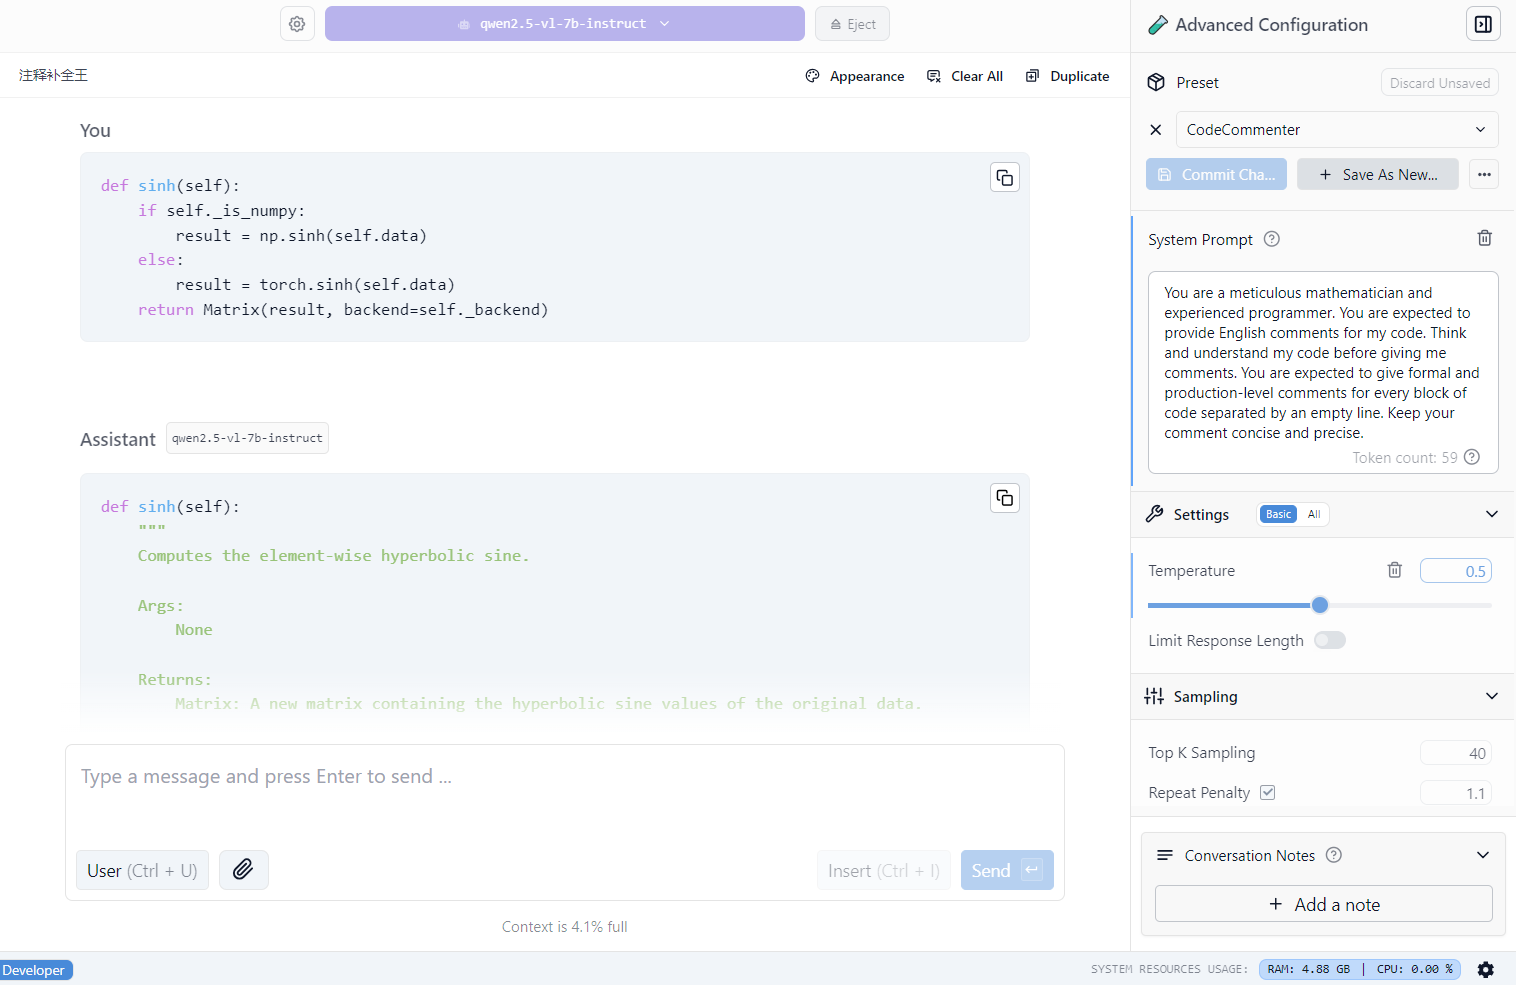

`1.A. Generic Linear Regression Base Models (self-implemented)`

In [14]:
# These linear regression utilities are self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Base Linear Models
class BaseLinearModels(Regression, Classification):
    
    __attr__ = "MML.BaseLinearModels"
    
    def __init__(self, **kwargs):
        
        super().__init__()
          
    def fit(self, **kwargs):
        raise NotImplementedError("Fit is NOT implemented in the base class.")
        
    def predict(self, **kwargs):
        raise NotImplementedError("Predict is NOT implemented in the base class.")    
    
    @staticmethod
    def _make_intercept(X: Matrix | Tensor, fit_intercept: bool = True, /, **kwargs) -> Matrix | Tensor:
        """
        Add an intercept column to the feature matrix if required.
        
        Parameters:
            X: Matrix | Tensor, The input feature data.
            fit_intercept: bool, If true a constant term is added to the predictors by appending a column of ones. Default to True.
        
        Returns:
            Matrix or Tensor: The modified matrix with an intercept column if required.
        
        """
        if fit_intercept == True:
            one_shape = [X.shape[0], 1]
            ones_like = type(X).ones(one_shape, backend = X._backend).to(backend = X._backend, device = X.device, dtype = X.dtype)
            return ones_like.hstack(X)
        else:
            return X.copy()
    
    @staticmethod
    def _log_likelihood_gaussian(**kwargs):
        """
        Gaussian log‐likelihood with dispersion = σ². Sinve error terms follows centered gaussian.
        
        Parameters:
            -------
            y_true: Matrix | Tensor, of the true values, with shape [n_samples, n_outputs]
            y_pred: Matrix | Tensor, of the predicted values, with shape [n_samples, n_outputs]
            
            
        Returns:
            -------
            Matrix | Tensor, loglikelihood measure.
        """
        try:
            # dispersion = kwargs["dispersion"]
            y_true = kwargs["y_true"]
            y_pred = kwargs["y_pred"]
        except KeyError as e:
            raise e
            
        n = y_true.shape[0]
        resid = y_true - y_pred
        sigma2 = (resid ** 2).sum() / n
        return -(n / 2.0) * ((2.0 * math.pi * sigma2).log() + 1.0)

    @staticmethod
    def _log_likelihood_inverse_gaussian(**kwargs):
        """
        Inverse‐Gaussian log‐likelihood (mean=μ, shape=λ) with dispersion = λ > 0
        
        Parameters:
            -------
            dispersion: Matrix | Tensor of scalar, dispersion measurement, which is λ.
            y_true: Matrix | Tensor, of the true values, with shape [n_samples, n_outputs]
            y_pred: Matrix | Tensor, of the predicted values, with shape [n_samples, n_outputs]
            
        Returns:
            -------
            Matrix | Tensor, loglikelihood measure.
        """
        try:
            dispersion = kwargs["dispersion"]
            y_true = kwargs["y_true"]
            y_pred = kwargs["y_pred"]
        except KeyError as e:
            raise e
        
        term1 = 0.5 * (dispersion / (2.0 * math.pi * (y_true ** 3))).log()
        term2 = -dispersion * ((y_true - y_pred) ** 2) / (2.0 * (y_pred ** 2) * y_true)
        return (term1 + term2).sum()

    @staticmethod
    def _log_likelihood_logistic(**kwargs):
        """
        Bernoulli log‐likelihood for binary y ∈ {0,1},
        
        Parameters:
            -------
            y_true: Matrix | Tensor, of the true values, with shape [n_samples, n_outputs]
            y_pred: Matrix | Tensor, of the predicted values, with shape [n_samples, n_outputs]
            * Note. All of the `y`s above should be post-logistic function (after called sigmoid).
            
        Returns:
            -------
            Matrix | Tensor, loglikelihood measure.
        """
        try:
            y_true = kwargs["y_true"]
            y_pred = kwargs["y_pred"]
        except KeyError as e:
            raise e
        
        term1 = y_true * y_pred.clip(1e-15).log()
        term2 = (1.0 - y_true) * (1.0 - y_pred).clip(1e-15).log()
        return (term1 + term2).sum()
    
    @staticmethod
    def _log_likelihood_poisson(**kwargs):
        """
        Poisson log‐likelihood for Poisson(λ).
        
        Parameters:
            -------
            y_true: Matrix | Tensor, of the true values, with shape [n_samples, n_outputs]
            y_pred: Matrix | Tensor, of the predicted values, with shape [n_samples, n_outputs]
            
        Returns:
            -------
            Matrix | Tensor, loglikelihood measure.
        """
        try:
            y_true = kwargs["y_true"]
            y_pred = kwargs["y_pred"]
        except KeyError as e:
            raise e
        
        term1 = y_true * y_pred.log()     # y_i * log(λ_i)
        term2 = -y_pred                   # −λ_i
        term3 = -(y_true + 1.0).loggamma()# −log(Γ(y_i+1))
        return (term1 + term2 + term3).sum()
    
    @staticmethod
    def _log_likelihood_gamma(**kwargs):
        """
        Gamma log‐likelihood (shape = α, scale = μ/α) with dispersion = α > 0
        
        Parameters:
            -------
            dispersion: Matrix | Tensor of scalar, dispersion measurement, which is α.
            y_true: Matrix | Tensor, of the true values, with shape [n_samples, n_outputs]
            y_pred: Matrix | Tensor, of the predicted values, with shape [n_samples, n_outputs]

        Returns:
            -------
            Matrix | Tensor, loglikelihood measure.
        """
        try:
            dispersion = kwargs["dispersion"]
            y_true = kwargs["y_true"]
            y_pred = kwargs["y_pred"]
        except KeyError as e:
            raise e
        
        beta     = y_pred / dispersion          # scale = μ/α
        term1 = -dispersion * beta.log()        # -α·log(β)
        term2 = -(dispersion).loggamma()        # –log(Γ(α))
        term3 = (dispersion - 1.0) * y_true.log()  # (α–1)·log(y)
        term4 = - y_true / beta                    # –y/β
        return (term1 + term2 + term3 + term4).sum()

    def __repr__(self):
        return "BaseLinearModels(Abstract Class)."
  
    
# Base Linear Single Value Regression Models
class BaseSingleValueLinearRegression(BaseLinearModels):

    __attr__ = "MML.BaseSingleValueLinearRegression"

    def __init__(self, family: str = "gaussian", fit_intercept: bool = True, **kwargs) -> None:
        """
        Initialize a Base Single Value Linear Regression model.
        
        Parameters:
            family: str, the estimation family. Can be {"gaussian", "logistic", "inverse_gaussian", "gamma", "poisson"}
            fit_intercept: bool, if True, the intercept is learned during fitting. Default to True.
        
        """
        
        super().__init__()
        
        # Linear Regression Family.
        self.family = family
        
        # Dispersion Measure (for loglikelihood in GLM)
        self.dispersion = None  # Will be used by children
        
        # Basic components used in linear regressions.
        self.fit_intercept = fit_intercept  # boolean
        self.coefs = None                   # shape (n_features + 1 if True, 1), with intercept
        # shape[1] = 1
        # [Alpha_0,]
        # [Beta1_0,]
        # [Beta2_0,]
        # [...]
        self.betas = None                   # shape (n_features, 1), without intercept
        # shape[1] = 1
        # [Beta1_0,]
        # [Beta2_0,]
        # [...]
        self.intercept = None               # shape (1, )
        # shape[1] = 1
        # [Alpha_0,]
        
        # Copy the data used to train
        self.original_X = None              # shape (n_samples, n_features)
        self.original_y = None              # shape (n_samples, 1)
        self.intercepted_X = None           # shape (n_samples, 1 + n_features)

    def _check_is_fit(self, throw_if_not: bool = True) -> None | bool:
        """
        Check whether the model has been fitted.

        Parameters:
            throw_if_not (bool): If True and the model is not fitted, raise a RuntimeError. 
                                            If False, return a boolean indicating whether the model is fitted or not.
        
        Returns:
            None or bool: None if `throw_if_not` is True, otherwise returns a Boolean indicating whether the model is fitted.

        Raises:
            RuntimeError: If `throw_if_not` is True and the model has not been fitted.
        """
        if self.coefs is None:
            if throw_if_not:
                raise RuntimeError("Model not fitted. Call `.fit()` before using the estimator.")
            else:
                return False
        else:
            if throw_if_not:
                return None
            else:
                return True

    def _set_params(self, coefficients: Matrix | Tensor) -> None:
        """
        Set the parameters for the base single linear regression model.
        
        Parameters:
            coefficients: Matrix or Tensor, The coefficient matrix to be used in fitting.
        
        Raises:
            ValueError: If `coefficients` is not a 2D data with reshape([-1, 1]).
        
        Returns:
            None
        """
        if len(coefficients.shape) != 2:
            raise ValueError("The `coefficients` must also be a 2d data with reshape([-1, 1])")
                    
        if self.fit_intercept:
            self.coefs = coefficients.copy()
            self.intercept, self.betas = coefficients[0], coefficients[1:]
        else:
            self.coefs = coefficients.copy()
            self.intercept, self.betas = None, coefficients.copy()
        return None

    def _fit_prep(self, X: Matrix | Tensor, y: Matrix | Tensor, **kwargs) -> None:
        """
        Helper function for fit() the linear regression model on training data.
        .1 Do type checks
        .2 Do data copies
        .3 Do data extensions (including a column of ones)
         
        Parameters:
            X: X: Matrix | Tensor, the input features, must in 2D.
            y: X: Matrix | Tensor, the target values, must in 2D (shape [-1,1]).
        
         Raises:
            ValueError: If `X` and `y` are not of type Matrix or Tensor.
            ValueError: If either `X` or `y` is not a 2D array-like.
         """       
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one value per sample, use data.reshape([-1, 1])")
        if y.shape[1] != 1:
            raise ValueError("Input target `y` must also be a 2d data but with only 1 column since it is a single-value linear model. Consider the multi-value one if having more to fit.")
                             
            
        # Copy Training data
        self.original_X = X.to(backend=X._backend, dtype = X.dtype, device=X.device)
        self.original_y = y.to(backend=y._backend, dtype = y.dtype, device=y.device)
        
        # Extend the data
        self.intercepted_X = self._make_intercept(X, self.fit_intercept)

    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor, **kwargs):
        """
        Fit the linear regression model on training data.
        
        Parameters:
            X: Matrix or Tensor, the input features, must be a 2D array-like.
            y: Matrix or Tensor, the target values, must also be a 2D array-like (shape [-1,1]).
        
        Raises:
            NotImplementedError: If the fit method is not implemented in this class.
        
        """
        
        # Call prep to prepare the data
        self._fit_prep(X, y)
        
        # You have to implement a specific algorithm to train the model.
        raise NotImplementedError("Fit is NOT implemented in the base single value linear regression class.")
        
    def predict(self, X: Matrix | Tensor, *, post: Any | None = None, **kwargs) -> Matrix | Tensor:
        """
        Predict the target values using the linear model for given input features.
        
        Parameters:
            X: Matrix or Tensor, The input feature data.
            Optional:
                post: Any | None, None, or callable to be applied after doing the matrix multiplication.
        
        Returns:
            Matrix or Tensor: The predicted output in 2D array ([n_samples, 1]).
        
        Raises:
            ValueError: If model is not fitted. Call `fit()` before using predict method.
            ValueError: If `post` is given but not callable.
        """
        # This simply do a (1 + X) @ coefs
        # The output will be a [-1, 1] shaped array (single value regression).
        
        # Check if fitted
        self._check_is_fit()
        
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False:
            raise ValueError("Input feature `X` must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(self.original_X):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if X.shape[1] != self.original_X.shape[1]:
            raise ValueError(f"Input feature `X` must have the same second dimension as the training features. Trained {self.original_X.shape}, but you have {X.shape} instead.")
        
        # Process based on if you have intercept or not
        X_news = self._make_intercept(X, self.fit_intercept)
        y_pred = X_news @ self.coefs
        
        # Do post-process or not
        if post is None:
            return y_pred
        else:
            if callable(post) == False:
                raise ValueError("If you choose to apply a post function, then `post` argument must be a callable object and takes Matrix or Tensor as the input, as well as the output.")
            else:
                return post(y_pred)
            
    def _log_likelihood(self, **kwargs) -> Matrix | Tensor:
        """
        Calculate the log-likelihood under Gaussian/Any specified noise at the fitted MLE.

        Parameters:
            None (other parameters are passed via `**kwargs` for compatibility).

        Raises:
            ValueError: If not all required fields have been set or if the model is not fitted.
        
        Returns:
            Matrix | Tensor: Log-likelihood value of the model under Gaussian noise.
            
        """
        
        # Check if fitted
        self._check_is_fit()

        # Calculate the prediction for the given X
        y_pred = self.predict(self.original_X)
        
        # Call the internal loglikelihood based on family
        family = self.family.lower()
        if family == "gaussian":
            return self._log_likelihood_gaussian(dispersion = self.dispersion, y_true = self.original_y, y_pred = y_pred)
        elif family == "inverse_gaussian":
            return self._log_likelihood(dispersion = self.dispersion, y_true = self.original_y, y_pred = y_pred)
        elif family == "logistic":
            return self._log_likelihood_logistic(dispersion = self.dispersion, y_true = self.original_y, y_pred = y_pred)
        elif family == "gamma":
            return self._log_likelihood_gamma(dispersion = self.dispersion, y_true = self.original_y, y_pred = y_pred)
        elif family == "poisson":
            return self._log_likelihood_poisson(dispersion = self.dispersion, y_true = self.original_y, y_pred = y_pred)
        else:
            return ValueError(f'Unknown family. It should be one of ["gaussian", "logistic", "inverse_gaussian", "gamma", "poisson"] but you have {family}.')

    def aic(self, **kwargs) -> Matrix | Tensor:
        """
        Calculate the Akaike Information Criterion (AIC).

        Parameters:
            None (other parameters are passed via `**kwargs` for compatibility).
        
        Returns:
            Matrix or Tensor: The AIC value of the model.
            
        """
        # Akaike Information Criterion:
        # AIC = 2*k - 2*loglik
        # where k = (number of features + intercept if any) + 1 for σ²
        n = self.original_X.shape[0]
        p = self.coefs.shape[0]
        k = p + 1  # include σ²
        ll = self._log_likelihood()
        return 2 * k - 2 * ll
    
    def bic(self, **kwargs) -> Matrix | Tensor:
        """
        Calculate the Bayesian Information Criterion (BIC).
        
        Parameters:
            None (other parameters are passed via `**kwargs` for compatibility).
        
        Returns:
            Matrix or Tensor: The BIC value of the model.
            
        """
        # Bayesian Information Criterion:
        # BIC = ln(n)*k - 2*loglik
        n = self.original_X.shape[0]
        p = self.coefs.shape[0]
        k = p + 1  # include σ²
        ll = self._log_likelihood()
        return type(self.original_X)(n, backend=ll._backend, device=ll.device, dtype=ll.dtype).log() * k - 2 * ll

    def metrics_r2(self, X: Matrix | Tensor, y: Matrix | Tensor, **kwargs) -> Matrix | Tensor:
        """
        Calculate R-squared (R^2) value for the single value linear regression model.

        Parameters:
            X: Matrix or Tensor, The input features.
            y: Matrix or Tensor, The target values.
        
        Raises:
            ValueError: If `X` and `y` are not of type Matrix or Tensor.
            ValueError: If either `X` or `y` is not a 2D array-like.
        
        Returns:
            Matrix or Tensor: R-squared (R²) value for the model.
        """
        
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one value per sample, use data.reshape([-1, 1])")
                    
        # Check if fitted
        self._check_is_fit()
        
        # Calculate the prediction for the given X
        y_pred = self.predict(X)
        
        # Calculate the metrics
        return RegressionMetrics(y_pred, y, metric_type = "r2").compute()

    def metrics_r2_adjusted(self, X: Matrix | Tensor, y: Matrix | Tensor, **kwargs) -> Matrix | Tensor:
        """
        Calculate Adjusted R-squared (Adj R^2) value for the single value linear regression model.

        Parameters:
            X: Matrix or Tensor, The input features.
            y: Matrix or Tensor, The target values.
        
        Raises:
            ValueError: If `X` and `y` are not of type Matrix or Tensor.
            ValueError: If either `X` or `y` is not a 2D array-like.
        
        Returns:
            Matrix or Tensor: R-squared (R²) value for the model.
        """
        
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one value per sample, use data.reshape([-1, 1])")
                    
        # Check if fitted
        self._check_is_fit()
        
        # Calculate the prediction for the given X
        y_pred = self.predict(X)
        
        # Calculate the metrics
        return RegressionMetrics(y_pred, y, metric_type = "adjusted r2", k = self.betas.shape[0]).compute()

    def summary(self, **kwargs) -> str:
        """
        Return a formatted string summary table with:
          - N            : number of samples
          - k            : number of predictors
          - Intercept    : the fitted intercept
          - Betas        : list of fitted coefficients
          - AIC          : Akaike Information Criterion
          - BIC          : Bayesian Information Criterion
          - R²           : coefficient of determination
          - Adj R²       : adjusted R²
    
        All floating‐point numbers are rounded or shown in scientific notation
        with up to 6 significant digits.
        
        Returns:
            -------
            str: the returned summary table.
        """
        # ensure the model has been fitted
        self._check_is_fit()
    
        # Gather statistics using the methods to compute.
        N = self.original_X.shape[0]
        k = self.betas.shape[0]
        intercept = float(self.intercept.to_list()[0])
        betas = self.betas.flatten().to_list()
        # format each beta with up to 6 significant digits.
        betas_strs = ["{:.6g}".format(b) for b in betas]
        betas_repr =  ", ".join(betas_strs)
        # Metrics values
        aic_val = float(self.aic().to_list())
        bic_val = float(self.bic().to_list())
        r2_val = float(self.metrics_r2(self.original_X, self.original_y).to_list())
        adj_r2_val = float(self.metrics_r2_adjusted(self.original_X, self.original_y).to_list())
    
        # Prepare rows of the summary table.
        rows = [
            ("N",          str(N)),
            ("k",          str(k)),
            ("Intercept",  "{:.6g}".format(intercept)),
            ("Betas",      betas_repr),
            ("AIC",        "{:.6g}".format(aic_val)),
            ("BIC",        "{:.6g}".format(bic_val)),
            ("R\u00b2",    "{:.6g}".format(r2_val)),
            ("Adj R\u00b2", "{:.6g}".format(adj_r2_val)),
        ]
    
        # Compute column widths (+2 for padding).
        param_col_w = max(len("Parameter"), *(len(p) for p, _ in rows)) + 2
        value_col_w = max(len("Value"), *(len(v) for _, v in rows)) + 2
    
        # Build table lines.
        sep = "+" + "-" * param_col_w + "+" + "-" * value_col_w + "+"
        header = (
            "| "
            + "Parameter".ljust(param_col_w - 2)
            + " | "
            + "Value".ljust(value_col_w - 2)
            + " |"
        )
    
        lines = [sep, header, sep]
        for p, v in rows:
            line = (
                "| "
                + p.ljust(param_col_w - 2)
                + " | "
                + v.ljust(value_col_w - 2)
                + " |"
            )
            lines.append(line)
        lines.append(sep)

        return "Model Summary: " + self.__attr__  + " (family " + self.family + ")\n" + "\n".join(lines)

    def __repr__(self):
        return "BaseSingleValueLinearRegression(Abstract Class)."


# Base Linear Multi Value Regression Models
class BaseMultiValueLinearRegression(BaseLinearModels):

    __attr__ = "MML.BaseMultiValueLinearRegression"

    def __init__(self, family: str = "gaussian", fit_intercept: bool = True, n_outputs: int = 1, **kwargs) -> None:
        """
        Initialize a Base Multi Value Linear Regression model.
        
        Parameters:
            family: str, the estimation family. Can be {"gaussian", "logistic", "inverse_gaussian", "gamma", "poisson"}
            fit_intercept: bool, if True, the intercept is learned during fitting. Default to True.
            n_outputs: int, the number of output values (greater than 1 to be multi-values). Default 1.
        
        """
        
        super().__init__()
        
        # Multi output dimensions
        if isinstance(n_outputs, int) == False:
            raise ValueError("Parameter n_outputs represents the dimension of your target. Must be a positive int.")
        if n_outputs < 1:
            raise ValueError("Parameter n_outputs represents the dimension of your target. Must be a positive int.")
        self.n_outputs = n_outputs
        
        # Linear Regression Family.
        self.family = family
        
        # Dispersion Measure (for loglikelihood in GLM)
        self.dispersion = None  # Will be used by children
        
        # Basic components used in linear regressions.
        self.fit_intercept = fit_intercept  # boolean
        self.coefs = None                   # shape (n_features + 1 if True, n_outputs), with intercept
        #  number of outputs ->
        # [Alpha_0, Alpha_1, ...]
        # [Beta1_0, Beta1_1, ...]
        # [Beta2_0, Beta2_1, ...]
        # [...]
        self.betas = None                   # shape (n_features, n_outputs), without intercept
        #  number of outputs ->
        # [Beta1_0, Beta1_1, ...]
        # [Beta2_0, Beta2_1, ...]
        # [...]
        self.intercept = None               # shape (n_outputs, )
        #  number of outputs ->
        # [Alpha_0, Alpha_1, ...]

        # Copy the data used to train
        self.original_X = None              # shape (n_samples, n_features)
        self.original_y = None              # shape (n_samples, n_outputs)
        self.intercepted_X = None           # shape (n_samples, 1 + n_features)

    def _check_is_fit(self, throw_if_not: bool = True) -> None | bool:
        """
        Check whether the model has been fitted.

        Parameters:
            throw_if_not (bool): If True and the model is not fitted, raise a RuntimeError. 
                                            If False, return a boolean indicating whether the model is fitted or not.
        
        Returns:
            None or bool: None if `throw_if_not` is True, otherwise returns a Boolean indicating whether the model is fitted.

        Raises:
            RuntimeError: If `throw_if_not` is True and the model has not been fitted.
        """
        if self.coefs is None:
            if throw_if_not:
                raise RuntimeError("Model not fitted. Call `.fit()` before using the estimator.")
            else:
                return False
        else:
            if throw_if_not:
                return None
            else:
                return True

    def _set_params(self, coefficients: Matrix | Tensor) -> None:
        """
        Set the parameters for the base multi linear regression model.
        
        Parameters:
            coefficients: Matrix or Tensor, The coefficient matrix to be used in fitting.
        
        Raises:
            ValueError: If `coefficients` is not a 2D data with reshape([n_features + 1 if intercept, n_outputs]).
        
        Returns:
            None
        """
        #  number of outputs ->
        # [Alpha_0, Alpha_1, ...]
        # [Beta1_0, Beta1_1, ...]
        # [Beta2_0, Beta2_1, ...]
        # [...]        
        if len(coefficients.shape) != 2:
            raise ValueError("The `coefficients` must also be a 2d data with reshape([-1, 1])")
                    
        if self.fit_intercept:
            self.coefs = coefficients.copy()
            self.intercept, self.betas = coefficients[0], coefficients[1:]
        else:
            self.coefs = coefficients.copy()
            self.intercept, self.betas = None, coefficients.copy()
        return None

    def _fit_prep(self, X: Matrix | Tensor, y: Matrix | Tensor, **kwargs) -> None:
        """
        Helper function for fit() the linear regression model on training data.
        .1 Do type checks
        .2 Do data copies
        .3 Do data extensions (including a column of ones)
         
        Parameters:
            X: X: Matrix | Tensor, the input features, must in 2D.
            y: X: Matrix | Tensor, the target values, must in 2D (shape [n_samples, n_outputs]).
        
         Raises:
            ValueError: If `X` and `y` are not of type Matrix or Tensor.
            ValueError: If either `X` or `y` is not a 2D array-like.
            ValueError: If the second shape of `y` does NOT equal to n_outputs.
         """
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one value per sample, use data.reshape([-1, 1])")
        if y.shape[1] != self.n_outputs:
            raise ValueError(f"Input target `y` must have {self.n_outputs} outputs per sample, as indicated by the constructor parameter.")
            
        # Copy Training data
        self.original_X = X.to(backend=X._backend, dtype = X.dtype, device=X.device)
        self.original_y = y.to(backend=y._backend, dtype = y.dtype, device=y.device)
        
        # Extend the data
        self.intercepted_X = self._make_intercept(X, self.fit_intercept)

    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor, **kwargs):
        """
        Fit the linear regression model on training data.
        
        Parameters:
            X: Matrix or Tensor, the input features, must be a 2D array-like.
            y: Matrix or Tensor, the target values, must also be a 2D array-like (shape [-1,1]).
        
        Raises:
            NotImplementedError: If the fit method is not implemented in this class.
        
        """
        
        # Call prep to prepare the data
        self._fit_prep(X, y)
        
        # You have to implement a specific algorithm to train the model.
        raise NotImplementedError("Fit is NOT implemented in the base multiple value linear regression class.")
        
    def predict(self, X: Matrix | Tensor, *, post: Any | None = None, **kwargs) -> Matrix | Tensor:
        """
        Predict the target values using the linear model for given input features.
        
        Parameters:
            X: Matrix or Tensor, The input feature data.
            Optional:
                post: Any | None, None, or callable to be applied after doing the matrix multiplication.
        
        Returns:
            Matrix or Tensor: The predicted output in 2D array ([n_samples, n_outputs]).
        
        Raises:
            ValueError: If model is not fitted. Call `fit()` before using predict method.
            ValueError: If `post` is given but not callable.
        """
        # This simply do a (1 + X) @ coefs
        # The output will be a [-1, n_outputs] shaped array (multi value regression).
        
        # Check if fitted
        self._check_is_fit()
        
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False:
            raise ValueError("Input feature `X` must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(self.original_X):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if X.shape[1] != self.original_X.shape[1]:
            raise ValueError(f"Input feature `X` must have the same second dimension as the training features. Trained {self.original_X.shape}, but you have {X.shape} instead.")
        
        # Process based on if you have intercept or not
        X_news = self._make_intercept(X, self.fit_intercept)
        y_pred = X_news @ self.coefs
        
        # Do post-process or not
        if post is None:
            return y_pred
        else:
            if callable(post) == False:
                raise ValueError("If you choose to apply a post function, then `post` argument must be a callable object and takes Matrix or Tensor as the input, as well as the output.")
            else:
                return post(y_pred)

    def _log_likelihood(self, **kwargs) -> Matrix | Tensor:
        """
        Calculate the log-likelihood under Gaussian/Any specified noise at the fitted MLE.

        Parameters:
            None (other parameters are passed via `**kwargs` for compatibility).

        Raises:
            ValueError: If not all required fields have been set or if the model is not fitted.
        
        Returns:
            Matrix | Tensor: Log-likelihood value of the model under Gaussian noise.
            
        """
        
        # Check if fitted
        self._check_is_fit()

        # Calculate the prediction for the given X
        y_pred = self.predict(self.original_X)
        
        # Call the internal loglikelihood based on family
        family = self.family.lower()
        if family == "gaussian":
            return self._log_likelihood_gaussian(dispersion = self.dispersion, y_true = self.original_y, y_pred = y_pred)
        elif family == "inverse_gaussian":
            return self._log_likelihood(dispersion = self.dispersion, y_true = self.original_y, y_pred = y_pred)
        elif family == "logistic":
            return self._log_likelihood_logistic(dispersion = self.dispersion, y_true = self.original_y, y_pred = y_pred)
        elif family == "gamma":
            return self._log_likelihood_gamma(dispersion = self.dispersion, y_true = self.original_y, y_pred = y_pred)
        elif family == "poisson":
            return self._log_likelihood_poisson(dispersion = self.dispersion, y_true = self.original_y, y_pred = y_pred)
        else:
            return ValueError(f'Unknown family. It should be one of ["gaussian", "logistic", "inverse_gaussian", "gamma", "poisson"] but you have {family}.')

    def aic(self, **kwargs) -> Matrix | Tensor:
        """
        Calculate the Akaike Information Criterion (AIC).

        Parameters:
            None (other parameters are passed via `**kwargs` for compatibility).
        
        Returns:
            Matrix or Tensor: The AIC value of the model.
            
        """
        # Akaike Information Criterion:
        # AIC = 2*k - 2*loglik
        # where k = (number of features + intercept if any) + 1 for σ²
        n = self.original_X.shape[0]
        p = self.coefs.shape[0]
        k = p + 1  # include σ²
        ll = self._log_likelihood()
        return 2 * k - 2 * ll
    
    def bic(self, **kwargs) -> Matrix | Tensor:
        """
        Calculate the Bayesian Information Criterion (BIC).
        
        Parameters:
            None (other parameters are passed via `**kwargs` for compatibility).
        
        Returns:
            Matrix or Tensor: The BIC value of the model.
            
        """
        # Bayesian Information Criterion:
        # BIC = ln(n)*k - 2*loglik
        n = self.original_X.shape[0]
        p = self.coefs.shape[0]
        k = p + 1  # include σ²
        ll = self._log_likelihood()
        return type(self.original_X)(n, backend=ll._backend, device=ll.device, dtype=ll.dtype).log() * k - 2 * ll

    def metrics_r2(self, X: Matrix | Tensor, y: Matrix | Tensor, **kwargs) -> Matrix | Tensor:
        """
        Calculate R-squared (R^2) value for the single value linear regression model.

        Parameters:
            X: Matrix or Tensor, The input features.
            y: Matrix or Tensor, The target values.
        
        Raises:
            ValueError: If `X` and `y` are not of type Matrix or Tensor.
            ValueError: If either `X` or `y` is not a 2D array-like.
        
        Returns:
            Matrix or Tensor: R-squared (R²) value for the model.
        """
        
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one value per sample, use data.reshape([-1, 1])")
                    
        # Check if fitted
        self._check_is_fit()
        
        # Calculate the prediction for the given X
        y_pred = self.predict(X)
        
        # Calculate the metrics
        return RegressionMetrics(y_pred, y, metric_type = "r2").compute()

    def metrics_r2_adjusted(self, X: Matrix | Tensor, y: Matrix | Tensor, **kwargs) -> Matrix | Tensor:
        """
        Calculate Adjusted R-squared (Adj R^2) value for the single value linear regression model.

        Parameters:
            X: Matrix or Tensor, The input features.
            y: Matrix or Tensor, The target values.
        
        Raises:
            ValueError: If `X` and `y` are not of type Matrix or Tensor.
            ValueError: If either `X` or `y` is not a 2D array-like.
        
        Returns:
            Matrix or Tensor: R-squared (R²) value for the model.
        """
        
        # Type Check (must be an Object type).
        if isinstance(X, Object) == False or isinstance(y, Object) == False:
            raise ValueError("Input dataset must be either Matrix and Tensor. Use Matrix(data) or Tensor(data) to convert.")
        if type(X) != type(y):
            raise ValueError("Input feature `X` and target `y` must have the same type, either Matrix or Tensor.")
        
        # Dimension Check
        if len(X.shape) != 2:
            raise ValueError("Input feature `X` must be a tabular data with two dimensions.")
        if len(y.shape) == 1:
            raise ValueError("Input target `y` must also be a 2d data. If only one value per sample, use data.reshape([-1, 1])")
                    
        # Check if fitted
        self._check_is_fit()
        
        # Calculate the prediction for the given X
        y_pred = self.predict(X)
        
        # Calculate the metrics
        return RegressionMetrics(y_pred, y, metric_type = "adjusted r2", k = self.betas.shape[0]).compute()

    def summary(self, **kwargs) -> str:
        """
        Return a formatted string summary table with:
          - N            : number of samples
          - k            : number of predictors
          - outputs      : number of outputs
          - Intercept    : the fitted intercept
          - Betas        : list of fitted coefficients
          - AIC          : Akaike Information Criterion
          - BIC          : Bayesian Information Criterion
          - R²           : coefficient of determination
          - Adj R²       : adjusted R²
    
        All floating‐point numbers are rounded or shown in scientific notation
        with up to 6 significant digits.
        
        Returns:
            -------
            str: the returned summary table.
        """
        # ensure the model has been fitted
        self._check_is_fit()
    
        # Gather statistics using the methods to compute.
        N = self.original_X.shape[0]
        k = self.betas.shape[0]
        outputs = self.n_outputs
        intercepts = self.intercept.flatten().to_list()
        betas = self.betas.transpose().to_list()
        # format each beta with up to 6 significant digits.
        intercept_strs = ["{:.6g}".format(b) for b in intercepts]
        betas_strs = [["{:.6g}".format(b) for b in bs] for bs in betas]
        betas_repr =  ""
        for i, bs in enumerate(betas_strs):
            betas_repr += (", ".join(betas_strs[i])) + "; "
        intercept_repr = ", ".join(intercept_strs)
        # Metrics values
        aic_val = float(self.aic().to_list())
        bic_val = float(self.bic().to_list())
        r2_val = float(self.metrics_r2(self.original_X, self.original_y).to_list())
        adj_r2_val = float(self.metrics_r2_adjusted(self.original_X, self.original_y).to_list())
    
        # Prepare rows of the summary table.
        rows = [
            ("N",          str(N)),
            ("k",          str(k)),
            ("outputs",    str(outputs)),
            ("Intercept",  intercept_repr),
            ("Betas",      betas_repr),
            ("AIC",        "{:.6g}".format(aic_val)),
            ("BIC",        "{:.6g}".format(bic_val)),
            ("R\u00b2",    "{:.6g}".format(r2_val)),
            ("Adj R\u00b2", "{:.6g}".format(adj_r2_val)),
        ]
    
        # Compute column widths (+2 for padding).
        param_col_w = max(len("Parameter"), *(len(p) for p, _ in rows)) + 2
        value_col_w = max(len("Value"), *(len(v) for _, v in rows)) + 2
    
        # Build table lines.
        sep = "+" + "-" * param_col_w + "+" + "-" * value_col_w + "+"
        header = (
               "| "
            + "Parameter".ljust(param_col_w - 2)
            + " | "
            + "Value".ljust(value_col_w - 2)
            + " |"
        )
    
        lines = [sep, header, sep]
        for p, v in rows:
            line = (
                   "| "
                + p.ljust(param_col_w - 2)
                + " | "
                + v.ljust(value_col_w - 2)
                + " |"
            )
            lines.append(line)
        lines.append(sep)

        return "Model Summary: " + self.__attr__  + " (family " + self.family + ")\n" + "\n".join(lines)

    def __repr__(self):
        return "BaseMultiValueLinearRegression(Abstract Class)."


# Closed Form Single Value Regression
class ClosedFormSingleValueRegression(BaseSingleValueLinearRegression):
    
    __attr__ = "MML.ClosedFormSingleValueRegression"

    def __init__(self, family: str = "gaussian", fit_intercept: bool = True,
                 cov: Matrix | Tensor | None = None, **kwargs) -> None:
        """
        Initialize a Closed Form Single Value Linear Regression model.
        The family must be `gaussian` or raised with a value error.
         
        Parameters:
            family: str, the estimation family. Must be `gaussian`. Or, consider Gradient Descend Implementations.
            fit_intercept: bool, if True, the intercept is learned during fitting. Default to True.
            cov: Matrix | Tensor | None
                 Error-term covariance matrix Σ (shape m×m, m = n_samples), or just the variance,
                 Provide for GLS; leave None for OLS.
        
        """
        
        super().__init__(family=family, fit_intercept=fit_intercept, **kwargs)
        
        # Record the covariance matrix if provided
        self.cov = cov.copy() if cov is not None else None
        
        # family check. In closed form version. 
        if self.family != "gaussian":
            raise ValueError("In Closed Form Single Value Linear Regression, you must set `family` to `gaussian`. Or you should attempt to use GradientDescendSingleValueRegression instead.")

    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor, **kwargs):
        """
        Fit the linear regression model on training data.
        
        Parameters:
            X: Matrix or Tensor, the input features, must be a 2D array-like.
            y: Matrix or Tensor, the target values, must also be a 2D array-like (shape [-1,1]).
            
        Returns:
            -------
            self
        """
        
        # Call prep to prepare the data.
        self._fit_prep(X, y)
        
        # Solve it by OLS or GLS with covariance matrix.
        X = self.intercepted_X.copy()
        y = self.original_y.copy()
        n, d = X.shape
        
        # Since single value, we just perform regression on 1 column of y.
        if self.cov is None:
            # OLS:  β̂ = (XᵀX)⁻¹Xᵀy
            Xt = X.transpose()
            XtX = Xt @ X
            XtX_inv = XtX.inverse()
            coefs = XtX_inv @ (Xt @ y)
        else:
            # GLS:  β̂ = (XᵀΣ⁻¹X)⁻¹XᵀΣ⁻¹y
            sigma_inv = self.cov.inverse()
            XtSi = X.transpose() @ sigma_inv
            XtSiX = XtSi @ X
            XtSiX_inv = XtSiX.inverse()
            coefs = XtSiX_inv @ (XtSi @ y)
        
        # Set the parameters with intercept.
        self._set_params(coefs)
        return self

    def predict(self, X: Matrix | Tensor, **kwargs) -> Matrix | Tensor:
        """
        Predict the target values using the linear model for given input features.
        
        Parameters:
            X: Matrix or Tensor, The input feature data.

        Returns:
            Matrix or Tensor: The predicted output in 2D array ([n_samples, 1]).
        
        Raises:
            ValueError: If model is not fitted. Call `fit()` before using predict method.
        """
        return super().predict(X, post = None, **kwargs)

    def __repr__(self):
        try:
            self._check_is_fit()
            return f"ClosedFormSingleValueRegression(N = {self.original_X.shape[0]}, k = {self.original_X.shape[1]}, {'with intercept' if self.fit_intercept == True else 'without intercept'})."
        except:
            return f"ClosedFormSingleValueRegression(Not fitted, {'with intercept' if self.fit_intercept == True else 'without intercept'})."


# Gradient Descend Single Value Regression
class GradientDescendSingleValueRegression(BaseSingleValueLinearRegression):
    
    __attr__ = "MML.GradientDescendSingleValueRegression"

    # Variance Function V(µ)
    __var_function__ =  {
        "gaussian": lambda mu: mu.ones_like(mu),
        "logistic": lambda mu: mu * (1.0 - mu),
        "poisson" : lambda mu: mu,
        "gamma"   : lambda mu: mu ** 2,
        "inverse_gaussian": lambda mu: mu ** 3,
    }
    
    # Mean Response Derivative
    __deriv_mresponse__ = {
        "gaussian": lambda mu: mu.ones_like(mu),
        "logistic": lambda mu: mu * (1.0 - mu),
        "poisson" : lambda mu: mu,
        "gamma"   : lambda mu: mu ** 2 * -1,
        "inverse_gaussian": lambda mu: mu ** 3 * -0.5,
    }
    
    # Inverse Link µ = g⁻¹(η)
    __inv_link__ = {
        "gaussian": lambda eta: eta,
        "logistic": lambda eta: eta.logistic(),
        "poisson" : lambda eta: eta.exp(),
        "gamma":    lambda eta: 1.0 / eta.clip(1e-16),
        "inverse_gaussian": lambda eta: 1.0 / (eta.clip(1e-16) ** 0.5),
    }
    

    def __init__(self, 
                 task: str = "regression",
                 family: str = "gaussian", 
                 fit_intercept: bool = True,
                 cov: Matrix | Tensor | None = None, *,
                 tol: float = 1e-8,
                 lr: float = 1e-2,
                 max_iter: int = 10000,
                 batch_size: int | None = None,
                 shuffle: bool = True,
                 l1: float = 0.0,
                 l2: float = 0.0,
                 random_state: int | None = None,
                 **kwargs) -> None:
        """
        Initialize a Gradient Descend Single Value Linear Regression model.
        You may need to scale the data before passing them in to avoid gradient crash.
         
        Parameters:
            task: str, the task of doing the regression, can be `regression` most of time, or `classification` in `logistic` mode.
            family: str, the estimation family. Can be {"gaussian", "logistic", "gamma", "inverse_gaussian", "poisson"}.
            fit_intercept: bool, if True, the intercept is learned during fitting. Default to True.
            cov: Matrix | Tensor | None
                 Error-term covariance matrix Σ (shape m×m, m = n_samples), or just the variance.
                 Provide for GLS; leave None for OLS.
            tol: float, tolerence for convergence when optimizing.
            lr: float, learning rate. Default 1e-2.
            max_iter: int, maximum number of passes over the data. Default 10000.
            batch_size: int | None, minibatch size (None = full-batch GD).
            shuffle : bool, whether to reshuffle data at each epoch
            l1: float, optional Lasso penalty λ * sign(β) (0 = plain OLS).
            l2: float, optional Ridge penalty λ * ‖beta‖² (0 = plain OLS).
            random_state: int | None, random seed, can be None.
            
        Family Supported:
            +--------------------+---------------------+-------------------------------------------+
            | Name               | Mean–variance       | Inverse‑link g⁻¹(η) = μ                   |
            +====================+=====================+==========================================+
            | "gaussian"         |  V(μ) = 1           |  μ = η                                   |
            | "logistic"         |  μ(1-μ)            |  μ = 1 / (1 + e^{-η})                     |
            | "poisson"          |  μ                 |  μ = exp(η)                               |
            | "gamma"            |  μ²                |  μ = 1 / η                                |
            | "inverse_gaussian" |  μ³                |  μ = 1 / √η                               |
            +--------------------+--------------------+-------------------------------------------+
            
        Special Notes:
            -----
            > The gradient for canonical links reduces to Xᵀ(y − μ)/φ.
            > Dispersion φ (if present) is re-estimated after β using
              σ² = Σᵢ(yᵢ − μᵢ)² / n    (Gaussian)
              α  = Σᵢ((yᵢ − μᵢ)/μᵢ)² / n (Gamma)
              λ  = Σᵢ((yᵢ − μᵢ)/(μᵢ²yᵢ)) / n (Inv-Gaussian)
        """
        
        super().__init__(family=family, fit_intercept=fit_intercept, **kwargs)
        
        # Record the covariance matrix if provided
        self.cov = cov.copy() if cov is not None else None
        
        # Record the task
        self.task = task.lower()
        if self.task not in ("regression", "classification"):
            raise ValueError("Unsupported task. Choose 'regression' or 'classification'.")
        
        # Family check. Must be one of the supported.
        if self.family not in {"gaussian", "logistic", "gamma", "inverse_gaussian", "poisson"}:
            raise ValueError("Parameter `family` must in {'gaussian', 'logistic', 'gamma', 'inverse_gaussian', 'poisson'}")
            
        # Record all gradient method arguments
        self.tol = tol
        self.lr = lr
        self.max_iter = max_iter
        self.have_itered = 0
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Record regularization term
        self.l1 = l1                    # Lasso Regularization term
        self.l2 = l2                    # Ridge Regularization term
        
        # Record the dispersion parameter for GLS with non-Gaussian family
        self.dispersion = None
        
        # Record the random state
        self.random_state = random_state
        
        # Record an optimizer parameter dict (we only support "vanilla" or "adam")
        self.optm_params = {"optimizer" : "adam", # or vanilla
                            "beta1"     : 0.9, 
                            "beta2"     : 0.999,
                            "eps"       : 1e-12,
                            "m"         : None,
                            "v"         : None,
                            "t"         : 0}

    def _estimate_dispersion(self, X: Matrix | Tensor, y: Matrix | Tensor, **kwargs) -> None:
        """
        Estimate the dispersion term for GLS with `gamma` or `inverse_gaussian` family.
        
        Returns:
            -------
            None
        """
        if self.family not in ("gamma", "inverse_gaussian"):
            return
        
        mu = self.predict(X)
        resid = y - mu
        if self.family == "gamma":
            self.dispersion = (resid / mu).var()
        elif self.spec.name == "inverse_gaussian":
            self.dispersion = (resid / (mu ** 2 * y)).mean()
        return

    def _eval_one_batch(self, evalset: Dict[str, Tuple[Matrix | Tensor, Matrix | Tensor]] | None = None, evalmetrics: List[str] | str | None = None, one_hot: bool = False, **kwargs):
        """
        Evaluate the `evalset` after training for one batch.    

        Returns
            -------
            result_dict : dict  # Key: evalset name
                                # Value dict {metric_name: metric_value}
            or 
            {} if failed or did not evaluate
        """
        
        # If:
        # 1. evalset is at least len = 1
        # 2. evalmetrics is non-None and at least len = 1
        # Do evaluation
        result_dict = {}
        if evalmetrics is not None and evalset is not None:
            if len(evalset) > 0 and len(evalmetrics) > 0:
                # Record the result for each eval group
                result_dict = {}    # Key: evalset name
                                    # Value dict {metric_name: metric_value}
                for eval_name in evalset.keys():
                    X_sub, y_sub = evalset[eval_name]
                    y_pred = self.predict(X_sub)
                    
                    # Inner metric dict, for values of result dict
                    metrics = {}
                    for metric_name in evalmetrics:
                        
                        # Evaluation: regression
                        if self.task == "regression":
                            eval_metric = RegressionMetrics(y_pred, y_sub, metric_type = metric_name).compute()
                            # Matrix | Tensor
                        
                        # Evaluation: this is classification
                        else:
                            if (y_pred.shape[1] == 2 and one_hot == False) or y_pred.shape[1] == 1:
                                # Binary and non-one hot
                                eval_metric = BinaryClassificationMetrics(self._to_binary_prob(y_pred), y_sub, metric_type = metric_name).compute()
                            else:
                                # Since the aggregation output is alway one-hot, use Multiple then
                                eval_metric = MultiClassificationMetrics(y_pred, y_sub, metric_type = metric_name).compute()
                            # Matrix | Tensor
                        metrics[metric_name] = eval_metric
                    # For all metrics, put them into result_dict
                    result_dict[eval_name] = metrics
        
        # If it is empty, then exit since nothing valid
        if len(result_dict) == 0:
            return {}
        
        # Else, return the dict
        else:
            return result_dict

    def _backward(self, coefs: Matrix | Tensor, grad: Matrix | Tensor, **kwargs) -> Matrix | Tensor:
        """
        Conduct one-step backward to update the coefs using self.optm_params.

        Parameters
        ----------
            coefs : Matrix | Tensor, previous coefficients
            grad : Matrix | Tensor, gradients calculated

        Returns
        -------
            Matrix | Tensor, new, updated coefs
        """
        if self.optm_params["optimizer"] == "adam":
            if self.optm_params["m"] is None:
                self.optm_params["m"] = coefs.zeros_like(coefs).to(backend = coefs._backend, dtype = coefs.dtype, device = coefs.device)
                self.optm_params["v"] = coefs.zeros_like(coefs).to(backend = coefs._backend, dtype = coefs.dtype, device = coefs.device)
            self.optm_params["t"] = self.optm_params["t"] + 1
            self.optm_params["m"] = self.optm_params["beta1"] * self.optm_params["m"] + (1 - self.optm_params["beta1"]) * grad
            self.optm_params["v"] = self.optm_params["beta2"] * self.optm_params["v"] + (1 - self.optm_params["beta2"]) * (grad ** 2)
            m_hat = self.optm_params["m"] / (1 - self.optm_params["beta1"] ** self.optm_params["t"])
            v_hat = self.optm_params["v"] / (1 - self.optm_params["beta2"] ** self.optm_params["t"])
            return coefs - self.lr * m_hat / (np.sqrt(v_hat) + self.optm_params["eps"])
        elif self.optm_params["optimizer"] == "vanilla":
            return coefs - self.lr * grad
        else:
            raise ValueError("The optimizer for GradientDescendSingleValueRegression can only be `vanilla` or `adam`.")

    def _fit_gaussian(self, X: Matrix | Tensor, y: Matrix | Tensor,
                      *,
                      verbosity: int | None = None,
                      evalset: Dict[str, Tuple[Matrix | Tensor, Matrix | Tensor]] | None = None,
                      evalmetrics: List[str] | str | None = None,
                      early_stop: int | None = None,
                      early_stop_logic: str = "some",
                      continue_to_train: bool | None = None,
                      **kwargs):
        """
        Fit the Gaussian linear regression model WITH/WITHOUT covariance matrix using gradient descend.
        
        Parameters:
            X: Matrix or Tensor, the input features, must be a 2D array-like.
            y: Matrix or Tensor, the target values, must also be a 2D array-like (shape [-1,1]).
            Optional:
                verbosity: int | None, if >= 1 and having `evalset`, then will report metrics each batch.
                evalset: Dict[name : Tuple[X, y],
                              ...], | None, if provided, it may be used as evaluation set. XGBoost style.
                evalmetrics: list of str | str | None, metrics used to do the evaluation. Will be printed.
                early_stop: int | None, if non-None, then if metrics NOT gained for `early_stop` times, the forest will stop training.
                early_stop_logic: str, the logic when deciding on multiple metrics, can be {"any", "some", "most", "all"}.
                continue_to_train: bool | None, if non-None and True, the machine will try to restore the place it was and continue
                                   to train new estimators until a new stopping criterion meets or until reaches the max number of allowed estimators.
                
        
        Returns:
            -------
            self
        """
        
        # Gaussian mode. This fit() providing gaussian result.
        #
        if self.family != "gaussian":
            return self._fit_gls(X, y, verbosity=verbosity, evalset=evalset, evalmetrics=evalmetrics,
                        early_stop=early_stop, early_stop_logic=early_stop_logic,
                        continue_to_train=continue_to_train,
                        **kwargs)
        
        # Try get the val_per_iter
        val_per_iter = kwargs.get("val_per_iter", 50)
       
        # Call prep to prepare the data.
        self._fit_prep(X, y)
        
        # Whiten helper (decorrelate X by cholesky)
        def _whiten(X: Matrix | Tensor, y: Matrix | Tensor, cov: Matrix | Tensor) -> Matrix | Tensor:
            """
            Return (W X, W y) with  WᵀW = Σ⁻¹.  If Σ is None, W = I.
            """
            if cov is None:
                return X.copy(), y.copy()
            
            def _makediag(variance: Matrix | Tensor) -> Matrix | Tensor:
                var = variance.flatten()
                return (1.0 / (var ** 0.5)).diag()
            
            # If cov is only 1 dim or 1 in any dim, regard as variance matrix
            if len(cov.shape) == 1:
                W = _makediag(cov)
            elif len(cov.shape) == 2 and cov.shape[1] == 1:
                W = _makediag(cov.flatten())
            elif len(cov.shape) == 2 and cov.shape[0] == 1:
                W = _makediag(cov.flatten())
            
            # Full covariance case
            else:            
                # Cholesky:  Σ = L Lᵀ  →  Σ⁻¹ = L⁻ᵀ L⁻¹  (so W = L⁻¹)
                L = cov.cholesky()
                W = L.inverse()
                
            if W.shape[0] != X.shape[0]:
                raise ValueError("The given `cov` can either be a variance vector or a covariiance matrix of the error terms, hence n_samples * n_samples. Incorrect dimension!")
        
            # The covariance is the covariance of the error vector, not of the predictors
            # Σ = Cov[ε], y = Xβ + ε,ε∼(0,Σ).
            return W @ X, W @ y
                
        # Prepare values required, like extended X, y, and dimensionals
        X, y = _whiten(self.intercepted_X, y, self.cov)
        n, d = X.shape
        batch_size = n if self.batch_size is None else self.batch_size
        
        # If passed a random state, use it
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        # Create a 1 dimensional coefs (including intercept if any) 
        if continue_to_train == True:
            coefs = self.coefs.copy()
        else:
            # Randomly generate something
            coefs = type(X).rand(d, backend=X._backend, dtype=X.dtype).to(backend=X._backend, dtype=X.dtype, device=X.device)
            # 2 dimensional conversion
            coefs = coefs.reshape([-1, 1])
            
            # No of have_iterated set to 0
            self.have_itered = 0
        
        # Helper: Print and decide the evaluated results
        def _decide_stop_with_print(batch: int, undecreased_no: int, eval_dict: dict, last_eval_dict: dict):
            """
            Compare the metics and decide if

            Parameters
                ----------
                batch: int, batch no, for printing uses.
                undecreased_no : int, cumulative number that loss did NOT decrease before evaluation.
                eval_dict : dict, the passed evaluation dict.

            Returns
                -------
                Tuple of (int, bool):
                    int, updated undecreased_no
                    bool, whether to stop (True) training or continue (False)

            """
            # Dict is empty, abort
            if len(eval_dict) == 0:
                return undecreased_no, False
            if len(last_eval_dict) == 0:
                return undecreased_no, False
            
            # Difference dict copy
            diff_dict = deepcopy(eval_dict)
            
            # Calculate the difference (this - last)
            # and
            # If verbosity, print the new evaluation dict
            undes_count = 0
            allmetric_count = 0
            for evalset_name in eval_dict.keys():
                eval_result = eval_dict[evalset_name]
                if verbosity >= 1:
                    print("Evalset: [", evalset_name, " : Metrics {", end = " ", sep = "")
                for metric_name in eval_result.keys():
                    metric_value = eval_result[metric_name]
                    diff_dict[evalset_name][metric_name] = metric_value - last_eval_dict[evalset_name][metric_name]
                    if diff_dict[evalset_name][metric_name].to_list() > 0:
                        undes_count += 1
                    allmetric_count += 1
                    if verbosity >= 1:
                        print(metric_name, ":", round(metric_value.to_list(), 4), ", ", end = " ", sep = "")
                if verbosity >= 1:
                    print("}]", end = "\n")
                                        
            # If no early stop, directly return 0, False
            if early_stop is None:
                return 0, False
                    
            # If meets the requirement, stop training
            if early_stop_logic == "any":
                if undes_count > 0:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
            elif early_stop_logic == "some":
                if undes_count * 3 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
            elif early_stop_logic == "most":
                if undes_count * 2 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
            elif early_stop_logic == "all":
                if undes_count * 1 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
                    
            # If survives here, return 0, False to refresh the undecreased_no
            return 0, False
        
        undecreased_no = 0
        last_eval_dict = {} # Please use deepcopy() here to avoid being errorly referred
        
        #######################################################################
        #
        # Iterate over the maximum iteration
        for itr in range(self.have_itered, self.max_iter):
            
            # Verbosity
            if verbosity >= 1 and itr % val_per_iter == 0:
                print(f"Training on Round: {itr}.")            
            
            # If shuffle, then re-assign the row indices.
            if self.shuffle:
                idx = np.random.choice(list(range(n)), n, replace = False)
                X_, y_ = X[idx], y[idx].reshape([-1, 1])
            else:
                X_, y_ = X, y
                
            # A list of gradient norms (float)
            grad_norms = []
            
            # Perform a batch-wise gradient update.
            for start in range(0, n, batch_size):
                
                Xb = X_[start : start + batch_size]
                yb = y_[start : start + batch_size]
                nXb = Xb.shape[0]
                
                # MSE Gradient L_λ(b) = ‖y - Xb‖² + λ‖b‖² ​+ λ_1‖b‖
                grad = (2.0 / nXb) * Xb.transpose() @ (Xb @ coefs - yb) + 2 * self.l2 * coefs + self.l1 * coefs.sign()
                # Vectorized gradient for squared‑error + Ridge to prevent singularity Hessian matrix
                
                # Compute the norm of gradient
                grad_norm = (grad ** 2).sum() ** 0.5
                grad_norms.append(grad_norm.to_list())
                
                # Use .backward() to conduct the update of coefs
                coefs = self._backward(coefs, grad)
                
            # If any batch of val_per_iter times, try to evaluate
            if itr % val_per_iter == 0 and itr != 0:
                
                # Preset the parameter for evaluation purpose
                self._set_params(coefs)
                
                # Evaluate and decide
                eval_dict = self._eval_one_batch(evalset = evalset, evalmetrics = evalmetrics)
                
                # Try stop maker and receive the advice
                undecreased_no, decision = _decide_stop_with_print(itr, undecreased_no = undecreased_no, eval_dict = eval_dict, last_eval_dict = last_eval_dict)
                
                # Copy last evaluated dict
                last_eval_dict = deepcopy(eval_dict)
                
                # Make decision to terminate or not
                if decision == True:
                    self._set_params(coefs)
                    self.have_itered = itr + 1
                    self._estimate_dispersion(X, y, **kwargs)
                    return self
                
            # If the average L2 norm of the gradient is lower then tolerance, then stop training
            if np.array(grad_norms).mean() < self.tol:
                self._set_params(coefs)
                self.have_itered = itr + 1
                self._estimate_dispersion(X, y, **kwargs)
                return self
        
        self._set_params(coefs)
        self.have_itered = self.max_iter
        self._estimate_dispersion(X, y, **kwargs)
        return self

    def _fit_gls(self, X: Matrix | Tensor, y: Matrix | Tensor,
                 *,
                 verbosity: int | None = None,
                 evalset: Dict[str, Tuple[Matrix | Tensor, Matrix | Tensor]] | None = None,
                 evalmetrics: List[str] | str | None = None,
                 early_stop: int | None = None,
                 early_stop_logic: str = "some",
                 continue_to_train: bool | None = None,
                 **kwargs):
        """
        Fit a generic linear regression model WITH/WITHOUT covariance matrix using gradient descend.
        
        Parameters:
            X: Matrix or Tensor, the input features, must be a 2D array-like.
            y: Matrix or Tensor, the target values, must also be a 2D array-like (shape [-1,1]).
            Optional:
                verbosity: int | None, if >= 1 and having `evalset`, then will report metrics each batch.
                evalset: Dict[name : Tuple[X, y],
                              ...], | None, if provided, it may be used as evaluation set. XGBoost style.
                evalmetrics: list of str | str | None, metrics used to do the evaluation. Will be printed.
                early_stop: int | None, if non-None, then if metrics NOT gained for `early_stop` times, the forest will stop training.
                early_stop_logic: str, the logic when deciding on multiple metrics, can be {"any", "some", "most", "all"}.
                continue_to_train: bool | None, if non-None and True, the machine will try to restore the place it was and continue
                                   to train new estimators until a new stopping criterion meets or until reaches the max number of allowed estimators.
                
        Returns:
            -------
            self
        """
        
        # Non-Gaussian mode. This fit() providing gaussian result.
        #
        if self.family == "gaussian":
            return self._fit_gaussian(X, y, verbosity=verbosity, evalset=evalset, evalmetrics=evalmetrics,
                       early_stop=early_stop, early_stop_logic=early_stop_logic,
                       continue_to_train=continue_to_train,
                       **kwargs)
        
        # Try get the val_per_iter
        val_per_iter = kwargs.get("val_per_iter", 50)
       
        # Call prep to prepare the data.
        self._fit_prep(X, y)
        
        # Whiten helper (decorrelate X by cholesky)
        def _whiten(X: Matrix | Tensor, y: Matrix | Tensor, cov: Matrix | Tensor) -> Matrix | Tensor:
            """
            Return (W X, W y) with  WᵀW = Σ⁻¹.  If Σ is None, W = I.
            """
            if cov is None:
                return X.copy(), y.copy()
            
            def _makediag(variance: Matrix | Tensor) -> Matrix | Tensor:
                var = variance.flatten()
                return (1.0 / (var ** 0.5)).diag()
            
            # If cov is only 1 dim or 1 in any dim, regard as variance matrix
            if len(cov.shape) == 1:
                W = _makediag(cov)
            elif len(cov.shape) == 2 and cov.shape[1] == 1:
                W = _makediag(cov.flatten())
            elif len(cov.shape) == 2 and cov.shape[0] == 1:
                W = _makediag(cov.flatten())
            
            # Full covariance case
            else:            
                # Cholesky:  Σ = L Lᵀ  →  Σ⁻¹ = L⁻ᵀ L⁻¹  (so W = L⁻¹)
                L = cov.cholesky()
                W = L.inverse()
                
            if W.shape[0] != X.shape[0]:
                raise ValueError("The given `cov` can either be a variance vector or a covariiance matrix of the error terms, hence n_samples * n_samples. Incorrect dimension!")
        
            # The covariance is the covariance of the error vector, not of the predictors
            # Σ = Cov[ε], y = Xβ + ε,ε∼(0,Σ).
            return W @ X, W @ y
        
        # Prepare values required, like extended X, y, and dimensionals
        X, y = _whiten(self.intercepted_X, y, self.cov)
        n, d = X.shape
        batch_size = n if self.batch_size is None else self.batch_size
        
        # If passed a random state, use it
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        # Create a 1 dimensional coefs (including intercept if any) 
        if continue_to_train == True:
            coefs = self.coefs.copy()
        else:
            # Randomly generate something
            coefs = type(X).rand(d, backend=X._backend, dtype=X.dtype).to(backend=X._backend, dtype=X.dtype, device=X.device)
            # 2 dimensional conversion
            coefs = coefs.reshape([-1, 1])
            
            # No of have_iterated set to 0
            self.have_itered = 0
            
        # Inverse link extracted
        inv_link = self.__inv_link__[self.family]
        
        # Helper: Print and decide the evaluated results
        def _decide_stop_with_print(batch: int, undecreased_no: int, eval_dict: dict, last_eval_dict: dict):
            """
            Compare the metics and decide if
        
            Parameters
                ----------
                batch: int, batch no, for printing uses.
                undecreased_no : int, cumulative number that loss did NOT decrease before evaluation.
                eval_dict : dict, the passed evaluation dict.
        
            Returns
                -------
                Tuple of (int, bool):
                    int, updated undecreased_no
                    bool, whether to stop (True) training or continue (False)
        
            """
            # Dict is empty, abort
            if len(eval_dict) == 0:
                return undecreased_no, False
            if len(last_eval_dict) == 0:
                return undecreased_no, False
            
            # Difference dict copy
            diff_dict = deepcopy(eval_dict)
            
            # Calculate the difference (this - last)
            # and
            # If verbosity, print the new evaluation dict
            undes_count = 0
            allmetric_count = 0
            for evalset_name in eval_dict.keys():
                eval_result = eval_dict[evalset_name]
                if verbosity >= 1:
                    print("Evalset: [", evalset_name, " : Metrics {", end = " ", sep = "")
                for metric_name in eval_result.keys():
                    metric_value = eval_result[metric_name]
                    diff_dict[evalset_name][metric_name] = metric_value - last_eval_dict[evalset_name][metric_name]
                    if diff_dict[evalset_name][metric_name].to_list() > 0:
                        undes_count += 1
                    allmetric_count += 1
                    if verbosity >= 1:
                        print(metric_name, ":", round(metric_value.to_list(), 4), ", ", end = " ", sep = "")
                if verbosity >= 1:
                    print("}]", end = "\n")
                    
            # If no early stop, directly return 0, False
            if early_stop is None:
                return 0, False
                    
            # If meets the requirement, stop training
            if early_stop_logic == "any":
                if undes_count > 0:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
            elif early_stop_logic == "some":
                if undes_count * 3 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
            elif early_stop_logic == "most":
                if undes_count * 2 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
            elif early_stop_logic == "all":
                if undes_count * 1 >= allmetric_count:
                    undecreased_no += 1
                    if undecreased_no >= early_stop:
                        return undecreased_no, True
                    else:
                        return undecreased_no, False
                    
            # If survives here, return 0, False to refresh the undecreased_no
            return 0, False
        
        undecreased_no = 0
        last_eval_dict = {} # Please use deepcopy() here to avoid being errorly referred

        #######################################################################
        #
        # Iterate over the maximum iteration
        for itr in range(self.have_itered, self.max_iter):
            
            # Verbosity
            if verbosity >= 1 and itr % val_per_iter == 0:
                print(f"Training on Round: {itr}.")            
            
                        
            # If shuffle, then re-assign the row indices.
            if self.shuffle:
                idx = np.random.choice(list(range(n)), n, replace = False)
                X_, y_ = X[idx], y[idx].reshape([-1, 1])
            else:
                X_, y_ = X, y
                
            # A list of gradient norms (float)
            grad_norms = []
            
            # Perform a batch-wise gradient update.
            for start in range(0, n, batch_size):
                
                Xb = X_[start : start + batch_size]
                yb = y_[start : start + batch_size]
                nXb = Xb.shape[0]
                
                # 1/2 MSE Gradient L_λ(b) = (1/2)‖y - Xb‖² + λ‖b‖² ​+ λ_1‖b‖
                grad = (1.0 / nXb) * Xb.transpose() @ (inv_link(Xb @ coefs) - yb) + 2.0 * self.l2 * coefs + self.l1 * coefs.sign()
                # Vectorized gradient for squared‑error + Ridge to prevent singularity Hessian matrix
                
                # Compute the norm of gradient
                grad_norm = (grad ** 2).sum() ** 0.5
                grad_norms.append(grad_norm.to_list())
                
                # Use .backward() to conduct the update of coefs
                coefs = self._backward(coefs, grad)
                
            # If any batch of val_per_iter times, try to evaluate
            if itr % val_per_iter == 0 and itr != 0:
                
                # Preset the parameter for evaluation purpose
                self._set_params(coefs)
                
                # Evaluate and decide
                eval_dict = self._eval_one_batch(evalset = evalset, evalmetrics = evalmetrics)
                
                # Try stop maker and receive the advice
                undecreased_no, decision = _decide_stop_with_print(itr, undecreased_no = undecreased_no, eval_dict = eval_dict, last_eval_dict = last_eval_dict)
                
                # Copy last evaluated dict
                last_eval_dict = deepcopy(eval_dict)
                
                # Make decision to terminate or not
                if decision == True:
                    self._set_params(coefs)
                    self.have_itered = itr + 1
                    self._estimate_dispersion(X, y, **kwargs)
                    return self
                
            # If the average L2 norm of the gradient is lower then tolerance, then stop training
            if np.array(grad_norms).mean() < self.tol:
                self._set_params(coefs)
                self.have_itered = itr + 1
                self._estimate_dispersion(X, y, **kwargs)
                return self
        
        self._set_params(coefs)
        self.have_itered = self.max_iter
        self._estimate_dispersion(X, y, **kwargs)
        return self

    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor,
            *,
            verbosity: int | None = None,
            evalset: Dict[str, Tuple[Matrix | Tensor, Matrix | Tensor]] | None = None,
            evalmetrics: List[str] | str | None = None,
            early_stop: int | None = None,
            early_stop_logic: str = "some",
            continue_to_train: bool | None = None,
            val_per_iter: int = 50,
            **kwargs):
        """
        Fit the linear regression model on training data.
        You may want to evaluate datasets while training. If so, please do the following things:
            1. set `verbosity` = 1 to print the evaluation
            2. set the `evalset` to a dict of tuples of your dataset that is going to be evaluated
            3. set the `evalmetrics` either to a string of metrics or a list of strings
        You may want the algorithm to decide to stop training automatically. If so, please do things above, plus:
            1. set `early_stop` to a number of batches, like 1 or 2, which acts like: 
                if the metrics for all/some/any/most of the evaluation sets do not decrease anymore, 
                the training process will be terminated and return
            2. set `early_stop_logic` to determine the way of processing non-decreasing datasets/metrics
            3. If you hope to continue to train again, call this `fit` again with `continue_to_train` set to True
        
        Parameters:
            X: Matrix or Tensor, the input features, must be a 2D array-like.
            y: Matrix or Tensor, the target values, must also be a 2D array-like (shape [-1,1]).
            Optional:
                verbosity: int | None, if >= 1 and having `evalset`, then will report metrics each batch.
                evalset: Dict[name : Tuple[X, y],
                              ...], | None, if provided, it may be used as evaluation set. XGBoost style.
                evalmetrics: list of str | str | None, metrics used to do the evaluation. Will be printed.
                early_stop: int | None, if non-None, then if metrics NOT gained for `early_stop` times, the forest will stop training.
                early_stop_logic: str, the logic when deciding on multiple metrics, can be {"any", "some", "most", "all"}.
                continue_to_train: bool | None, if non-None and True, the machine will try to restore the place it was and continue
                                   to train new estimators until a new stopping criterion meets or until reaches the max number of allowed estimators.
                val_per_iter: int, the number of iterations to do, before next evaluation happens, recommend 20, 50.
        
        Returns:
            -------
            self
        """
        # Stopping Logic Check.
        if early_stop_logic not in ("any", "some", "most", "all"):
            raise ValueError("Stopping logic `early_stop_logic` must be one of ('any', 'some', 'most', 'all')")
            
        # Special evalmetrics type conversion
        if isinstance(evalmetrics, str) == True:
            evalmetrics = [evalmetrics]
            
        # Verbosity Conversion
        verbosity = verbosity if verbosity is not None else 0
        
        # Call _fit_gls for backend. Automatically jump to gaussian if family is set to `gaussian`.
        if self.family == "gaussian":
            return self._fit_gaussian(X, y, verbosity=verbosity, evalset=evalset, evalmetrics=evalmetrics,
                                 early_stop=early_stop, early_stop_logic=early_stop_logic, continue_to_train=continue_to_train,
                                 val_per_iter=val_per_iter, **kwargs)
        else:
            return self._fit_gls(X, y, verbosity=verbosity, evalset=evalset, evalmetrics=evalmetrics,
                                 early_stop=early_stop, early_stop_logic=early_stop_logic, continue_to_train=continue_to_train,
                                 val_per_iter=val_per_iter, **kwargs)

    def predict(self, X: Matrix | Tensor, **kwargs) -> Matrix | Tensor:
        """
        Predict the target values using the linear model for given input features.
        
        Parameters:
            X: Matrix or Tensor, The input feature data.

        Returns:
            Matrix or Tensor: The predicted output in 2D array ([n_samples, 1]).
        
        Raises:
            ValueError: If model is not fitted. Call `fit()` before using predict method.
        """
        return super().predict(X, post = self.__inv_link__[self.family], **kwargs)

    def __repr__(self):
        try:
            self._check_is_fit()
            return f"GradientDescendSingleValueRegression(family = {self.family}, N = {self.original_X.shape[0]}, k = {self.original_X.shape[1]}, {'with intercept' if self.fit_intercept == True else 'without intercept'})."
        except:
            return f"GradientDescendSingleValueRegression(Not fitted, family = {self.family}, {'with intercept' if self.fit_intercept == True else 'without intercept'})."



`1.B. Generic Linear Regression Interface (self-implemented)`

In [15]:
# This generic linear regression interface is self implemented and open-sourced
# Available at https://github.com/dof-studio/MML/
# By Nathmath Huang (bh2821)
# License: Apache License Version 2.0

# Ordinary Single Value Linear Regressoin Model (Collection wrapper)
class OrdinaryLinearRegression(Regression):
    
    __attr__ = "MML.OrdinaryLinearRegression"
    
    def __init__(self, 
                 task: str = "regression",
                 family: str = "gaussian",
                 fit_intercept: bool = True, 
                 use: str = "Closed",
                 cov: Matrix | Tensor | None = None,
                 *,
                 tol: float = 1e-8,
                 lr: float = 1e-2,
                 max_iter: int = 10000,
                 batch_size: int | None = None,
                 shuffle: bool = True,
                 l1: float = 0.0,
                 l2: float = 0.0,
                 random_state: int | None = None,
                 **kwargs) -> None:
        """
        Initialize a Gradient Descend Single Value Linear Regression model.
        The family must be `gaussian` or raised with a value error.
         
        Parameters:
            task: str, the task of doing the regression, can be `regression` most of time, or `classification` in `logistic` mode.
            family: str, the estimation family. Can be {"gaussian", "logistic", "gamma", "inverse_gaussian", "poisson"}.
            fit_intercept: bool, if True, the intercept is learned during fitting. Default to True.
            use: str, can be {"Closed" or "GD"}, which helps to determine whether to use closed form or gradient method.
            cov: Matrix | Tensor | None
                 Error-term covariance matrix Σ (shape m×m, m = n_samples), or just the variance.
                 Provide for GLS; leave None for OLS.
            Optional: Only used when choosing GD, or ignored.
                tol: float, tolerence for convergence when optimizing.
                lr: float, learning rate. Default 1e-2.
                max_iter: int, maximum number of passes over the data. Default 10000.
                batch_size: int | None, minibatch size (None = full-batch GD).
                shuffle : bool, whether to reshuffle data at each epoch
                l1: float, optional Lasso penalty λ * sign(β) (0 = plain OLS).
                l2: float, optional Ridge penalty λ * ‖beta‖² (0 = plain OLS).
                random_state: int | None, random seed, can be None.
        """
        
        # Check if use is "Closed" ot "GD"
        if use not in ("Closed", "GD"):
            raise ValueError("Parameter `use` must be `Closed` or `GD`.")
        self.use = use
        
        # Special Record: fit_intercept
        self.fit_intercept = fit_intercept
        
        # Help set up the kernel class
        if use == "Closed":
            self.regressor = ClosedFormSingleValueRegression(
                family, fit_intercept, cov,
                tol = tol, lr = lr, max_iter = max_iter, batch_size = batch_size,
                shuffle = shuffle, l1 = l1, l2 = l2, random_state = random_state, **kwargs)
        else:
            self.regressor = GradientDescendSingleValueRegression(
                task, family, fit_intercept, cov,
                tol = tol, lr = lr, max_iter = max_iter, batch_size = batch_size,
                shuffle = shuffle, l1 = l1, l2 = l2, random_state = random_state, **kwargs)

    def fit_easy(self, X: Matrix | Tensor, y: Matrix | Tensor, **kwargs):
        """
        Fit the linear regression model on training data easily.
        
        Parameters:
            X: Matrix or Tensor, the input features, must be a 2D array-like.
            y: Matrix or Tensor, the target values, must also be a 2D array-like (shape [-1,1]).
        
        Returns:
            -------
            self
        """
        return self.regressor.fit(X, y, **kwargs)
    
    def fit(self, X: Matrix | Tensor, y: Matrix | Tensor,
            *,
            verbosity: int | None = None,
            evalset: Dict[str, Tuple[Matrix | Tensor, Matrix | Tensor]] | None = None,
            evalmetrics: List[str] | str | None = None,
            early_stop: int | None = None,
            early_stop_logic: str = "some",
            continue_to_train: bool | None = None,
            val_per_iter: int = 50,
            **kwargs):
        """
        Fit the linear regression model on training data with perhaps evaluation sets and early stopping.
        You may want to evaluate datasets while training. If so, please do the following things:
            1. set `verbosity` = 1 to print the evaluation
            2. set the `evalset` to a dict of tuples of your dataset that is going to be evaluated
            3. set the `evalmetrics` either to a string of metrics or a list of strings
        You may want the algorithm to decide to stop training automatically. If so, please do things above, plus:
            1. set `early_stop` to a number of batches, like 1 or 2, which acts like: 
                if the metrics for all/some/any/most of the evaluation sets do not decrease anymore, 
                the training process will be terminated and return
            2. set `early_stop_logic` to determine the way of processing non-decreasing datasets/metrics
            3. If you hope to continue to train again, call this `fit` again with `continue_to_train` set to True
        
        Parameters:
            X: Matrix or Tensor, the input features, must be a 2D array-like.
            y: Matrix or Tensor, the target values, must also be a 2D array-like (shape [-1,1]).
            Optional:
                verbosity: int | None, if >= 1 and having `evalset`, then will report metrics each batch.
                evalset: Dict[name : Tuple[X, y],
                              ...], | None, if provided, it may be used as evaluation set. XGBoost style.
                evalmetrics: list of str | str | None, metrics used to do the evaluation. Will be printed.
                early_stop: int | None, if non-None, then if metrics NOT gained for `early_stop` times, the forest will stop training.
                early_stop_logic: str, the logic when deciding on multiple metrics, can be {"any", "some", "most", "all"}.
                continue_to_train: bool | None, if non-None and True, the machine will try to restore the place it was and continue
                                   to train new estimators until a new stopping criterion meets or until reaches the max number of allowed estimators.
                val_per_iter: int, the number of iterations to do, before next evaluation happens, recommend 20, 50.
                
        Returns:
            -------
            self
        """
        return self.regressor.fit(X, y, verbosity=verbosity, 
                                  evalset=evalset, evalmetrics=evalmetrics,
                                  early_stop=early_stop, early_stop_logic=early_stop_logic,
                                  continue_to_train=continue_to_train, val_per_iter=val_per_iter, **kwargs)

    def predict(self, X: Matrix | Tensor, **kwargs) -> Matrix | Tensor:
        """
        Predict the target values using the linear model for given input features.
        
        Parameters:
            X: Matrix or Tensor, The input feature data.

        Returns:
            Matrix or Tensor: The predicted output in 2D array ([n_samples, 1]).
        
        Raises:
            ValueError: If model is not fitted. Call `fit()` before using predict method.
        """
        return self.regressor.predict(X, **kwargs)

    def summary(self) -> str:
        """
        Return a formatted string summary table with:
          - N            : number of samples
          - k            : number of predictors
          - outputs      : number of outputs
          - Intercept    : the fitted intercept
          - Betas        : list of fitted coefficients
          - AIC          : Akaike Information Criterion
          - BIC          : Bayesian Information Criterion
          - R²           : coefficient of determination
          - Adj R²       : adjusted R²
    
        All floating‐point numbers are rounded or shown in scientific notation
        with up to 6 significant digits.
        
        Returns:
            -------
            str: the returned summary table.
        """
        return self.regressor.summary()

    def __repr__(self):
        try:
            self.regressor._check_is_fit()
            return f"OrdinaryLinearRegression Wrapper, (N = {self.regressor.original_X.shape[0]}, k = {self.regressor.original_X.shape[1]}, {'with intercept' if self.regressor.fit_intercept == True else 'without intercept'})."
        except:
            return f"OrdinaryLinearRegression Wrapper, (Not fitted, {'with intercept' if self.regressor.fit_intercept == True else 'without intercept'})."


# Alias for Ordinary Single Value Linear Regression
LM  = OrdinaryLinearRegression
LR  = OrdinaryLinearRegression

# !!!
# Comments about points in the 1st part of this assignment:
# 
# > Implement logistic regression for binary classification using sigmoid activation
# ---> The kernel logistic approach is implemented in the class `GradientDescendSingleValueRegression`.
# ---> The logistic regression is done by minimizing the half-MSE (which is more commonly usd in stead of maximizing
# ---> the likelihoold function) using the gradient method.
# ---> In predicting the results, it first conduct a regular matrix multiplication and then is applied
# ---> with the sigmoid function to convert the predictions into probabilities ranging from 0 to 1.
# ---> Note, the `GradientDescendSingleValueRegression` is a general regression class, capable of doing 
# ---> gaussian, gamma, poisson, logistic and some other families of generalized regressions.
# ---> A summary method is also implemented to compute R2 and AIC/BIC for model comparision purposes.
#
# > Mini-batch gradient descent
# ---> Algorithm of linear regression using gradient descent is implemented in the class `GradientDescendSingleValueRegression`.
# ---> The geadient descent algorithms support mini-batch optimization, as you can indicate the batch_size parameter and it is by default None,
# ---> which uses the entire training set to train the model (it is feasible since the linear regression model is not too gigantic)
# ---> Note, along with the mini-batch gradient descent, you are also welcome to set the `shuffle` to True to meet different 
# ---> combinations of data when performing the mini-batch gradient descent.
# 
# > L2 Regularization
# ---> L2 Regularization (and even L1, so it is a elastic net in fact) is (are) implemented in calculating the gradient.
# ---> L2 is penalized for the square sense norm of the total parameters, L1 is penalized in absolute sense.
# ---> L2 makes the magnitute of parameters as small as possible, while L1 makes parameters sparse, good at feature selection.
# ---> Along with the L1/L2 regularization, we applied the SGD and Adam optimizer to speed up the convergence.
# ---> I have observed at most 5 times faster it becomes after switching from SGD to Adam if the learning rate is properly initialized.
#
# > Early stopping based on validation loss
# ---> In fitting the data, a series of validation sets can be passed in along with some metrics specified.
# ---> The algorithm will report all of the metrics you specified on all of the test sets every a fixed number of iterations
# ---> is done (it can be adjusted by val_per_iter, by default, it is 50).
# ---> Early stopping is implemented along this. The algorithm will record and see if the metrics are continuously 
# ---> optimized or not, and stop trainning if there are x consecutive times where metrics do not improve anymore.
# ---> Description of those parameters are listed below:
# --->     verbosity: int | None, if >= 1 and having `evalset`, then it will report metrics each batch.
# --->     evalset: Dict[name : Tuple[X, y], ...], | None, if provided, it may be used as evaluation set. XGBoost style.
# --->     evalmetrics: list of str | str | None, metrics used to do the evaluation. Will be printed.
# --->     early_stop: int | None, if non-None, then if metrics NOT gained for `early_stop` times, the forest will stop training.
# --->     early_stop_logic: str, the logic when deciding on multiple metrics, can be {"any", "some", "most", "all"}.
# --->     continue_to_train: bool | None, if non-None and True, the machine will try to restore the place it was and continue
# --->                        to train new estimators until a new stopping criterion meets or until reaches the max number of allowed estimators.
# --->     val_per_iter: int, the number of iterations to do, before next evaluation happens, recommend 20, 50.         

`2.1 Load and preprocess the UCI Breast Cancer Wisconsin Dataset and do Pre-processing`

In [16]:
# Load the provided cancer dataset
#

# Define the URL.
cancer_url = 'https://raw.githubusercontent.com/dof-studio/dtafina/refs/heads/main/MachineLearning/breast_cancer_wisconsin_merge.csv'

# Load the cancer dataset into a pandas DataFrame.
raw_cancer = pd.read_csv(cancer_url)

# Drop the ID column.
merged_cancer = raw_cancer.drop(["ID"], axis=1)

# Since we only accept numerical values, turn Target into a numeric.
merged_cancer.loc[merged_cancer["Target"] == "M", "Target"] = 1
merged_cancer.loc[merged_cancer["Target"] == "B", "Target"] = 0

# Astype into float32.
merged_cancer = merged_cancer.astype("float32")
merged_cancer

,Target,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30
0,1.0,17.990000,10.380000,122.800003,1001.000000,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.379999,17.330000,184.600006,2019.000000,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,1.0,20.570000,17.770000,132.899994,1326.000000,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990000,23.410000,158.800003,1956.000000,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,1.0,19.690001,21.250000,130.000000,1203.000000,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570000,25.530001,152.500000,1709.000000,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,1.0,11.420000,20.379999,77.580002,386.100006,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910000,26.500000,98.870003,567.700012,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,1.0,20.290001,14.340000,135.100006,1297.000000,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540001,16.670000,152.199997,1575.000000,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,1.0,21.559999,22.389999,142.000000,1479.000000,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450001,26.400000,166.100006,2027.000000,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,1.0,20.129999,28.250000,131.199997,1261.000000,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690001,38.250000,155.000000,1731.000000,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,1.0,16.600000,28.080000,108.300003,858.099976,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980000,34.119999,126.699997,1124.000000,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,1.0,20.600000,29.330000,140.100006,1265.000000,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740000,39.419998,184.600006,1821.000000,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [17]:
# We are lucky that the dataset does not have any NaNs
merged_cancer.isna().sum().sum()

0

In [18]:
# Split into features and target Tensor
# 

# Split features out of the merged_cancer DataFrame.
features_cancer = Tensor(data = merged_cancer.drop("Target", axis = 1).to_numpy(), backend=backend)
features_cancer = features_cancer.to(backend = backend, device = device)

# Conduct a safe logrithmic transformation
features_cancer = (1 + features_cancer).log()

# Split target out of the merged_cancer DataFrame.
target_cancer = Tensor(data = pd.DataFrame(merged_cancer["Target"]).to_numpy(), backend=backend)
target_cancer = target_cancer.to(backend = backend, device = device)
target_cancer = target_cancer.reshape([-1, 1])

# Display the features.
features_cancer

Tensor(backend=numpy, shape=(569, 30), data=
[[2.9439125  2.4318576  4.8186674  ... 0.23538823 0.3785049  0.11234612]
 [3.0713034  2.9322598  4.8970933  ... 0.17058629 0.24294616 0.08527823]
 [3.0296504  3.1023421  4.8751974  ... 0.21752782 0.30844012 0.08395502]
 ...
 [2.867899   3.3700507  4.6940966  ... 0.13260601 0.20032516 0.07529297]
 [3.0726933  3.4121373  4.949469   ... 0.23507212 0.34266728 0.1168937 ]
 [2.170196   3.2402458  3.8901863  ... 0.         0.25239158 0.06802306]])

`2.1 Split the dataset into 70% training, 15% validation, and 15% test`

In [19]:
# Split the dataset into 70% training, 15% validation, and 15% test
# 

# The balanced train_test_split is implemented in the MLBase class.
train_feature, test_feature, train_target, test_target = MLBase.train_test_split_binarydata_siid(
    features_cancer, target_cancer, test_size=0.3, random_state=2821)  # 0.70 and 0.30

# Split the testset again into validation set and test set.
val_feature, test_feature, val_target, test_target = MLBase.train_test_split_binarydata_siid(
    test_feature, test_target, test_size=0.5, random_state=2821)  # 0.15 and 0.15

# Show the train features and train target
print("### Train Feature Matrix Shape: \n", train_feature.shape)
print("### Valid Feature Matrix Shape: \n", val_feature.shape)
print("### Test  Feature Matrix Shape: \n", test_feature.shape, end="\n\n")

# Show if the dataset is balanced or not
print("### Average Target in Train Matrix: \n", train_target.mean().data)
print("### Average Target in Valid Matrix: \n", val_target.mean().data)
print("### Average Target in Test Matrix: \n", test_target.mean().data)

### Train Feature Matrix Shape: 
 (398, 30)
### Valid Feature Matrix Shape: 
 (85, 30)
### Test  Feature Matrix Shape: 
 (86, 30)

### Average Target in Train Matrix: 
 0.37185928
### Average Target in Valid Matrix: 
 0.3764706
### Average Target in Test Matrix: 
 0.37209302


In [20]:
# Scale the Feature Matrix by using quassi-normalization scaling
ft_scaler = Scaling("normalize").fit(train_feature)
train_feature = ft_scaler.transform(train_feature) / 2
val_feature = ft_scaler.transform(val_feature)     / 2
test_feature = ft_scaler.transform(test_feature)   / 2

In [21]:
# After doing the scaling, we observed data are in a good range
pd.DataFrame(train_feature.data).describe().round(6)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,...,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,-0.000000,0.000003,-0.000003,0.000003,-0.000000,0.000000,0.000000,0.000000,-0.000001,0.000001,...,0.000001,-0.000004,-0.000001,0.000001,0.000002,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
std,0.500629,0.500629,0.500629,0.500629,0.500629,0.500629,0.500629,0.500629,0.500629,0.500629,...,0.500629,0.500629,0.500629,0.500629,0.500629,0.500629,0.500629,0.500629,0.500629,0.500629
min,-1.212647,-1.488095,-1.262262,-1.254077,-1.612292,-0.859807,-0.603854,-0.660831,-1.250835,-0.912512,...,-1.012727,-1.480976,-1.037832,-1.048086,-1.385834,-0.817126,-0.744682,-0.925820,-1.130067,-0.809178
25%,-0.324639,-0.363496,-0.320192,-0.320011,-0.338850,-0.387043,-0.389318,-0.378095,-0.341793,-0.364782,...,-0.333667,-0.357197,-0.340878,-0.335043,-0.335271,-0.348543,-0.386058,-0.383825,-0.327733,-0.337695
50%,-0.081426,-0.009723,-0.082388,-0.072309,-0.026613,-0.075272,-0.149836,-0.197340,-0.032178,-0.083899,...,-0.092974,0.020798,-0.100988,-0.086297,-0.016141,-0.116939,-0.076645,-0.086748,-0.051822,-0.119250
75%,0.289387,0.339432,0.301356,0.309843,0.340284,0.269283,0.307709,0.352399,0.277922,0.252644,...,0.297430,0.390183,0.335551,0.295624,0.305735,0.303491,0.306516,0.375277,0.235741,0.222685
max,1.557412,1.661413,1.520522,1.544213,1.676266,2.136438,1.862832,1.769253,2.229881,2.524549,...,1.561911,1.415236,1.559076,1.603406,1.987625,2.099711,1.860751,1.235747,2.711416,3.214830


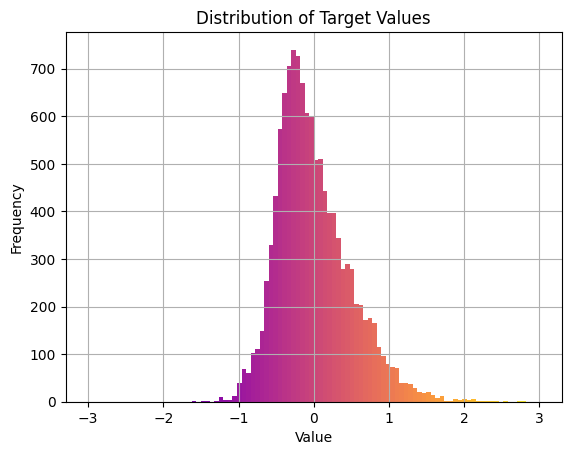

In [22]:
# Can we use Gaussian before logistic? This is determined by the distribution of feature X.

def plot_gradient_histogram(df: pd.DataFrame, bins=100, cmap_name='plasma'):
    """
    Plots a histogram of all values in the DataFrame with a gradient color map.
    """

    import matplotlib
    from matplotlib.colors import Normalize
    # Flatten data and remove NaNs
    data = df.values.flatten()
    data = data[~np.isnan(data)]
    
    # Compute histogram
    counts, bin_edges, patches = plt.hist(data, bins=bins, range=(-3,3))
    cmap = matplotlib.colormaps.get_cmap(cmap_name)
    norm = Normalize(vmin=bin_edges.min(), vmax=bin_edges.max())
    for edge, patch in zip(bin_edges, patches):
        patch.set_facecolor(cmap(norm(edge)))
    
    # Enhance plot aesthetics
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Target Values')
    plt.grid(True)
    plt.show()

# Plot the distribution of the train feature
plot_gradient_histogram(pd.DataFrame(train_feature.data))

# A little-bit gamma like. But anyway, bell shaped. That's okay.
# I have done a log transformation and it is better somehow.

`2.3 Train with Logistic Regression, 2.3.1 Evaluate with accuracy, precision, recall, F1-score, and ROC-AUC`

In [23]:
# A batch pipeline on doing this Logistic Regression task
# 

def logistic_regression(train_feature, test_feature, train_target, test_target,
                            use=["my"], plot=True, *, 
                            tol: float = 1e-8,
                            lr: float = 1e-2,
                            max_iter: int = 10000,
                            batch_size: int | None = None,
                            shuffle: bool = True,
                            l1: float = 0.0,
                            l2: float = 0.0,
                            verbosity: int = 1,
                            early_stop = None, 
                            early_stop_logic = "any",
                            evalset = None, 
                            evalmetrics = ["logloss"], 
                            continue_to_train = None,
                            **kwargs):
    
    """
    Trains and evaluates a Logistic Regression model using my implementation or sklearn's.

    Args:
        train_feature (Matrix | Tensor): Training feature data.
        test_feature (Matrix | Tensor): Test feature data.
        train_target (Matrix | Tensor): Training target labels.
        test_target (Matrix | Tensor): Test target labels.
        use: List of strings indicating the classification method to use. 
             Should be one of ["my", "sklearn"]. 
        plot: bool, whether to plot the ROC-AUC or not.
        tol: float, tolerence for convergence when optimizing.
        lr: float, learning rate. Default 1e-2.
        max_iter: int, maximum number of passes over the data. Default 10000.
        batch_size: int | None, minibatch size (None = full-batch GD).
        shuffle : bool, whether to reshuffle data at each epoch
        l1: float, optional Lasso penalty λ * sign(β) (0 = plain OLS).
        l2: float, optional Ridge penalty λ * ‖beta‖² (0 = plain OLS).
        verbosity (int): Whether to print some progresses if set to non-zero values.
        evalset (Dict[name : Tuple[X, y],
                     ...], | None) if provided, it may be used as evaluation set. XGBoost style.
        evalmetrics: (list of str | str | None) metrics used to do the evaluation. Will be printed.
        early_stop: (int | None) if non-None, then if metrics NOT gained for `early_stop` times, the forest will stop training.
        early_stop_logic: (str) the logic when deciding on multiple metrics, can be {"any", "some", "most", "all"}.
        continue_to_train: (bool | None) if non-None and True, the machine will try to restore the place it was and continue
                                to train new estimators until a new stopping criterion meets or until reaches the max number of allowed estimators.
        **kwargs: Any other arguments, for compatibility.

    Returns:
        tuple: A tuple containing model, accuracy, precision, recall, F1-score, AUC, and confusion matrix. ROC curve is only plotted when using "my" mode.

    Raises:
        ValueError: If `use` argument is neither "my" nor "sklearn".

    """

    # Returns a tuple of (Model, Accuracy, Precision, Recall, F1-Score, ROC/AUC, Confusion Matrix)
    
    if isinstance(use, list):
        use = use[0]
    if use != "my" and use != "sklearn":
        return ValueError("Arg `use` must be either `my` or `sklearn`!")
    
    # If using sklearn, forcefully convert data into numpy backend and scale it
    if use == "sklearn":
        train_feature = train_feature.to("numpy")
        train_target = train_target.to("numpy")
        test_feature = test_feature.to("numpy")
        test_target = test_target.to("numpy")
    else:
        pass

    # Create a logistic regressor instance before doing everything.
    if use == "my":
        if verbosity >= 1:
            print("Using my LR implementation as the regressor ...")
        model = LR("classification", family="logistic", fit_intercept=True, use="GD", tol=tol,
                   lr=lr, max_iter=max_iter, batch_size=batch_size, shuffle=shuffle, l1=l1, l2=l2, **kwargs)
    else:
        from sklearn.linear_model import LogisticRegression
        if verbosity >= 1:
            print("Using sklearn LogisticRegression as the regressor ...")
        model = LogisticRegression(penalty="l2", tol=tol, max_iter=max_iter, fit_intercept=True)

    # Fit the model with the training dataset
    if use == "my":
        if verbosity >= 2:
            print("Fitting ...")
        model.fit(train_feature, train_target, verbosity=verbosity, evalset=evalset, evalmetrics=evalmetrics,
                  early_stop=early_stop, early_stop_logic=early_stop_logic, continue_to_train=continue_to_train,
                   val_per_iter=25, **kwargs)
    else:
        if verbosity >= 2:
            print("Fitting ...")
        model.fit(train_feature.data, train_target.flatten().data)

    # Predict the values of the test set.
    if use == "my":
        if verbosity >= 2:
            print("Predicting ...")
        pred_values = model.predict(test_feature)
    else:
        if verbosity >= 2:
            print("Predicting ...")
        pred_values = type(test_feature)(model.predict_proba(test_feature.data)[:,[1]], backend="numpy").reshape([-1, 1])

    # Calculate Metrics
    acc_ = BinaryClassificationMetrics(pred_values, test_target, "accuracy").compute()
    prc_ = BinaryClassificationMetrics(pred_values, test_target, "precision").compute()
    rcl_ = BinaryClassificationMetrics(pred_values, test_target, "recall").compute()
    f1s_ = BinaryClassificationMetrics(pred_values, test_target, "f1").compute()
    auc_ = BinaryClassificationMetrics(pred_values, test_target, "auc_roc").compute()
    cfm_ = BinaryClassificationMetrics(pred_values, test_target, "confusion_matrix").compute()

    # If plot, then plot the roc curve
    if plot == True:
        from sklearn.metrics import roc_curve, auc
        false_positive_rate, true_positive_rate, _ = roc_curve(test_target.flatten().to("numpy").data, pred_values.flatten().to("numpy").data)
        auc_score = auc(false_positive_rate, true_positive_rate)
        plt.figure()
        lw = 2
        plt.title(f'ROC curve (area = {round(auc_score, 4)})')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.plot(false_positive_rate, true_positive_rate, color='darkorange', lw=lw)


    return model, acc_, prc_, rcl_, f1s_, auc_, cfm_

# Note. All of those metrics are computed by `RegressionMetrics`.
#       ROC Curve is plotted by matplotlib.

Using my LR implementation as the regressor ...
Training on Round: 0.
Training on Round: 25.
Training on Round: 50.
Evalset: [Val : Metrics { logloss:0.0793,  }]
Evalset: [Test : Metrics { logloss:0.0502,  }]
Training on Round: 75.
Evalset: [Val : Metrics { logloss:0.0775,  }]
Evalset: [Test : Metrics { logloss:0.0418,  }]
Training on Round: 100.
Evalset: [Val : Metrics { logloss:0.0773,  }]
Evalset: [Test : Metrics { logloss:0.0376,  }]
Training on Round: 125.
Evalset: [Val : Metrics { logloss:0.0779,  }]
Evalset: [Test : Metrics { logloss:0.0359,  }]
Training on Round: 150.
Evalset: [Val : Metrics { logloss:0.0788,  }]
Evalset: [Test : Metrics { logloss:0.0355,  }]
Model Config: {Logistic Regression, My GD using L2, eval_metrics = logloss}
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1 Score : 1.0
AUC      : [1.]
Confusion Matrix:
 [[32.  0.]
 [ 0. 54.]]


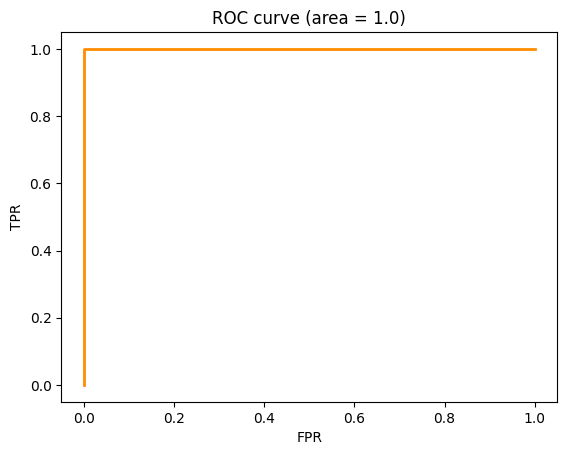

In [444]:
# Train and Evaluate the model - Train the L2 regularized Model by my LR
# 

model0, acc_, prc_, rcl_, f1s_, auc_, cfm_ = logistic_regression(
    train_feature, test_feature, train_target, test_target,
    use = "my", plot = True, lr = 0.02, max_iter=500, batch_size=None, l1=0, l2=1e-4,
    verbosity=1,
    early_stop=2,
    early_stop_logic="any",
    evalset={"Val": (val_feature, val_target), "Test": (test_feature, test_target)},
    evalmetrics=["logloss"]
)

# Evaluate performance on TEST SET.
print("Model Config: {Logistic Regression, My GD using L2, eval_metrics = logloss}")
print("Accuracy :", acc_.data)
print("Precision:", prc_.data)
print("Recall   :", rcl_.data)
print("F1 Score :", f1s_.data)
print("AUC      :", auc_.data)
print("Confusion Matrix:\n", cfm_.data)

Using sklearn LogisticRegression as the regressor ...
Model Config: {Logistic Regression, sklearn LogisticRegression}
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1 Score : 1.0
AUC      : [1.]
Confusion Matrix:
 [[32.  0.]
 [ 0. 54.]]


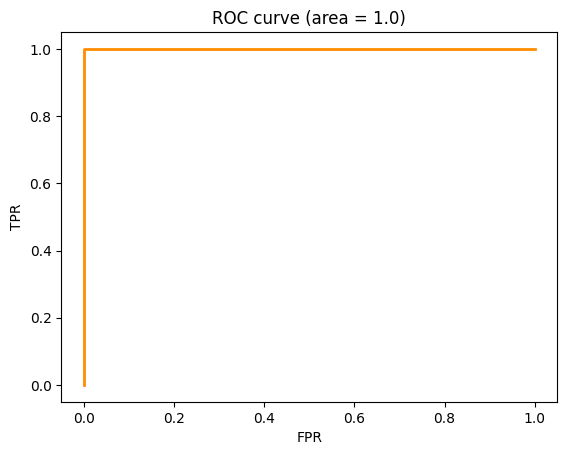

In [445]:
# Train and Evaluate the model - Train the L2 regularized Model by sklearn LogisticRegression
# 

model1, acc_, prc_, rcl_, f1s_, auc_, cfm_ = logistic_regression(
    train_feature, test_feature, train_target, test_target,
    use = "sklearn", plot = True, lr = 0.02, max_iter=500,
    verbosity=1)

# Evaluate performance on TEST SET.
print("Model Config: {Logistic Regression, sklearn LogisticRegression}")
print("Accuracy :", acc_.data)
print("Precision:", prc_.data)
print("Recall   :", rcl_.data)
print("F1 Score :", f1s_.data)
print("AUC      :", auc_.data)
print("Confusion Matrix:\n", cfm_.data)

In [ ]:
# A short review on the performance
# 
#                       ACC     PREC    Recall   F1-Score
# 
# LR logistic           1.0      1.0       1.0        1.0
# Sklearn Logistic      1.0      1.0       1.0        1.0
# Comparable: SVM    0.9883      1.0    0.9688     0.9841  *Extracted from the 1st homework
# Comparable: SVC    0.9766   0.9838    0.9531     0.9683  *Extracted from the 1st homework
#
# > From the figures above, we have those observations：
# > 1. At least, as a simple traditional machine learning model, Logistic Regression has comparable performance
#      with Support Vector Machine algorithm and it performed slightly better.
# > 2. The reason why these logistic regression results are all 100% is that it just happened to correctly 
#      classified all cases in this split (while we can see, the result isn't perfect in the validation set).
#      Moreover, since we used a 70-15-15 split, fewer samples made a 100 percent guess rather easier.
#      And as you can see in the following chapter, by showing the prediction-vs-true, we can see the 100% result
#      isn't just a guess - it makes sense to correcrly classified most of samples as what they should be.
# > 3. Based on this case, my LR logistic regression performed as good as the sklearn LogisticRegresion model,
#      who also achieved 100% accuracy in all 87 samples in the test set.

In [ ]:
# Example of saving the Logistic Regression model to disk.
#

# |
# V De-comment this line to save the model.
# model0.save(model0, "./models/LogisticRegression.ID00.bin")

`2.3.2 (Experimental, Bonus) Visualization of the predictions`

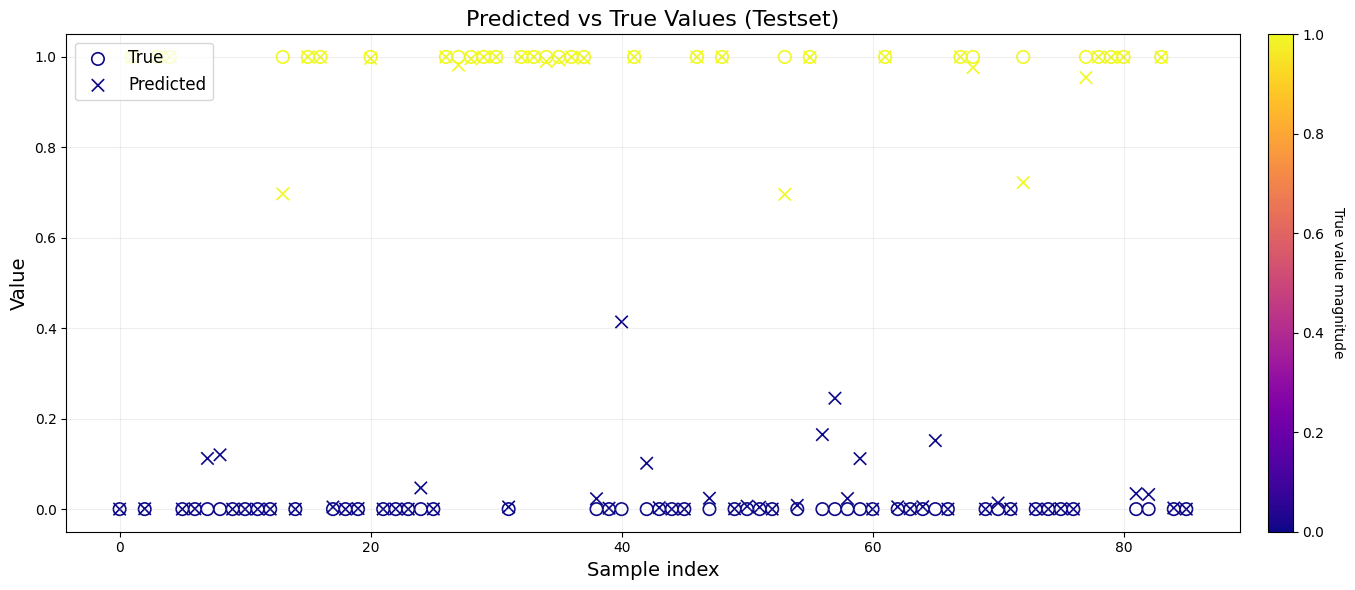

In [ ]:
# Prediction vs. True values (scatter plot) - using model0
# 

# Prediction by model0
pred_y = model0.predict(test_feature)

# Plot prediction versus true
def plot_pred_vs_true(y_true: np.ndarray,
                      y_pred: np.ndarray,
                      *,
                      cmap: str = 'plasma',
                      base_marker_size: int = None,
                      alpha: float = None,
                      rasterized: bool = True):
    """
    Scatter true vs. predicted values over sample index, with:
      - hollow circles for true
      - '×' for predicted
      - color‑encoded by true value magnitude
      - auto‑adjusted marker_size & alpha when n is large
      - optional rasterization for very large n
    
    This version always passes the Axes to the colorbar to avoid
    the “Unable to determine Axes” error.
    """
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")
    
    n = y_true.shape[0]
    # auto‑tune marker size & alpha for big datasets
    from matplotlib import colors
    if base_marker_size is None:
        base_marker_size = 80 if n < 5_000 else 20
    if alpha is None:
        alpha = 1.0 if n < 5_000 else 0.3

    # Normalize true‑value magnitude for coloring
    norm = colors.Normalize(vmin=y_true.min(), vmax=y_true.max())
    cmap_obj = plt.colormaps[cmap]

    # Create a Figure + Axes
    fig, ax = plt.subplots(figsize=(15, 6))

    idx = np.arange(n)

    # True values: hollow circles
    ax.scatter(idx, y_true,
               marker='o',
               facecolors='none',
               edgecolors=cmap_obj(norm(y_true)),
               s=base_marker_size,
               linewidths=1.2,
               alpha=alpha,
               rasterized=rasterized,
               label='True')

    # Predicted values: × markers
    ax.scatter(idx, y_pred,
               marker='x',
               c=cmap_obj(norm(y_true)),
               s=base_marker_size,
               linewidths=1.2,
               alpha=alpha,
               rasterized=rasterized,
               label='Predicted')

    # Create a ScalarMappable and attach it to this Axes
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    sm.set_array(y_true)  # Associate the data for the colorbar

    # Now tell the figure which Axes to steal space from
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label('True value magnitude', rotation=270, labelpad=15)

    ax.set_title('Predicted vs True Values (Testset)', fontsize=16)
    ax.set_xlabel('Sample index', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(alpha=0.2)

    fig.tight_layout()
    plt.show()

# Since the number is large, we plot the first 100 entries.
plot_pred_vs_true(test_target.flatten()[0:100].to_numpy_array(), pred_y.flatten()[0:100].to_numpy_array())

# We can see even if some points are not close to 0 or 1, they are all correctly classified.
# We can also see most of the predictions are super close to the real target (0 or 1) after applied the sigmoid function.

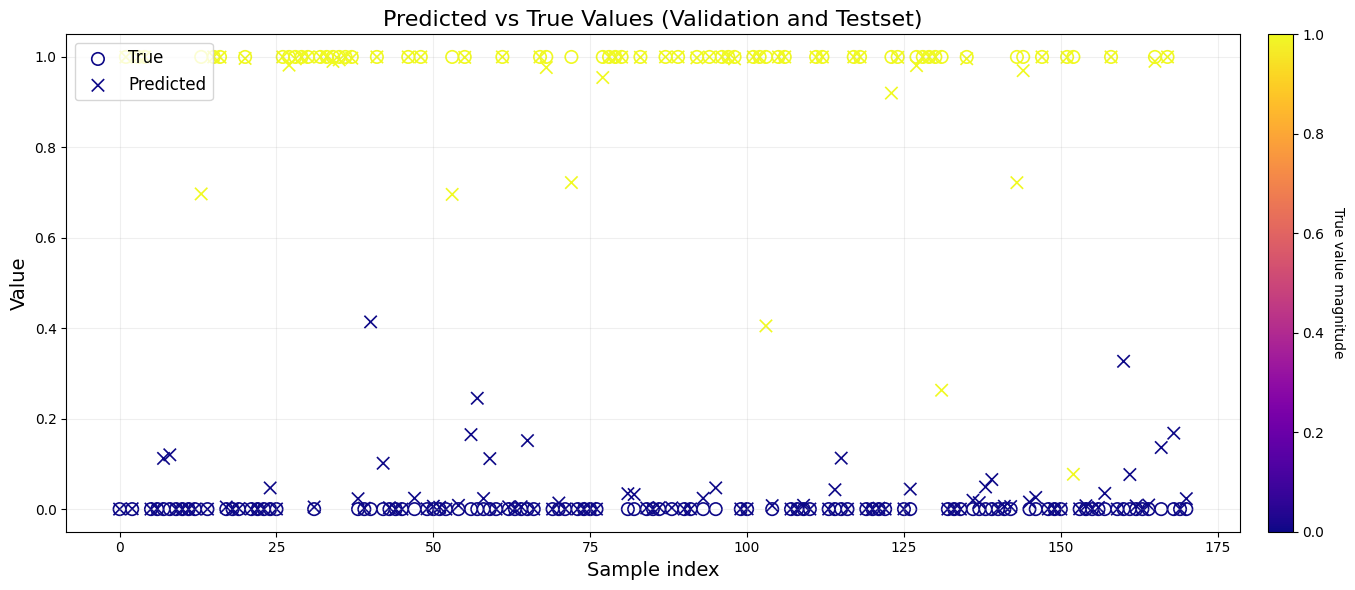

In [ ]:
# Prediction vs. True values (scatter plot) - using model0
# 

# Prediction by model0
pred_y = model0.predict(test_feature.vstack(val_feature))

# Plot prediction versus true
def plot_pred_vs_true(y_true: np.ndarray,
                      y_pred: np.ndarray,
                      *,
                      cmap: str = 'plasma',
                      base_marker_size: int = None,
                      alpha: float = None,
                      rasterized: bool = True):
    """
    Scatter true vs. predicted values over sample index, with:
      - hollow circles for true
      - '×' for predicted
      - color‑encoded by true value magnitude
      - auto‑adjusted marker_size & alpha when n is large
      - optional rasterization for very large n
    
    This version always passes the Axes to the colorbar to avoid
    the “Unable to determine Axes” error.
    """
    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")
    
    n = y_true.shape[0]
    # auto‑tune marker size & alpha for big datasets
    from matplotlib import colors
    if base_marker_size is None:
        base_marker_size = 80 if n < 5_000 else 20
    if alpha is None:
        alpha = 1.0 if n < 5_000 else 0.3

    # Normalize true‑value magnitude for coloring
    norm = colors.Normalize(vmin=y_true.min(), vmax=y_true.max())
    cmap_obj = plt.colormaps[cmap]

    # Create a Figure + Axes
    fig, ax = plt.subplots(figsize=(15, 6))

    idx = np.arange(n)

    # True values: hollow circles
    ax.scatter(idx, y_true,
               marker='o',
               facecolors='none',
               edgecolors=cmap_obj(norm(y_true)),
               s=base_marker_size,
               linewidths=1.2,
               alpha=alpha,
               rasterized=rasterized,
               label='True')

    # Predicted values: × markers
    ax.scatter(idx, y_pred,
               marker='x',
               c=cmap_obj(norm(y_true)),
               s=base_marker_size,
               linewidths=1.2,
               alpha=alpha,
               rasterized=rasterized,
               label='Predicted')

    # Create a ScalarMappable and attach it to this Axes
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    sm.set_array(y_true)  # Associate the data for the colorbar

    # Now tell the figure which Axes to steal space from
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label('True value magnitude', rotation=270, labelpad=15)

    ax.set_title('Predicted vs True Values (Validation and Testset)', fontsize=16)
    ax.set_xlabel('Sample index', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.legend(fontsize=12, loc='upper left')
    ax.grid(alpha=0.2)

    fig.tight_layout()
    plt.show()

# Since the number is large, we plot the first 200 entries.
plot_pred_vs_true(test_target.vstack(val_target).flatten()[0:200].to_numpy_array(), pred_y.flatten()[0:200].to_numpy_array())

# Among both validation and test sets, we found there are three cases that are misclassified.
# All of them are malicious cases and they are misclassified to be benign.
# * It is somehow dangerous if all of the errors are false negatives. We can, in the future, try the following ways to ameliorate this issue:
#   1. Try use a lower threshold, like 0.4 or even lower (0.2), if detected with uncertainty (not close to 0 or 1), 
#      then use a professional doctor to do a manual inspection
#   2. There may be systematic problem in the simple model as there are super-low-value false negative cases. Try consider 
#      a more complex model like RandomForest, other ensemble models or even neural networks.
#   3. The best way is to increase the number of samples. It is an ultimate solution to the precision-recall tradeoff.

`2.3.3 Comparable Tests on my LR and the sklearn LogisticRegression`

In [ ]:
# Randomly split the dataset into 70% training, 30% test repeatedly and do the same task
# on the same data by two different models and see how results are distributed
# 

# We collect five main metrics for both models
acc_scores = [[],[],[]]
prec_scores = [[],[],[]]
recall_scores = [[],[],[]]
f1score_scores = [[],[],[]]
rocauc_scores = [[],[],[]]

# Create a task function to randomly split the dataset, scaling, and do a batch of training and evaluation
def comparable_logistic_test():
    
    # The balanced train_test_split is implemented in the MLBase class.
    train_feature, test_feature, train_target, test_target = MLBase.train_test_split_binarydata_siid(
        features_cancer, target_cancer, test_size=0.3, random_state=None) 
    
    # Scale the Feature Matrix by using quassi-normalization scaling
    ft_scaler = Scaling("normalize").fit(train_feature)
    train_feature = ft_scaler.transform(train_feature) / 2
    test_feature = ft_scaler.transform(test_feature)   / 2

    # Train my model and fetch the statistics
    model_my, acc_my, prc_my, rcl_my, f1s_my, auc_my, cfm_my = logistic_regression(
        train_feature, test_feature, train_target, test_target,
        use = "my", plot = False, lr = 0.012, max_iter=1000, batch_size=None, l1=0, l2=1e-4,
        verbosity=0,
        early_stop=2,
        early_stop_logic="any",
        evalset={"Test": (test_feature, test_target)},
        evalmetrics=["logloss"]
    )

    # Train the sklearn model and fetch the statistics
    model_sk, acc_sk, prc_sk, rcl_sk, f1s_sk, auc_sk, cfm_sk = logistic_regression(
        train_feature, test_feature, train_target, test_target,
        use = "sklearn", plot = False, lr = 0.012, max_iter=1000,
        verbosity=0)
    
    # Append mine and sklearn
    acc_scores[0].append(acc_my.to_list())
    prec_scores[0].append(prc_my.to_list())
    recall_scores[0].append(rcl_my.to_list())
    f1score_scores[0].append(f1s_my.to_list())
    rocauc_scores[0].append(auc_my.to_list()[0])

    acc_scores[1].append(acc_sk.to_list())
    prec_scores[1].append(prc_sk.to_list())
    recall_scores[1].append(rcl_sk.to_list())
    f1score_scores[1].append(f1s_sk.to_list())
    rocauc_scores[1].append(auc_sk.to_list()[0])

    # Append the difference
    acc_scores[2].append(acc_my.to_list() - acc_sk.to_list())
    prec_scores[2].append(prc_my.to_list() - prc_sk.to_list())
    recall_scores[2].append(rcl_my.to_list() - rcl_sk.to_list())
    f1score_scores[2].append(f1s_my.to_list() - f1s_sk.to_list())
    rocauc_scores[2].append(auc_my.to_list()[0] - auc_sk.to_list()[0])

# Perform 100 times
for i in range(100):
    comparable_logistic_test()


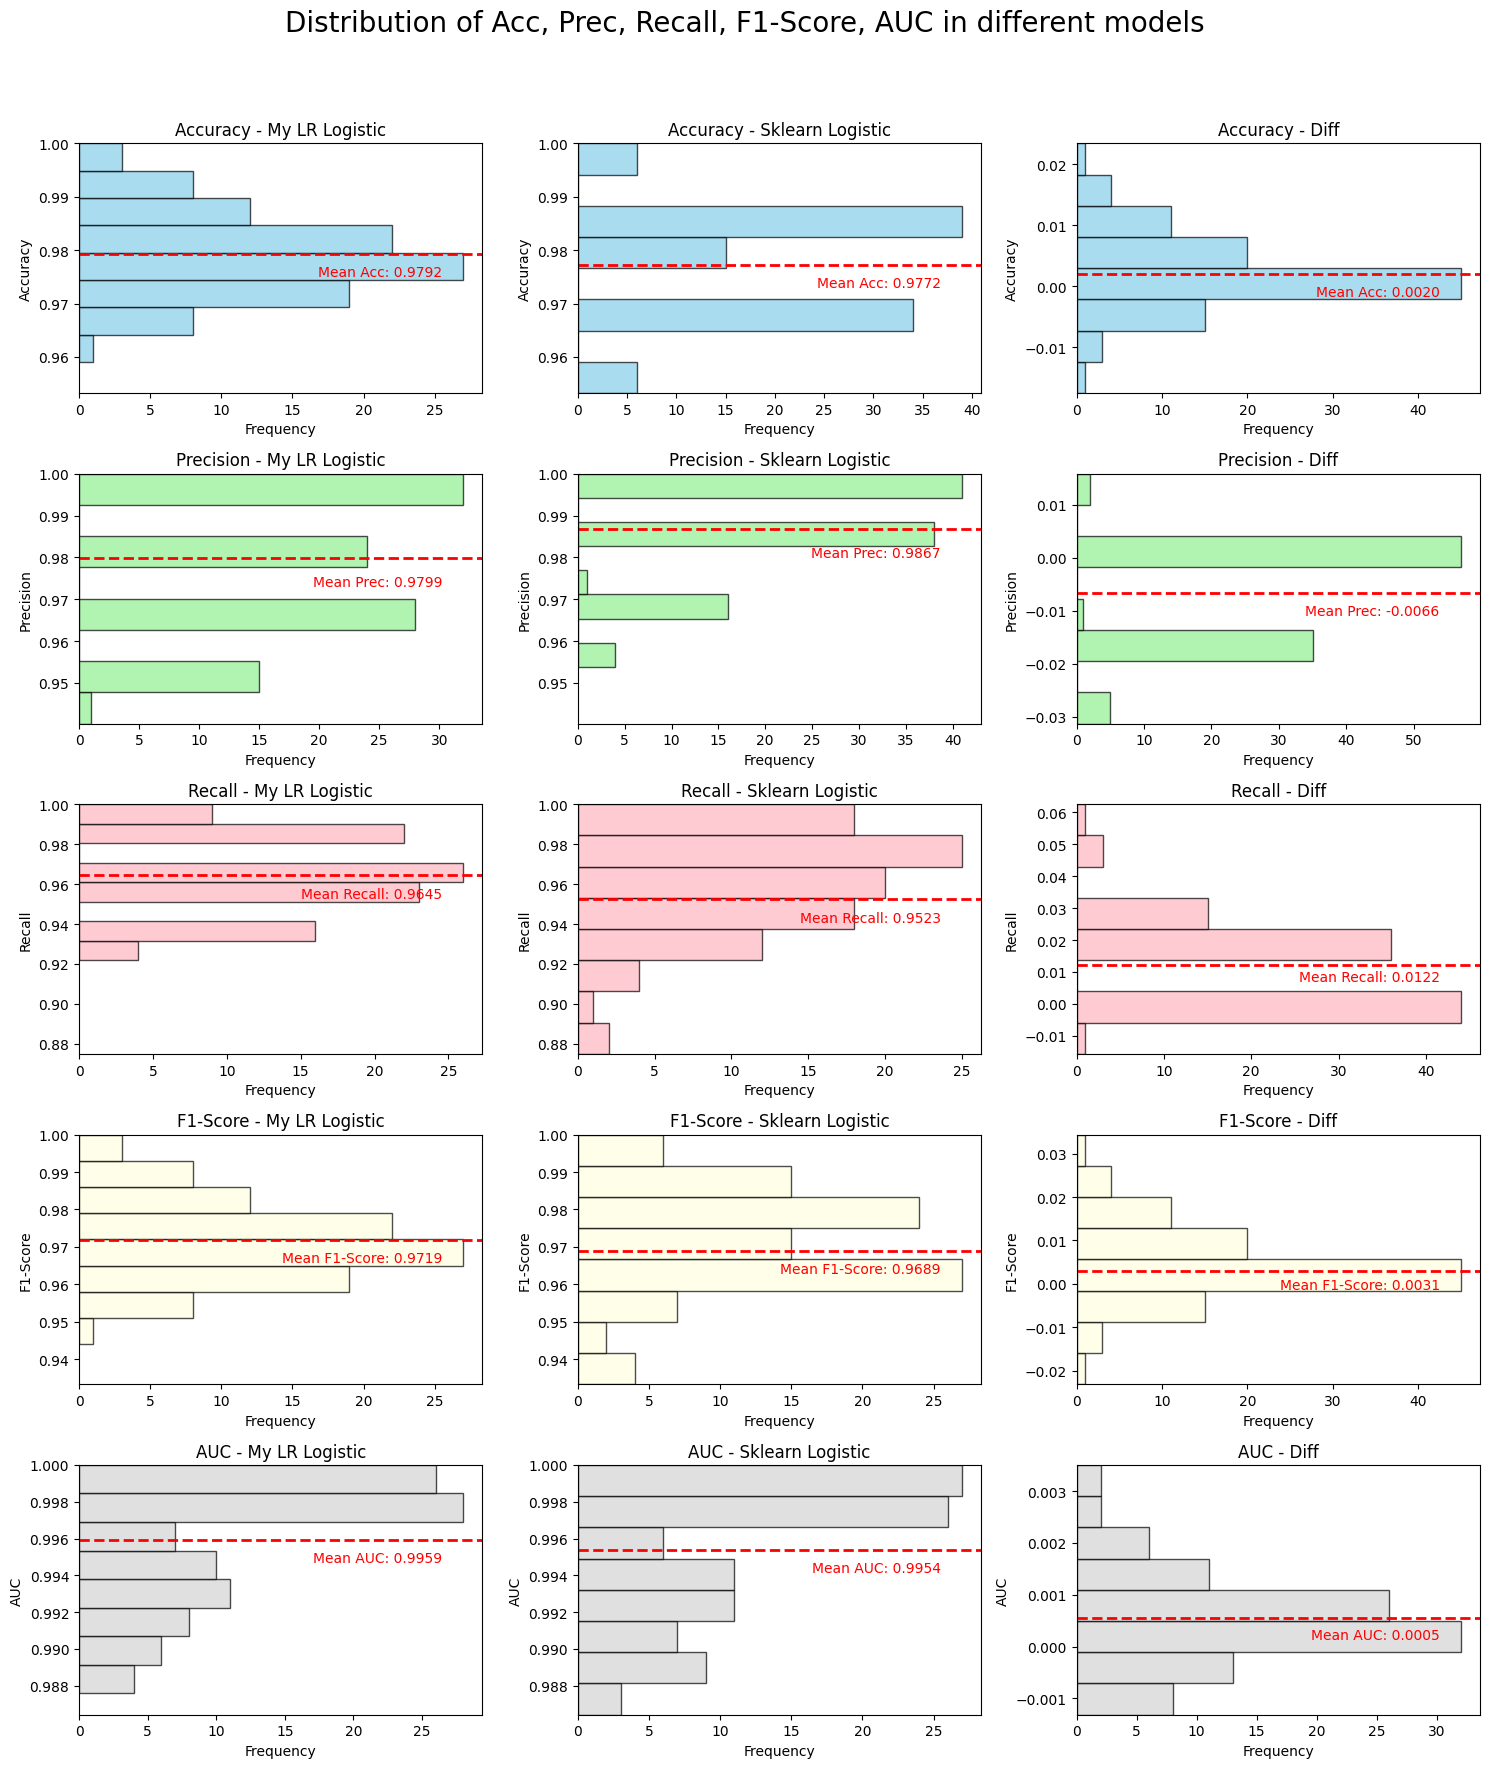

In [41]:
# Randomly split the dataset into 70% training, 30% test repeatedly and do the same task
# on the same data by two different models and see how results are distributed
# 

# Prepare to plot the chart
# 
# Names for two models
nsnames = ["My LR Logistic", "Sklearn Logistic", "Diff"]

# Compute global y-axis limits for each metric.
# Note. I want to make the y-axis have the same limits for sub-plots.
acc_min = [np.min(arr) for arr in acc_scores]; acc_min[1] = min(acc_min[0], acc_min[1]); acc_min[0] = acc_min[1];
acc_max = [np.max(arr) for arr in acc_scores]; acc_max[1] = max(acc_max[0], acc_max[1]); acc_max[0] = acc_max[1];
prec_min = [np.min(arr) for arr in prec_scores]; prec_min[1] = min(prec_min[0], prec_min[1]); prec_min[0] = prec_min[1];
prec_max = [np.max(arr) for arr in prec_scores]; prec_max[1] = max(prec_max[0], prec_max[1]); prec_max[0] = prec_max[1];
recl_min = [np.min(arr) for arr in recall_scores]; recl_min[1] = min(recl_min[0], recl_min[1]); recl_min[0] = recl_min[1];
recl_max = [np.max(arr) for arr in recall_scores]; recl_max[1] = max(recl_max[0], recl_max[1]); recl_max[0] = recl_max[1];
f1sc_min = [np.min(arr) for arr in f1score_scores]; f1sc_min[1] = min(f1sc_min[0], f1sc_min[1]); f1sc_min[0] = f1sc_min[1];
f1sc_max = [np.max(arr) for arr in f1score_scores]; f1sc_max[1] = max(f1sc_max[0], f1sc_max[1]); f1sc_max[0] = f1sc_max[1];
rocauc_min = [np.min(arr) for arr in rocauc_scores]; rocauc_min[1] = min(rocauc_min[0], rocauc_min[1]); rocauc_min[0] = rocauc_min[1];
rocauc_max = [np.max(arr) for arr in rocauc_scores]; rocauc_max[1] = max(rocauc_max[0], rocauc_max[1]); rocauc_max[0] = rocauc_max[1];

# Create a figure with 5 rows and 3 columns.
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 18))
fig.suptitle('Distribution of Acc, Prec, Recall, F1-Score, AUC in different models', fontsize=20)

# Plot horizontal histograms for each method.
for i, method in enumerate(nsnames):
    
    # Top row: Accuracy histograms, blue.
    data_acc = acc_scores[i]
    ax_acc = axes[0, i]
    counts, bins, patches = ax_acc.hist(data_acc, bins=8, orientation='horizontal',
                                        alpha=0.7, color='skyblue', edgecolor='black')
    mean_acc = np.mean(data_acc)
    ax_acc.axhline(mean_acc, color='red', linestyle='dashed', linewidth=2)
    xmax = ax_acc.get_xlim()[1]
    if i != 2:
        ax_acc.text(xmax * 0.9, mean_acc * 0.9966, f'Mean Acc: {mean_acc:.4f}', color='red', va='center', ha='right')
    else:
        ax_acc.text(xmax * 0.9, mean_acc * -0.5, f'Mean Acc: {mean_acc:.4f}', color='red', va='center', ha='right')
    ax_acc.set_title(f'Accuracy - {method}')
    ax_acc.set_xlabel('Frequency')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.set_ylim(acc_min[i], acc_max[i])

    # Upper Middle row: Precision score histograms, green.
    data_prec = prec_scores[i]
    ax_prec = axes[1, i]
    counts, bins, patches = ax_prec.hist(data_prec, bins=8, orientation='horizontal',
                                         alpha=0.7, color='lightgreen', edgecolor='black')
    mean_prec = np.mean(data_prec)
    ax_prec.axhline(mean_prec, color='red', linestyle='dashed', linewidth=2)
    xmax = ax_prec.get_xlim()[1]
    if i != 2:
        ax_prec.text(xmax * 0.9, mean_prec * 0.9942, f'Mean Prec: {mean_prec:.4f}', color='red', va='center', ha='right')
    else:
        ax_prec.text(xmax * 0.9, mean_prec * 1.5, f'Mean Prec: {mean_prec:.4f}', color='red', va='center', ha='right')
    ax_prec.set_title(f'Precision - {method}')
    ax_prec.set_xlabel('Frequency')
    ax_prec.set_ylabel('Precision')
    ax_prec.set_ylim(prec_min[i], prec_max[i])

    # Lower Middle row: Recall score histograms, pink.
    data_recl = recall_scores[i]
    ax_recl = axes[2, i]
    counts, bins, patches = ax_recl.hist(data_recl, bins=8, orientation='horizontal',
                                         alpha=0.7, color='lightpink', edgecolor='black')
    mean_recl = np.mean(data_recl)
    ax_recl.axhline(mean_recl, color='red', linestyle='dashed', linewidth=2)
    xmax = ax_recl.get_xlim()[1]
    if i != 2:
        ax_recl.text(xmax * 0.9, mean_recl * 0.99, f'Mean Recall: {mean_recl:.4f}', color='red', va='center', ha='right')
    else:
        ax_recl.text(xmax * 0.9, mean_recl * 0.7, f'Mean Recall: {mean_recl:.4f}', color='red', va='center', ha='right')
    ax_recl.set_title(f'Recall - {method}')
    ax_recl.set_xlabel('Frequency')
    ax_recl.set_ylabel('Recall')
    ax_recl.set_ylim(recl_min[i], recl_max[i])

    # Lower row: F1-Score score histograms, pink.
    data_f1sc = f1score_scores[i]
    ax_f1sc = axes[3, i]
    counts, bins, patches = ax_f1sc.hist(data_f1sc, bins=8, orientation='horizontal',
                                         alpha=0.7, color='lightyellow', edgecolor='black')
    mean_f1sc = np.mean(data_f1sc)
    ax_f1sc.axhline(mean_f1sc, color='red', linestyle='dashed', linewidth=2)
    xmax = ax_f1sc.get_xlim()[1]
    if i != 2:
        ax_f1sc.text(xmax * 0.9, mean_f1sc * 0.995, f'Mean F1-Score: {mean_f1sc:.4f}', color='red', va='center', ha='right')
    else:
        ax_f1sc.text(xmax * 0.9, mean_f1sc * -0.1, f'Mean F1-Score: {mean_f1sc:.4f}', color='red', va='center', ha='right')
    ax_f1sc.set_title(f'F1-Score - {method}')
    ax_f1sc.set_xlabel('Frequency')
    ax_f1sc.set_ylabel('F1-Score')
    ax_f1sc.set_ylim(f1sc_min[i], f1sc_max[i])

    # Bottom row: AUC score histograms, pink.
    data_rocauc = rocauc_scores[i]
    ax_rocauc = axes[4, i]
    counts, bins, patches = ax_rocauc.hist(data_rocauc, bins=8, orientation='horizontal',
                                         alpha=0.7, color='lightgrey', edgecolor='black')
    mean_rocauc = np.mean(data_rocauc)
    ax_rocauc.axhline(mean_rocauc, color='red', linestyle='dashed', linewidth=2)
    xmax = ax_rocauc.get_xlim()[1]
    if i != 2:
        ax_rocauc.text(xmax * 0.9, mean_rocauc * 0.9990, f'Mean AUC: {mean_rocauc:.4f}', color='red', va='center', ha='right')
    else:
        ax_rocauc.text(xmax * 0.9, mean_rocauc * 0.4, f'Mean AUC: {mean_rocauc:.4f}', color='red', va='center', ha='right')
    ax_rocauc.set_title(f'AUC - {method}')
    ax_rocauc.set_xlabel('Frequency')
    ax_rocauc.set_ylabel('AUC')
    ax_rocauc.set_ylim(rocauc_min[i], rocauc_max[i])

# Show the plot (5 * 3 sub-plot matrix).
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [ ]:
# Short Comparision between implementations
# 
#                        ACC     PREC    Recall   F1-Score
# Single Evaluation
#    LR Logistic         1.0      1.0       1.0        1.0
#    Sklearn Logistic    1.0      1.0       1.0        1.0
#    Comparable:SVM   0.9883      1.0    0.9688     0.9841  *Extracted from the 1st homework
#    Comparable:SVC   0.9766   0.9838    0.9531     0.9683  *Extracted from the 1st homework
#
#                        ACC     PREC    Recall   F1-Score   ROC-AUC
# 100 Round Mean
#        LR Logistic  0.9792   0.9799    0.9645     0.9719    0.9959
#   Sklearn Logistic  0.9772   0.9867    0.9523     0.9689    0.9954
# 100 Round Stddev
#        LR Logistic  0.0089   0.0169    0.0206     0.0120    0.0034
#   Sklearn Logistic  0.0098   0.0132    0.0259     0.0137    0.0037
#
# Conclusion:
# > ⭐ Performance: On average, my Logistic regression using LR and Gradient method performs at a comparable level with
#   sklearn's LogisticRegression. While some difference may exist, like the precision (yes, precision again) has a little bit
#   too-low problem (as described in the chapter summarization, a little bit systematic problem of false negatives) metric,
#   which is slightly lower than that by sklearn. But overall, it has achieved a comparable level as indicated by other metrics
#   like accuracy, f1-score and roc-auc, meaning my implementation has the ability to perform logistic tasks.
# 
# > ⭐ Speed: It has been faster and faster compared to my previous implementation in the last submission. The main part I have 
#   modified is the ._backward() method. It now by default uses `Adam` optimizer in stead of `SGD`, making the convergence at least
#   5 times faster. And regarding the absolute time costed, in the single-model case, my implementation runned for 0.4 second and the
#   sklearn model runned for approximately 0.1 second. It is the nearest distance I have ever had while programming this library and doing 
#   the series of assignments.
# 
# > ⭐ Versatility: The greatest point in my implementation is that I have implemented an interactive training and evaluation system.
#   It allows engineers to flexibly adjust the evaluation metrics, whether to stop training, or resume the previous training process.
#   You can set multiple metrics on multiple datasets, print the training process, and specify a flexible strategy to stop training. 
#   I believe this should help prevent overfitting.

`End of Homework 3 Q1 by Nathmath Huang (bh2821)`